# Sobol Sensitivity Indices for the BTD Model

## Setup packages.

In [1]:
require(data.table)
require(magrittr)
require(rpart)
require(sensitivity)
require(SobolSequence)

require(ggplot2)

Loading required package: data.table
Loading required package: magrittr
Loading required package: rpart
Loading required package: sensitivity
Registered S3 method overwritten by 'sensitivity':
  method    from 
  print.src dplyr
Loading required package: SobolSequence
Loading required package: ggplot2


## Design experiment.

### Load input ranges.

In [2]:
z.ranges <- fread("input-ranges-si.tsv")
z.ranges %>% dim

[1] 32  9

In [3]:
z.ranges %>% summary

   Variable            Units               Type           Model Minimum   
 Length:32          Length:32          Length:32          Min.   :  0.00  
 Class :character   Class :character   Class :character   1st Qu.:  0.00  
 Mode  :character   Mode  :character   Mode  :character   Median :  0.01  
                                                          Mean   : 17.89  
                                                          3rd Qu.:  1.00  
                                                          Max.   :168.00  
 Model Maximum      Model Default       Sensitivity Minimum Sensitivity Maximum
 Length:32          Min.   :        0   Min.   :        0   Min.   :0.000e+00  
 Class :character   1st Qu.:        0   1st Qu.:        0   1st Qu.:3.000e+00  
 Mode  :character   Median :        1   Median :        0   Median :1.400e+01  
                    Mean   : 12547769   Mean   :  3764340   Mean   :5.865e+07  
                    3rd Qu.:     1664   3rd Qu.:      512   3rd Qu.:1.058e+

### Experiment based on Sobol sequences.

In [381]:
n <- 2500
k <- dim(z.ranges)[1]

In [382]:
z.design <- sobolSequence.points(2 * k, count = n)
colnames(z.design) <- c(z.ranges$Variable, z.ranges$Variable)
z.design %>% dim

[1] 2500   64

In [383]:
write.table(z.design, file = "design-si.tsv", row.names = FALSE, col.names = TRUE, sep = "\t", quote = FALSE)

### Relate the design to the model's variables.

In [384]:
z.ab <- z.design
for (i in 1:k) {
    for (j in c(i, k + i)) {
        z.ab[, j] <- z.ranges[i, `Sensitivity Minimum`] * (1 - z.ab[, j]) +
                     z.ranges[i, `Sensitivity Maximum`] *      z.ab[, j]
        if (z.ranges[i, `Type`] %in% c("Integer", "Boolean"))
            z.ab[, j] <- round(z.ab[, j])
    }
}
z.inputs <- rbind(
    data.table(Matrix = "A", Index = 0, z.ab[, 1:k    ]),
    data.table(Matrix = "B", Index = 0, z.ab[, 1:k + k])    
)
for (i in 1:k) {
    z.c <- z.ab[, 1:k + k]
    z.c[, i] <- z.ab[, i]
    z.inputs <- rbind(
        z.inputs,
        data.table(Matrix = "C", Index = i, z.c)
    )
}
z.inputs <- cbind(
    Run = 1:dim(z.inputs)[1],
    z.inputs
)
z.inputs %>% dim

[1] 85000    35

In [385]:
z.inputs %>% summary

      Run           Matrix              Index       aversion to NPV deviation
 Min.   :    1   Length:85000       Min.   : 0.00   Min.   :0.0600           
 1st Qu.:21251   Class :character   1st Qu.: 7.00   1st Qu.:0.7098           
 Median :42500   Mode  :character   Median :15.50   Median :1.3597           
 Mean   :42500                      Mean   :15.53   Mean   :1.3600           
 3rd Qu.:63750                      3rd Qu.:24.00   3rd Qu.:2.0095           
 Max.   :85000                      Max.   :32.00   Max.   :2.6594           
 base external investor ask rate bioproduct long term price
 Min.   : 2.400                  Min.   :1500              
 1st Qu.: 6.398                  1st Qu.:3374              
 Median :10.396                  Median :5248              
 Mean   :10.396                  Mean   :5249              
 3rd Qu.:14.394                  3rd Qu.:7122              
 Max.   :18.392                  Max.   :8996              
 bioproduct performance advantage 

In [386]:
write.table(z.inputs[, 1:3], file="indices-si.tsv", row.names = FALSE, col.names = TRUE, sep = "\t", quote = FALSE)

In [387]:
write.table(z.inputs[, -(2:3)], file="inputs-si.tsv", row.names = FALSE, col.names = TRUE, sep = "\t", quote = FALSE)

## Analyze results.

### Read files.

#### Read design.

In [2]:
z.design <- fread("design-si.tsv")
z.design %>% dim

[1] 2500   64

In [3]:
n <- dim(z.design)[1]
k <- dim(z.design)[2] / 2

#### Read inputs.

In [4]:
z.inputs <- fread("inputs-si.tsv")
z.inputs %>% dim

[1] 85000    33

#### Read outputs.

In [5]:
z.outputs <- rbind(
    fread("outputs-si-direct-niche.tsv"     )[, `:=`(Replacement="Direct"    , Scale="Niche"    )],
    fread("outputs-si-direct-commodity.tsv" )[, `:=`(Replacement="Direct"    , Scale="Commodity")],
    fread("outputs-si-perfadv-niche.tsv"    )[, `:=`(Replacement="Advantaged", Scale="Niche"    )],
    fread("outputs-si-perfadv-commodity.tsv")[, `:=`(Replacement="Advantaged", Scale="Commodity")]
)[order(Replacement, Scale, Run, Time)]
z.outputs <- z.outputs[, c(52:53, 1:51)]
z.outputs %>% summary

 Replacement           Scale                Run             Time     
 Length:2720000     Length:2720000     Min.   :    1   Min.   :2015  
 Class :character   Class :character   1st Qu.:21251   1st Qu.:2024  
 Mode  :character   Mode  :character   Median :42500   Median :2032  
                                       Mean   :42500   Mean   :2032  
                                       3rd Qu.:63750   3rd Qu.:2041  
                                       Max.   :85000   Max.   :2050  
 bioproduct market share mass current market size economic
 Min.   :-6.390860            Min.   :-3.391e+07          
 1st Qu.: 0.003375            1st Qu.: 2.034e+10          
 Median : 0.010708            Median : 4.778e+10          
 Mean   : 0.087017            Mean   : 1.437e+11          
 3rd Qu.: 0.030994            3rd Qu.: 1.276e+11          
 Max.   :13.133500            Max.   : 1.272e+13          
 current market size mass long term market share long term market value
 Min.   :1.855e+04       

In [6]:
z.outputs.long <- melt(
    z.outputs,
    id.vars=c("Replacement", "Scale", "Run", "Time"),
    variable.name="Variable",
    value.name="Value"
)[, Case:=paste(Replacement, Scale)]

Warning message in melt.data.table(z.outputs, id.vars = c("Replacement", "Scale", :
"'measure.vars' [bioproduct market share mass, current market size economic, current market size mass, long term market share, ...] are not all of the same type. By order of hierarchy, the molten data value column will be of type 'double'. All measure variables not of type 'double' will be coerced too. Check DETAILS in ?melt.data.table for more on coercion."

In [7]:
write.table(z.outputs     , file = "outputs-si-wide.tsv", row.names = FALSE, col.names = TRUE, sep = "\t", quote = FALSE)
write.table(z.outputs.long, file = "outputs-si-long.tsv", row.names = FALSE, col.names = TRUE, sep = "\t", quote = FALSE)

In [ ]:
z.outputs      <- fread("outputs-si-wide.tsv")
z.outputs.long <- fread("outputs-si-long.tsv")

### Compute sensitivity indices

In [8]:
calc_st0 <- function(inp, out, ya, yb, ybia) {
    v <- (ya - yb) %*% (ya - yb)
    data.table(
        Input = inp,
        Output = out,
        S = (1 - ((ya - ybia) %*% (ya - ybia)) / v)[1],
        T = (    ((yb - ybia) %*% (yb - ybia)) / v)[1]
    )
}

calc_st <- function(inp, out, ya, yb, ybia, boot = 1) {
    if (boot == 1)
        return(calc_st0(inp, out, ya, yb, ybia))
    result <- NULL
    for (j in 1:boot) {
        ix <- sample(1:length(ya), length(ya), replace = TRUE)
        result <- rbind(
            result,
            calc_st0(inp, out, ya[ix], yb[ix], ybia[ix])
        )
    }
    result
}

In [9]:
sensitivityIndices <- function(inputs, outputs, boot = 1) {
    result <- NULL
    for (i in 5:ncol(outputs)) {
        ya <-        as.matrix(outputs[1:n              , i, with=FALSE])
        yb <-        as.matrix(outputs[1:n + n          , i, with=FALSE])
        yc <- matrix(as.matrix(outputs[(2*n+1):((k+2)*n), i, with=FALSE]), nrow=n, byrow=FALSE)
        for (j in 2:ncol(inputs)) {
            result <- rbind(
                result,
                calc_st(colnames(inputs)[j-1], colnames(outputs)[i], as.vector(ya), as.vector(yb), yc[, j-1], boot)
            )
        }
    }
    result
}

In [ ]:
z.sens <- NULL
cases <- unique(z.outputs[, .(Replacement, Scale)])
for (i in 1:nrow(cases))
    z.sens <- rbind(
        z.sens,
        cbind(
            Replacement = cases[i, Replacement],
            Scale = cases[i, Scale],
            sensitivityIndices(z.inputs, z.outputs[Replacement == cases[i, Replacement] & Scale == cases[i, Scale] & Time == 2050])
        )
    )
z.sens %>% dim

In [10]:
z.sens <- sensitivityIndices(
    z.inputs,
    z.outputs[Replacement == "Advantaged" & Scale == "Niche" & Time == 2050]
)

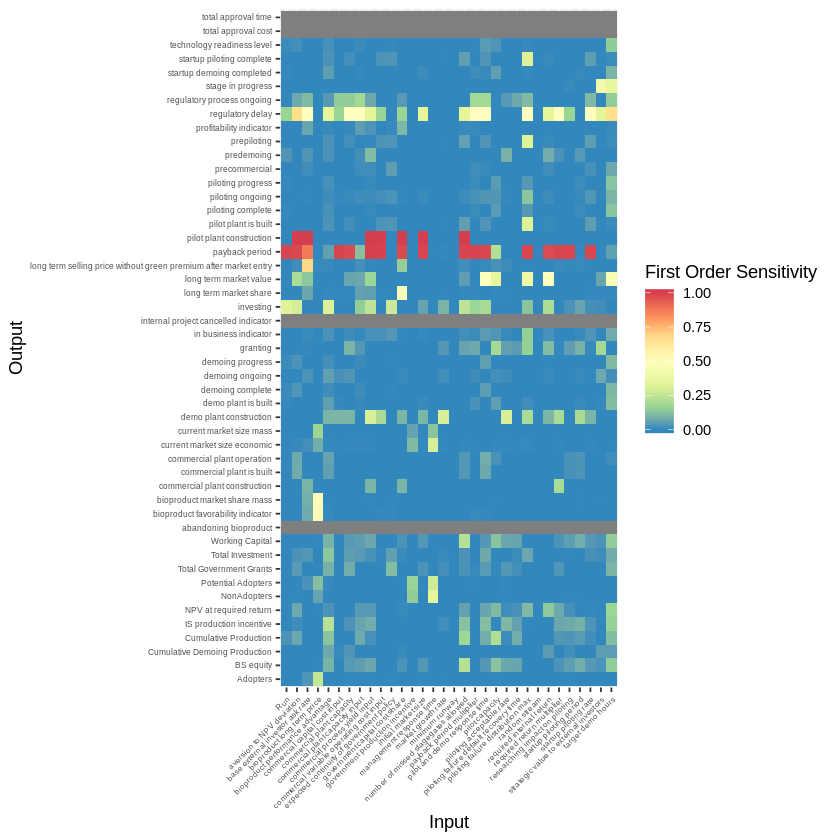

In [11]:
ggplot(
    z.sens[,
        .(Input, Output, `First Order Sensitivity`=mapply(function(x) max(0, min(1, x)), S))
    ],
    aes(x=Input, y=Output, fill=`First Order Sensitivity`)
) +
    geom_tile() +
    scale_fill_distiller(palette = "Spectral", limits=c(0, 1)) +
    theme(
        axis.text=element_text(size=5),
        axis.text.x = element_text(angle = 45, hjust=1)
    )

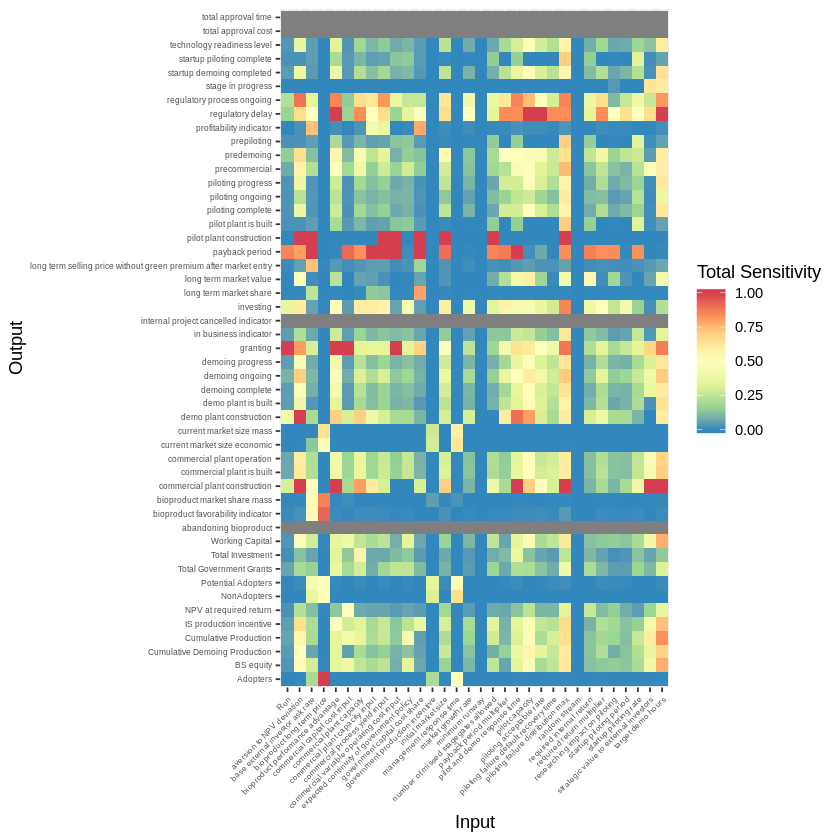

In [12]:
ggplot(
    z.sens[,
        .(Input, Output, `Total Sensitivity`=mapply(function(x) max(0, min(1, x)), T))
    ],
    aes(x=Input, y=Output, fill=`Total Sensitivity`)
) +
    geom_tile() +
    scale_fill_distiller(palette = "Spectral", limits=c(0, 1)) +
    theme(
        axis.text=element_text(size=5),
        axis.text.x = element_text(angle = 45, hjust=1)
    )

In [13]:
z.sens.boot <- sensitivityIndices(
    z.inputs,
    z.outputs[
        Replacement == "Advantaged" & Scale == "Niche" & Time == 2050
    ],
    300
)
z.sens.boot %>% dim

[1] 470400      4

In [14]:
z.sens.boot.summary <- z.sens.boot[, .(
    `S mean` = mean(S, na.rm=TRUE),
    `S s.d.` = sd  (S, na.rm=TRUE),
    `T mean` = mean(T, na.rm=TRUE),
    `T s.d.` = sd  (T, na.rm=TRUE)
), by=.(Input, Output)][
    Input != "Run", .(
    Input,
    Output,
    `S mean`,
    `S s.d.`,
    `S ratio` = abs(`S mean`) / `S s.d.`,
    `T mean`,
    `T s.d.`,
    `T ratio` = abs(`T mean`) / `T s.d.`
)]

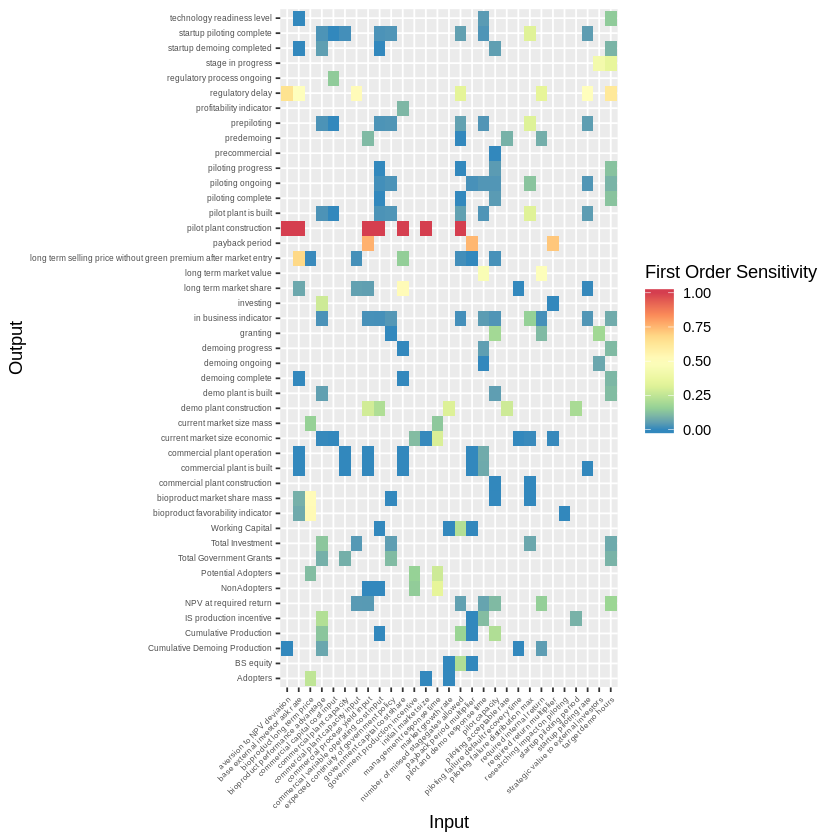

In [15]:
ggplot(
    z.sens.boot.summary[
        `S ratio` >= 1.5,
        .(Input, Output, `First Order Sensitivity`=mapply(function(x) max(0, min(1, x)), `S mean`))
    ],
    aes(x=Input, y=Output, fill=`First Order Sensitivity`)
) +
    geom_tile() +
    scale_fill_distiller(palette = "Spectral", limits=c(0, 1)) +
    theme(
        axis.text=element_text(size=5),
        axis.text.x = element_text(angle = 45, hjust=1)
    )

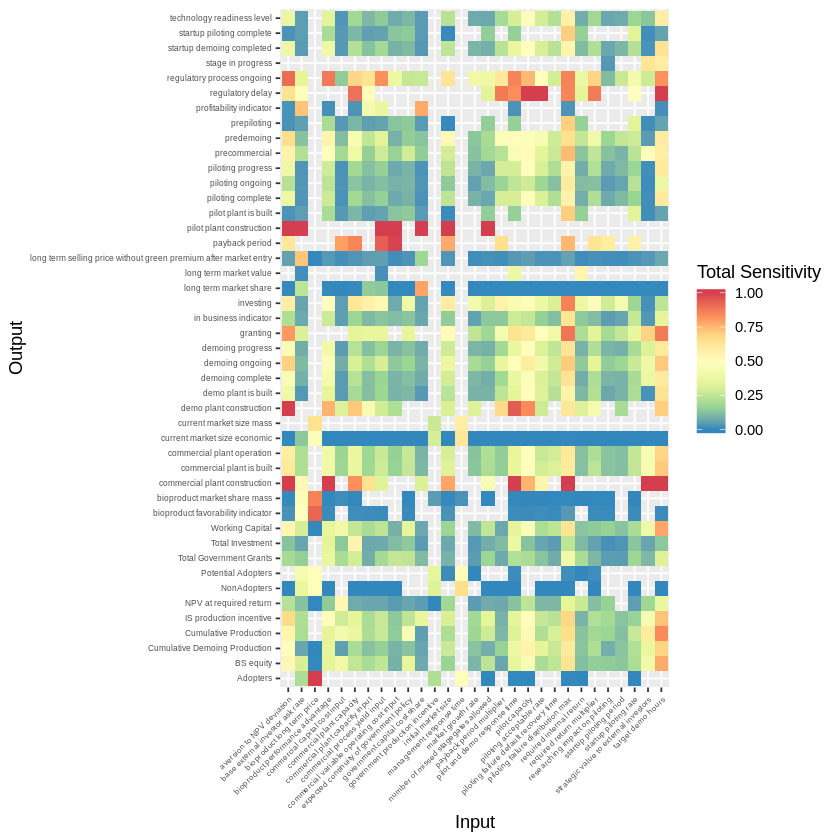

In [16]:
ggplot(
    z.sens.boot.summary[
        `T ratio` >= 1.5,
        .(Input, Output, `Total Sensitivity`=mapply(function(x) max(0, min(1, x)), `T mean`))
    ],
    aes(x=Input, y=Output, fill=`Total Sensitivity`)
) +
    geom_tile() +
    scale_fill_distiller(palette = "Spectral", limits=c(0, 1)) +
    theme(
        axis.text=element_text(size=5),
        axis.text.x = element_text(angle = 45, hjust=1)
    )

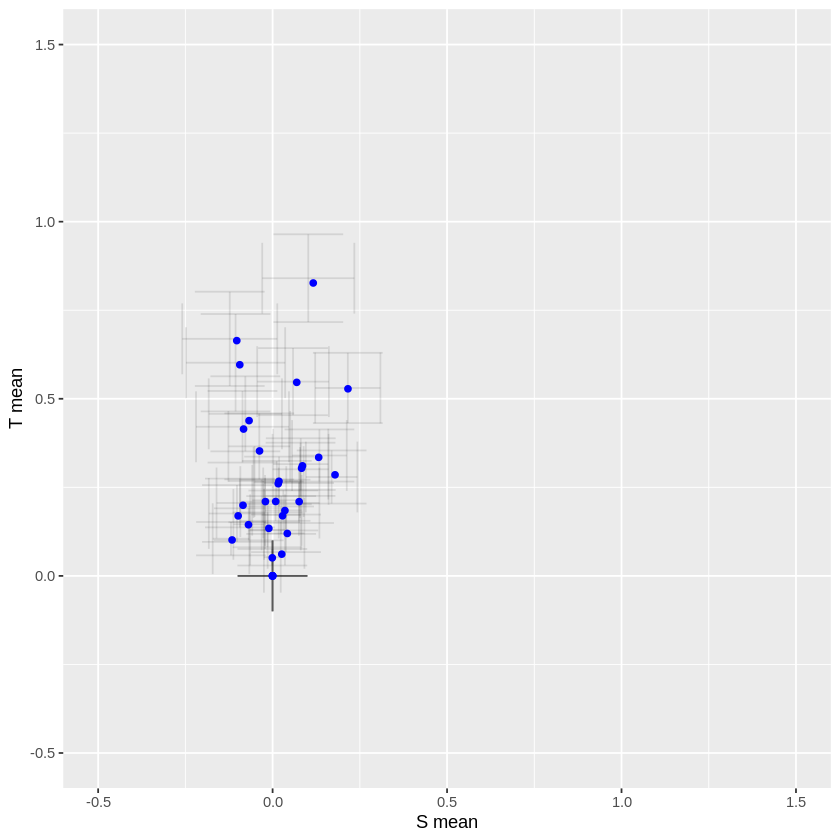

In [20]:
ggplot(
    z.sens.boot.summary[Output == "Cumulative Production"],
    aes(x=`S mean`, y=`T mean`)
) +
xlim(-0.5, 1.5) +
ylim(-0.5, 1.5) +
geom_errorbarh(
    aes(
        xmin=`S mean`-`S s.d.`,
        xmax=`S mean`+`S s.d.`,
    ),
    alpha = 0.1,
    height=0.2
) +
geom_errorbar(
    aes(
        ymin=`T mean`-`T s.d.`,
        ymax=`T mean`+`T s.d.`
    ),
    alpha = 0.1,
    width=0.2
) +
geom_point(data = z.sens[Output == "Cumulative Production"], aes(x=S, y=T), color="blue")

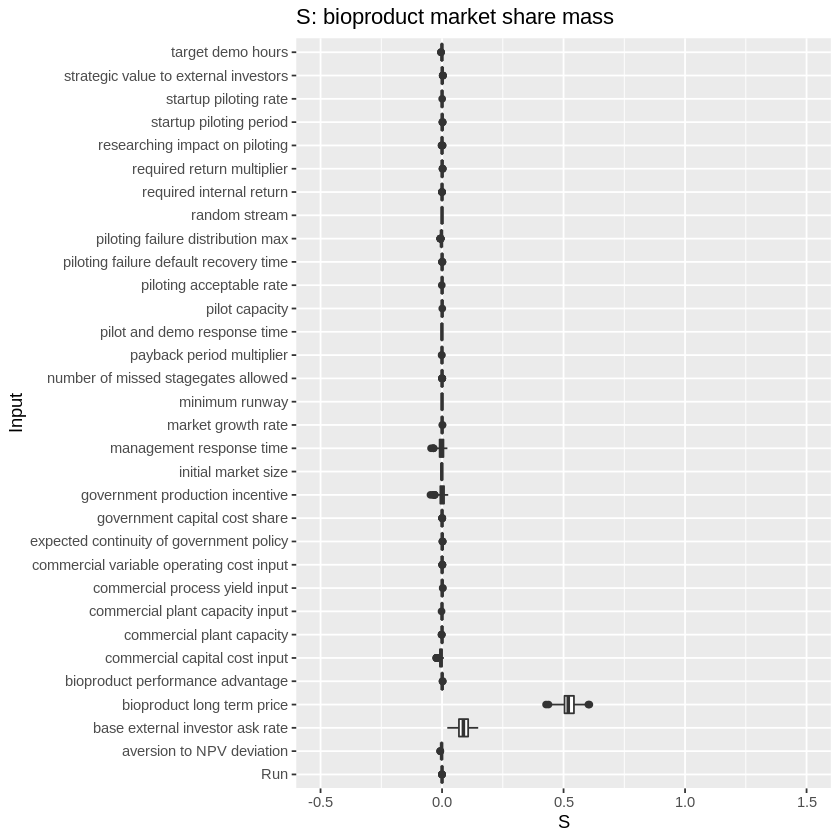

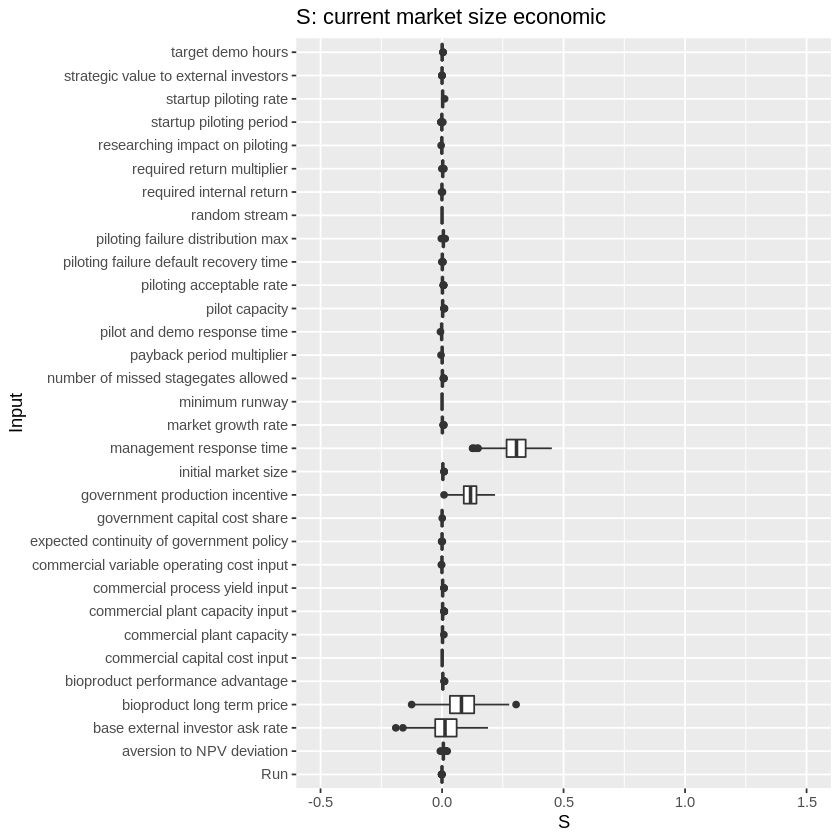

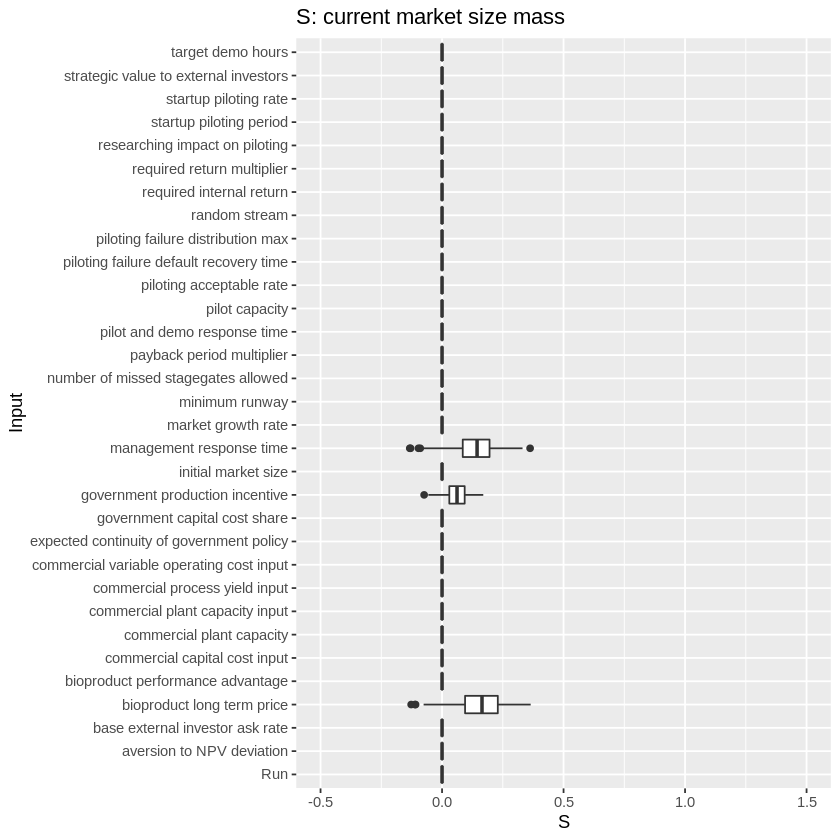

Warning message:
"Removed 294 rows containing non-finite values (stat_boxplot)."

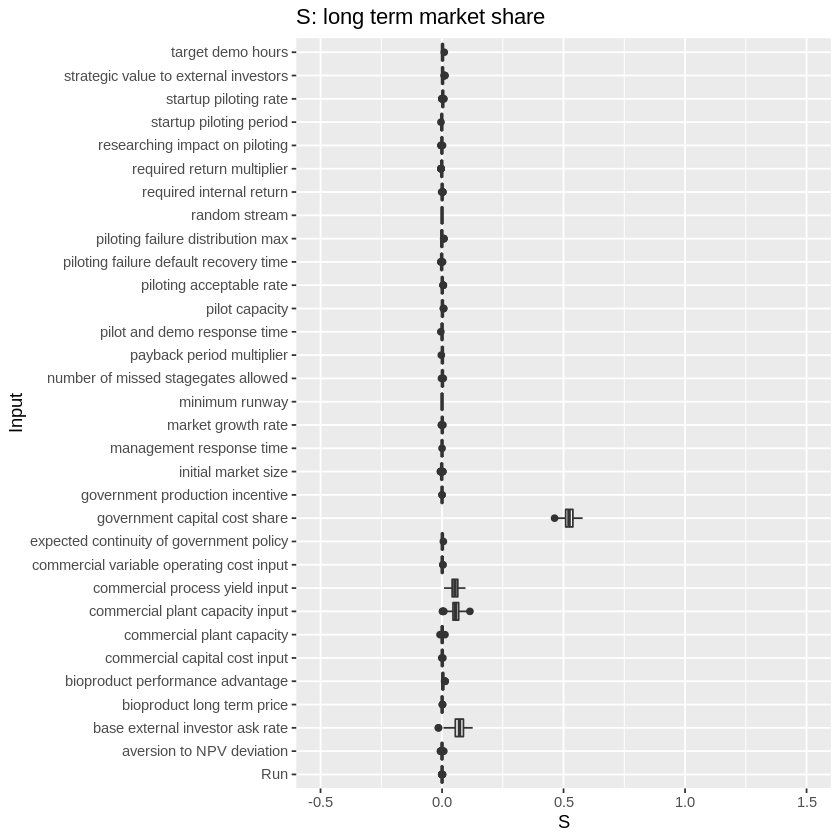

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."

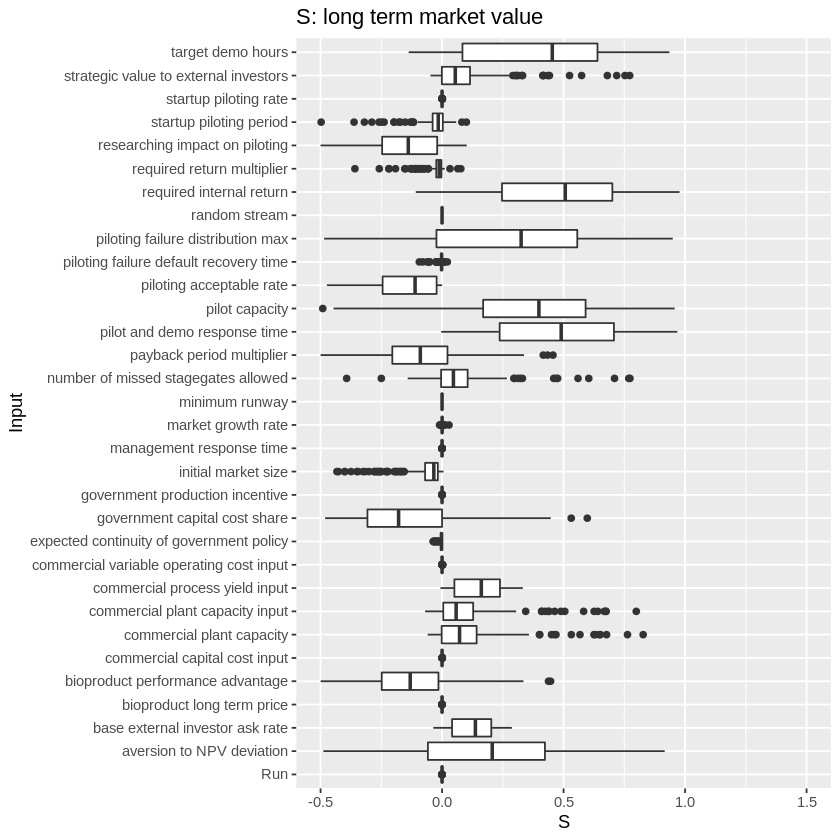

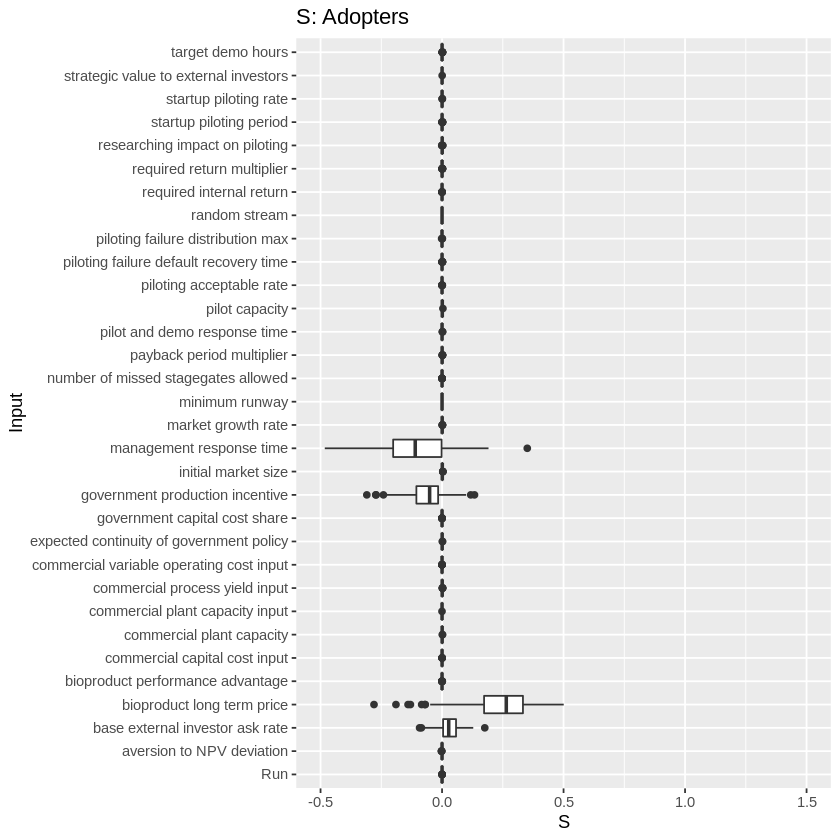

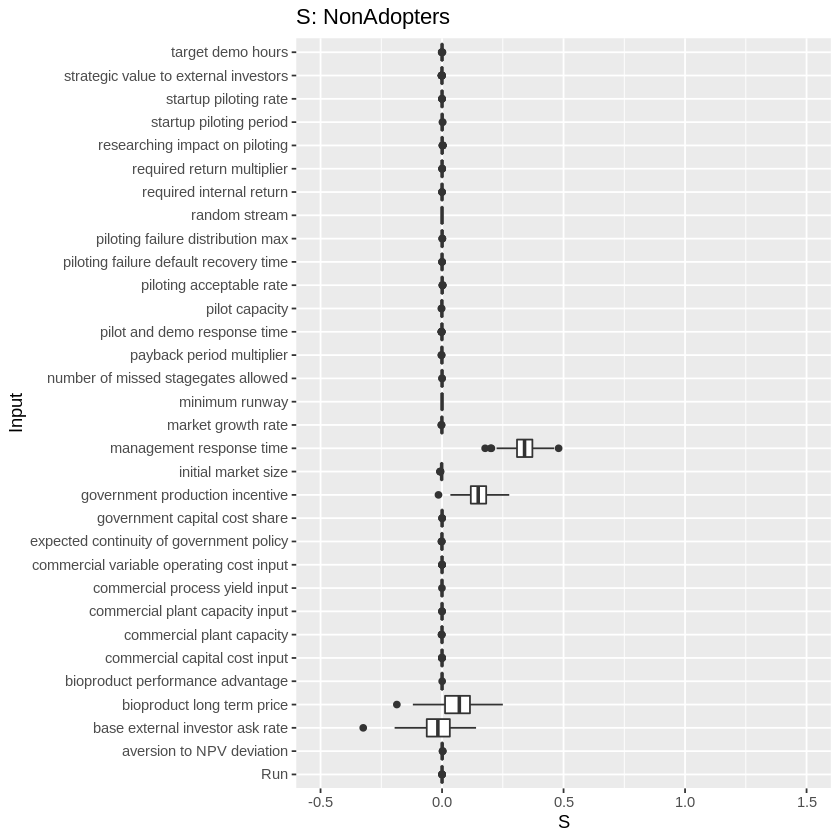

Warning message:
"Removed 9600 rows containing non-finite values (stat_boxplot)."

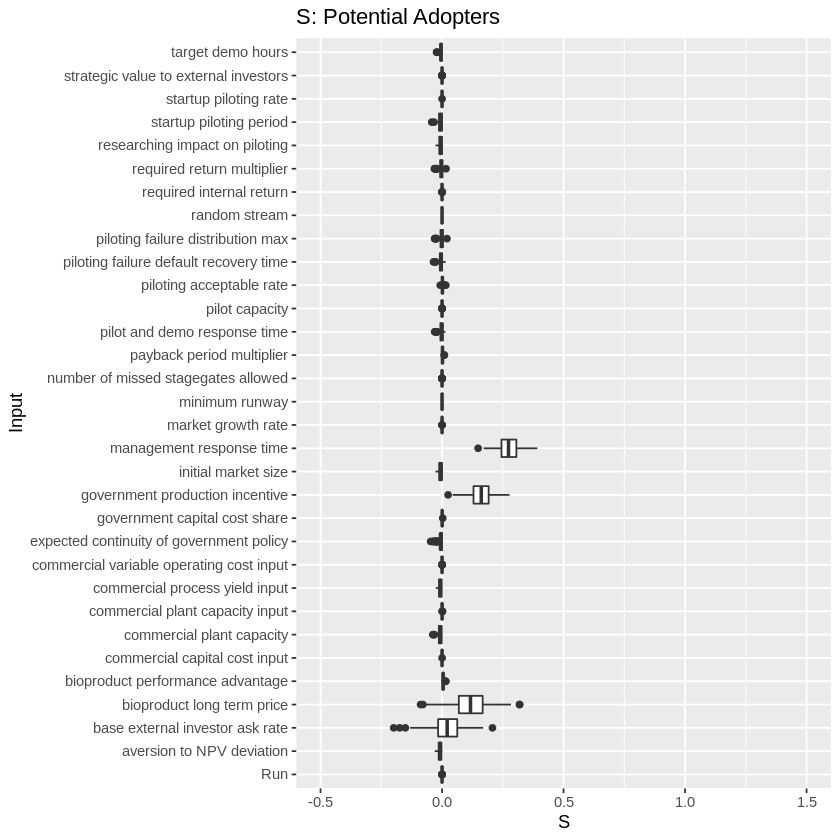

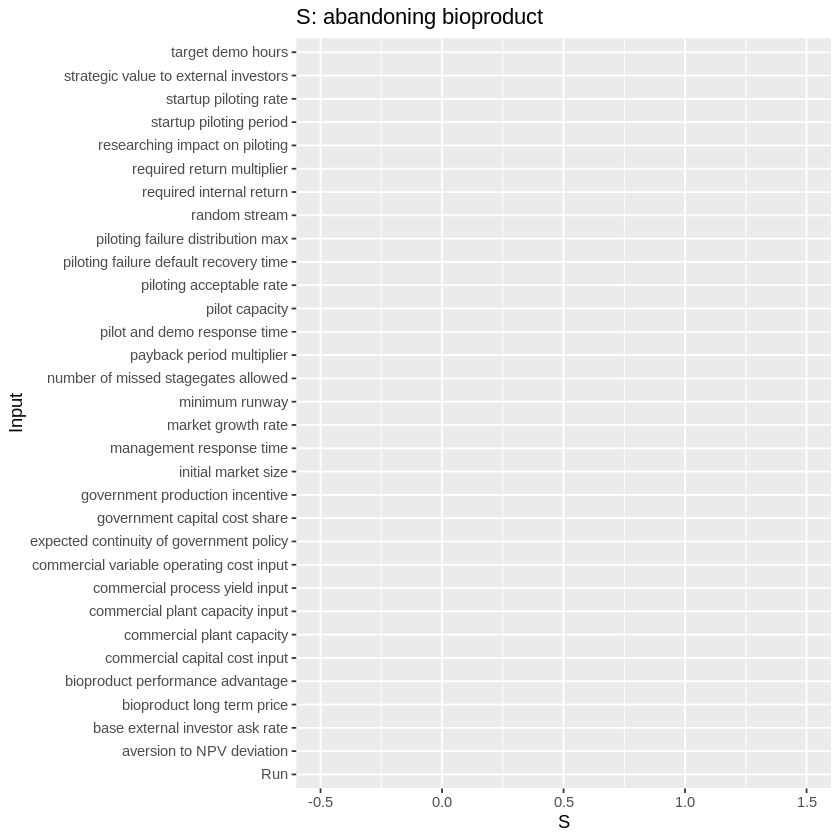

Warning message:
"Removed 10 rows containing non-finite values (stat_boxplot)."

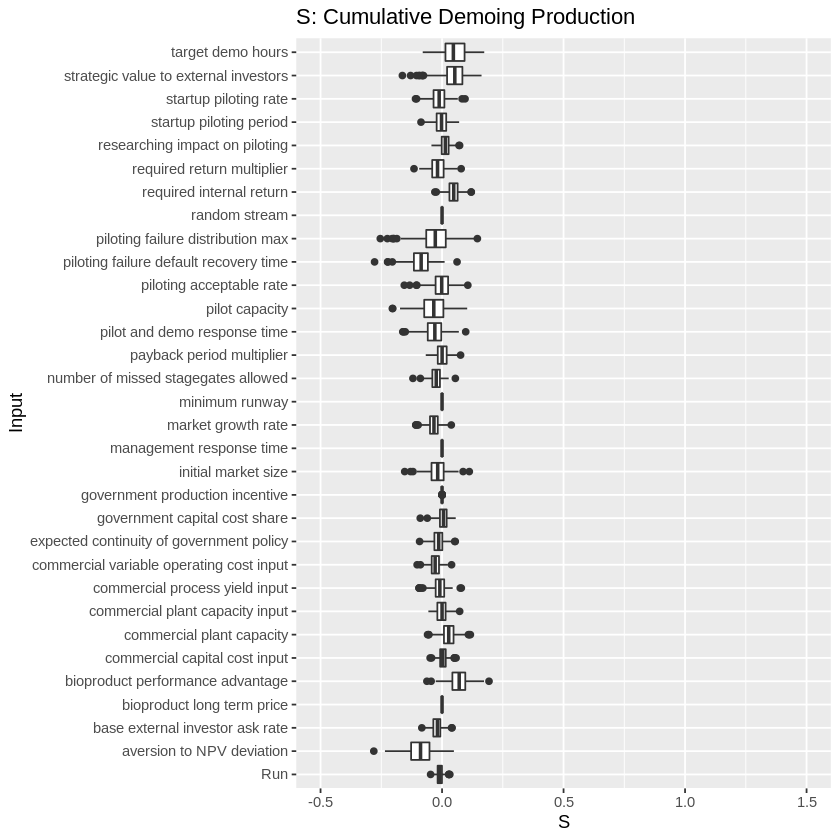

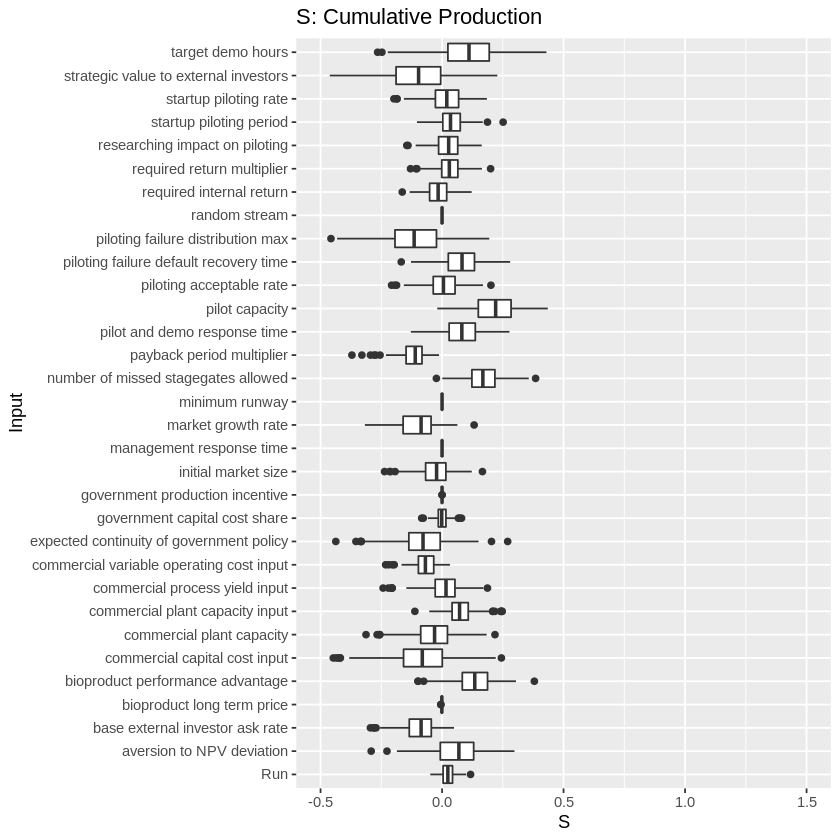

Warning message:
"Removed 3587 rows containing non-finite values (stat_boxplot)."

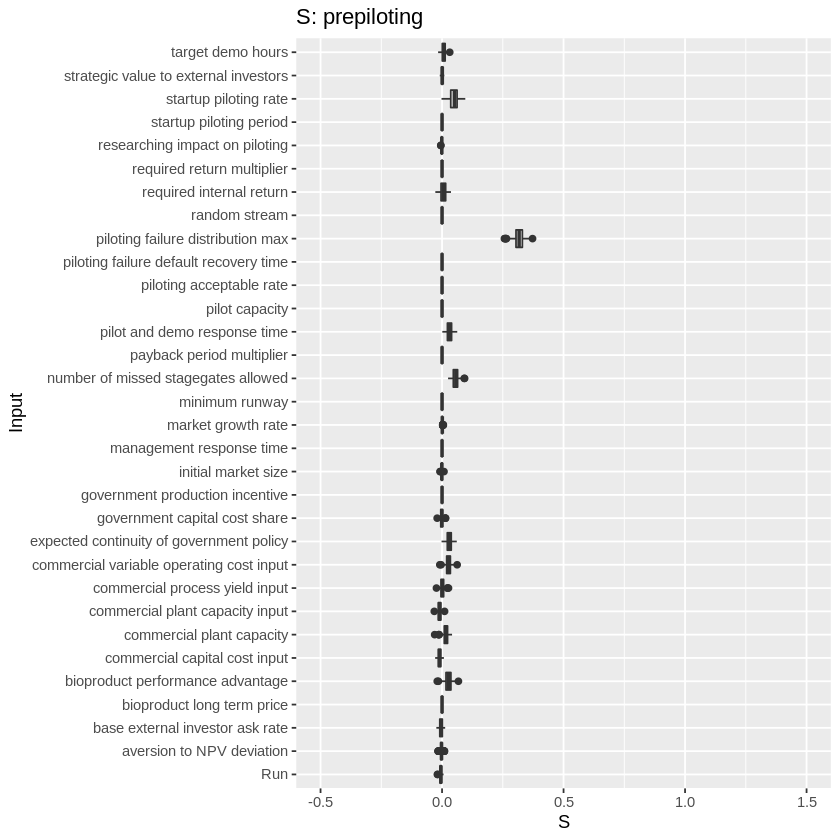

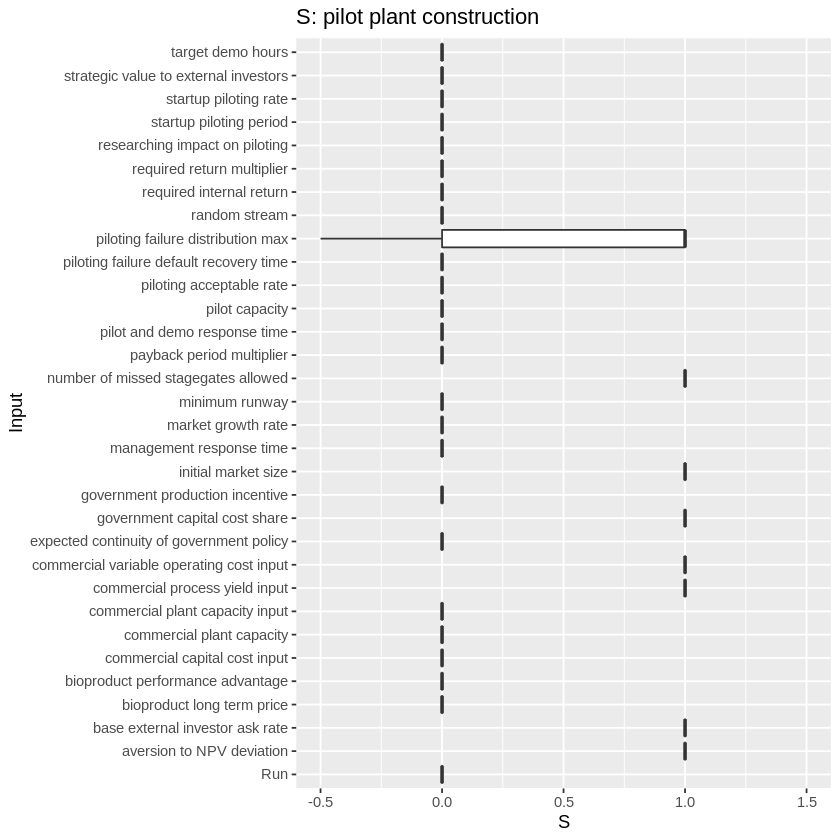

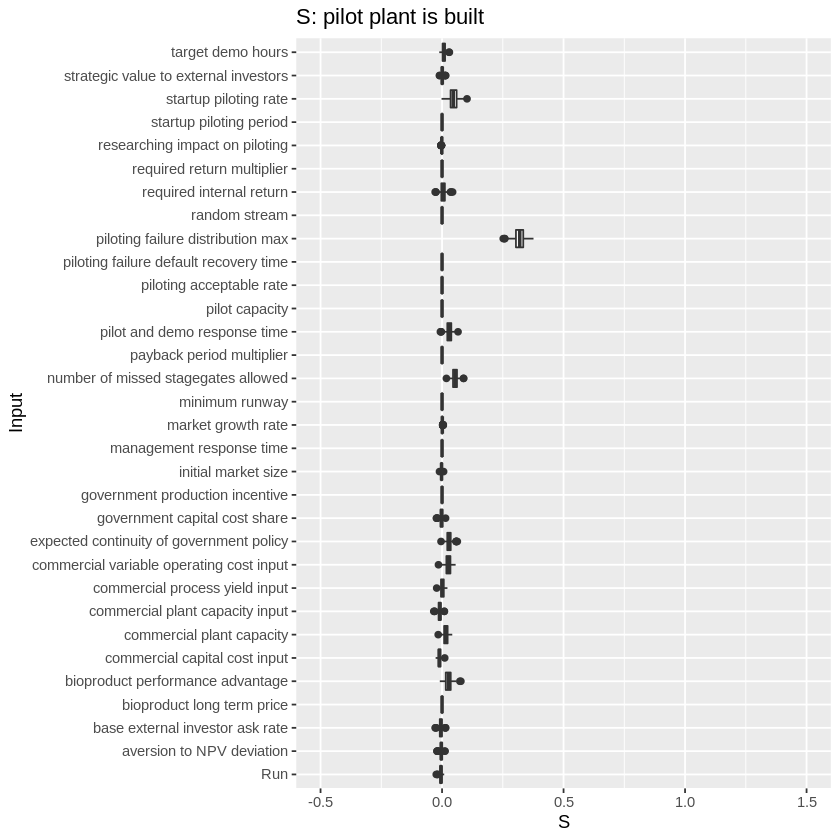

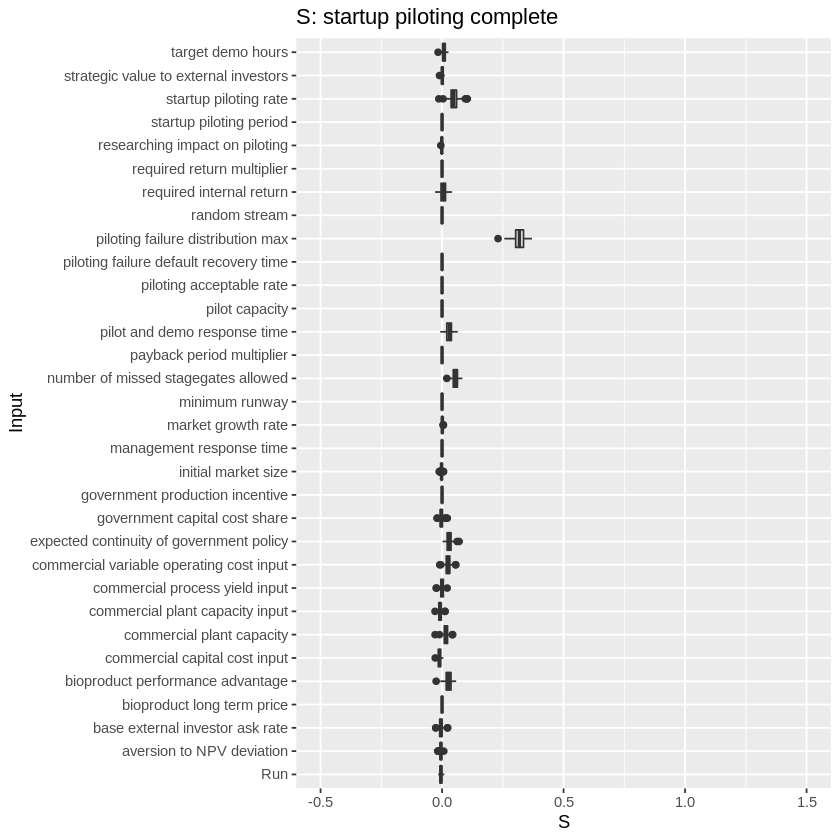

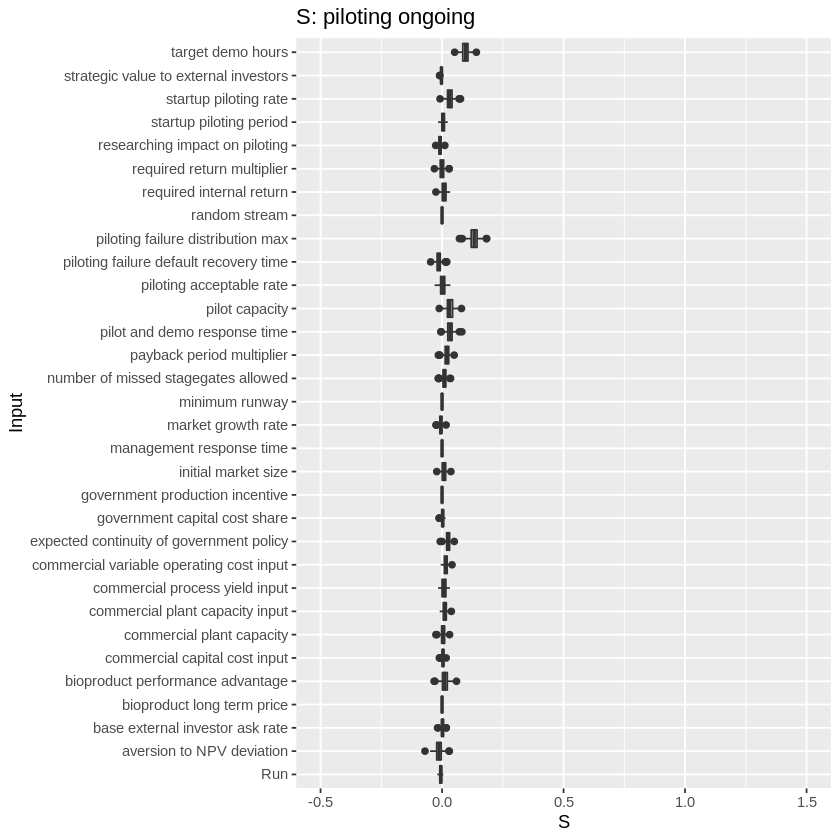

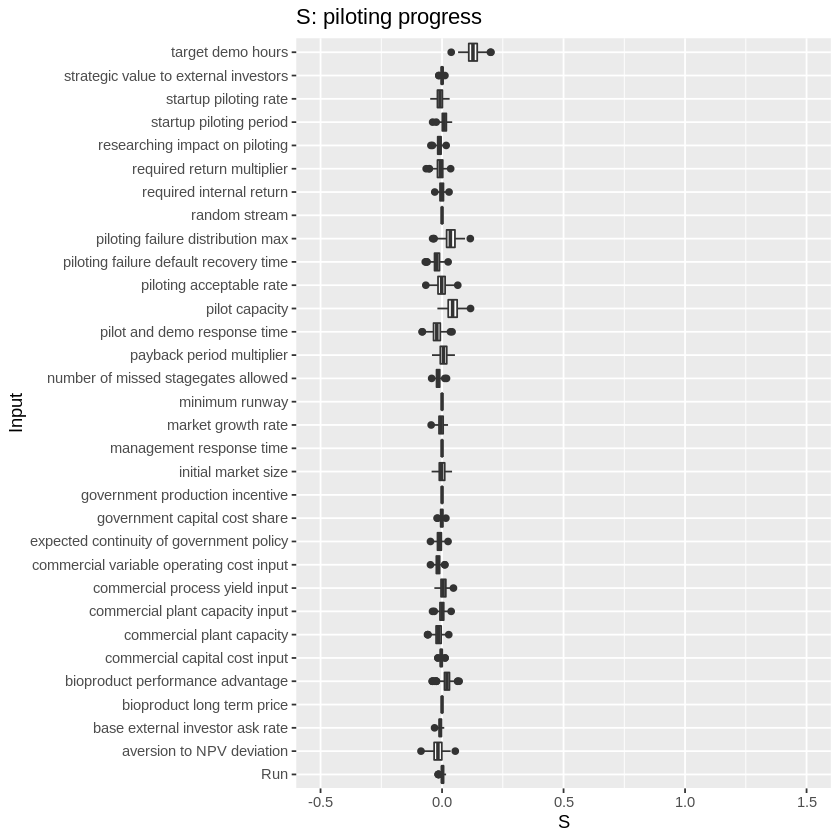

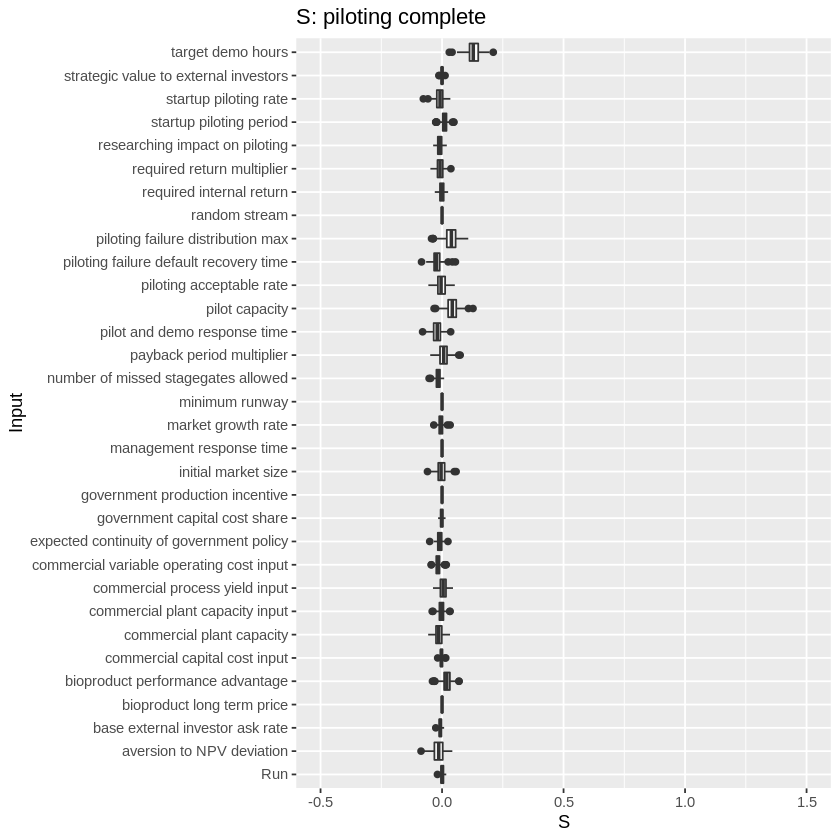

Warning message:
"Removed 498 rows containing non-finite values (stat_boxplot)."

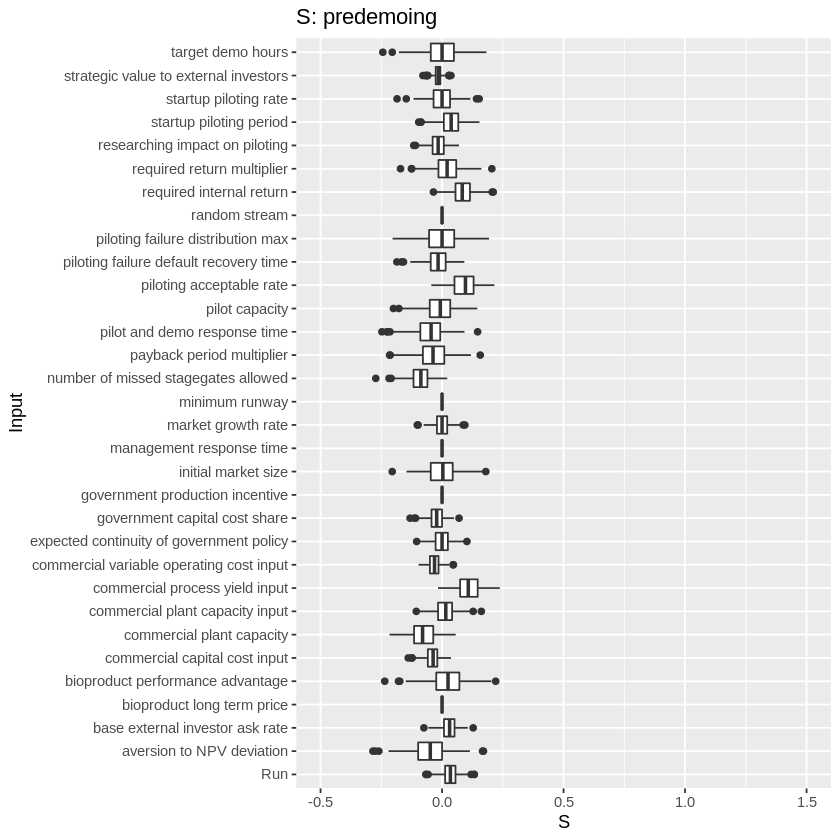

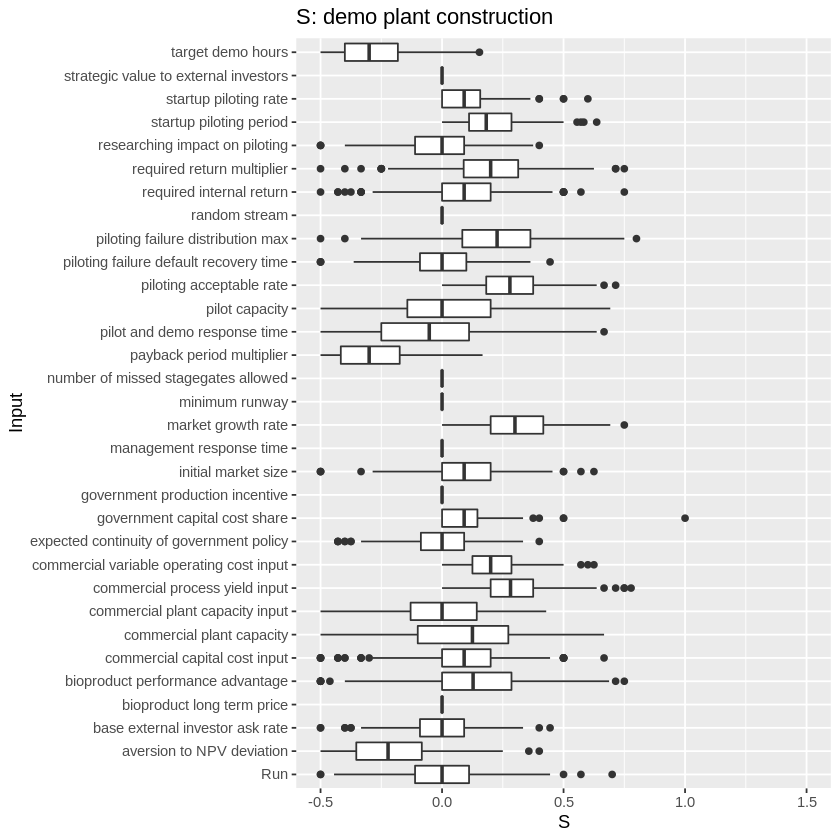

Warning message:
"Removed 20 rows containing non-finite values (stat_boxplot)."

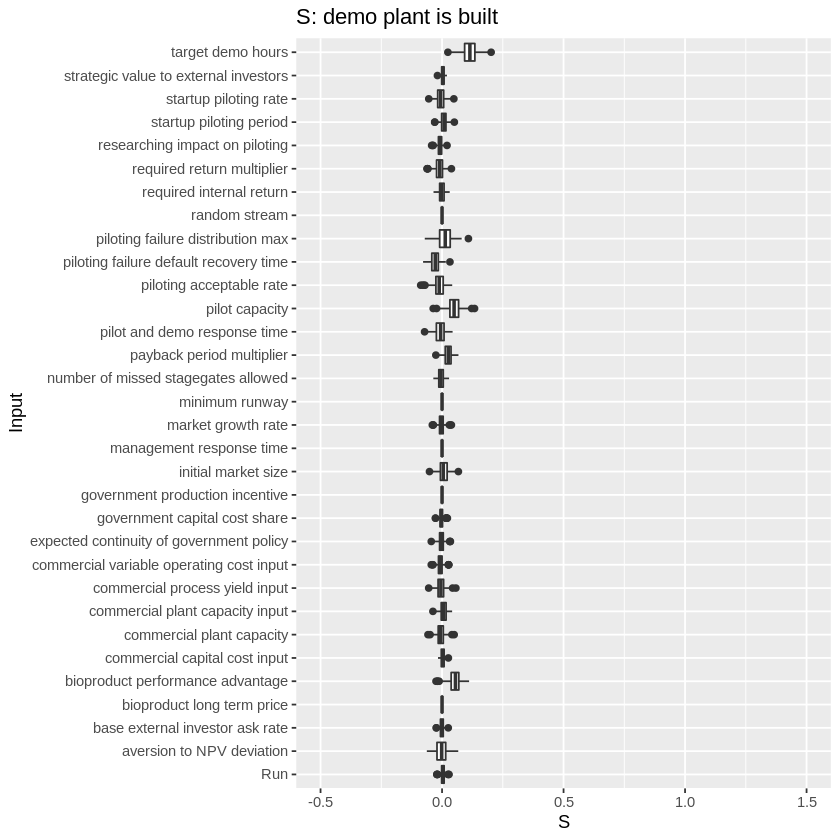

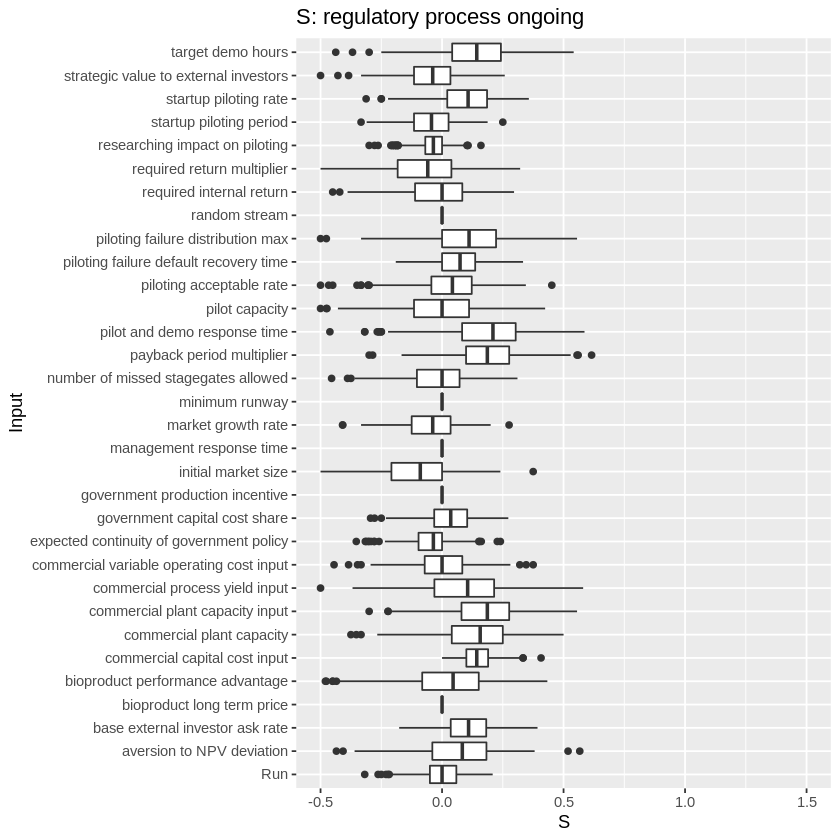

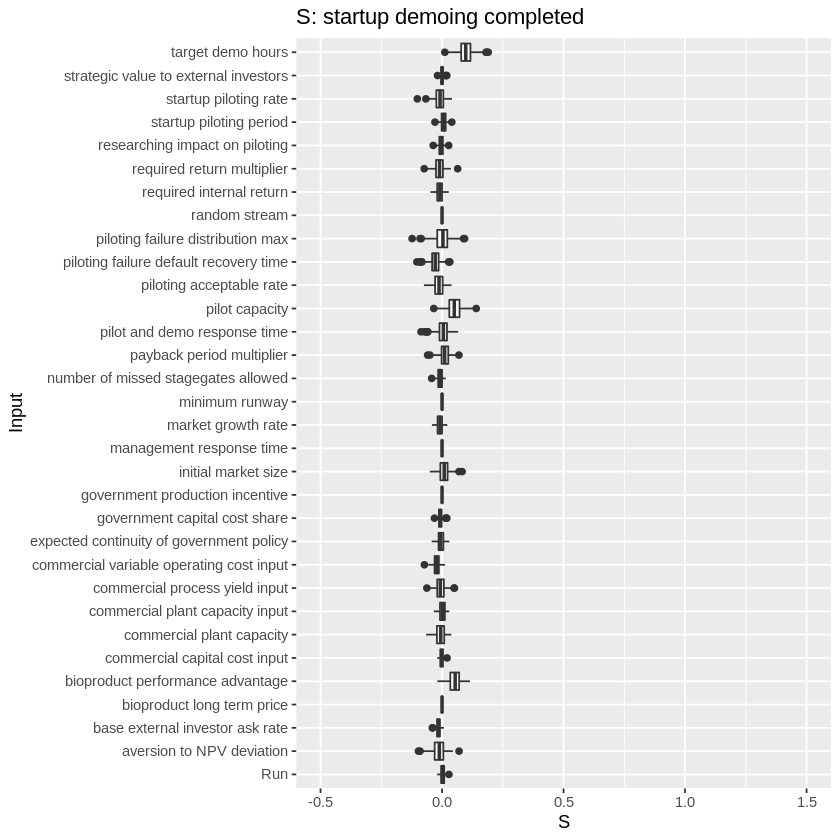

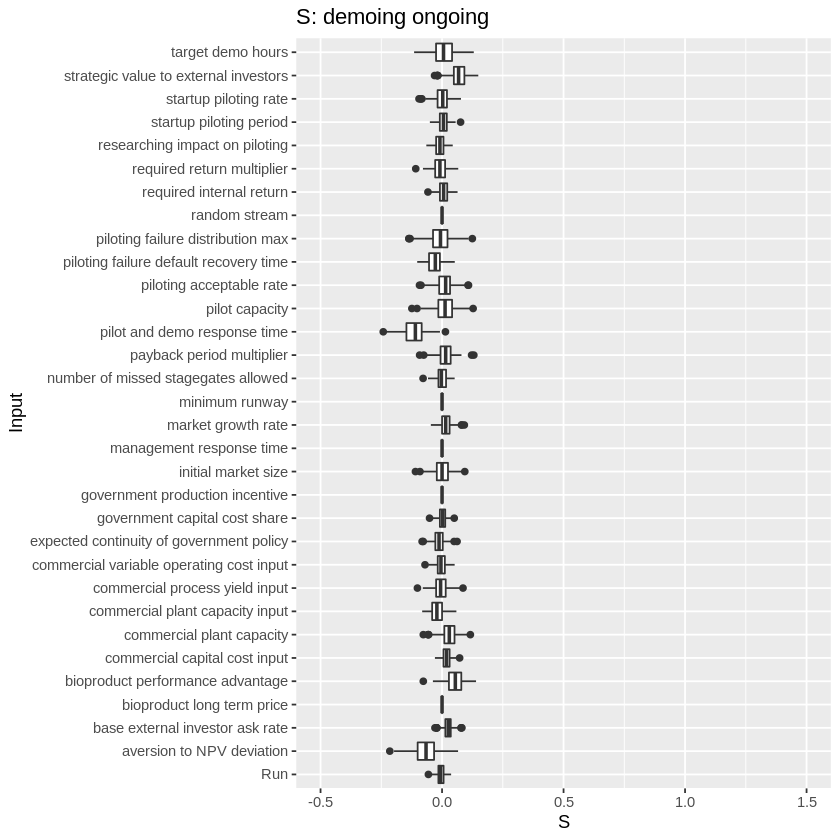

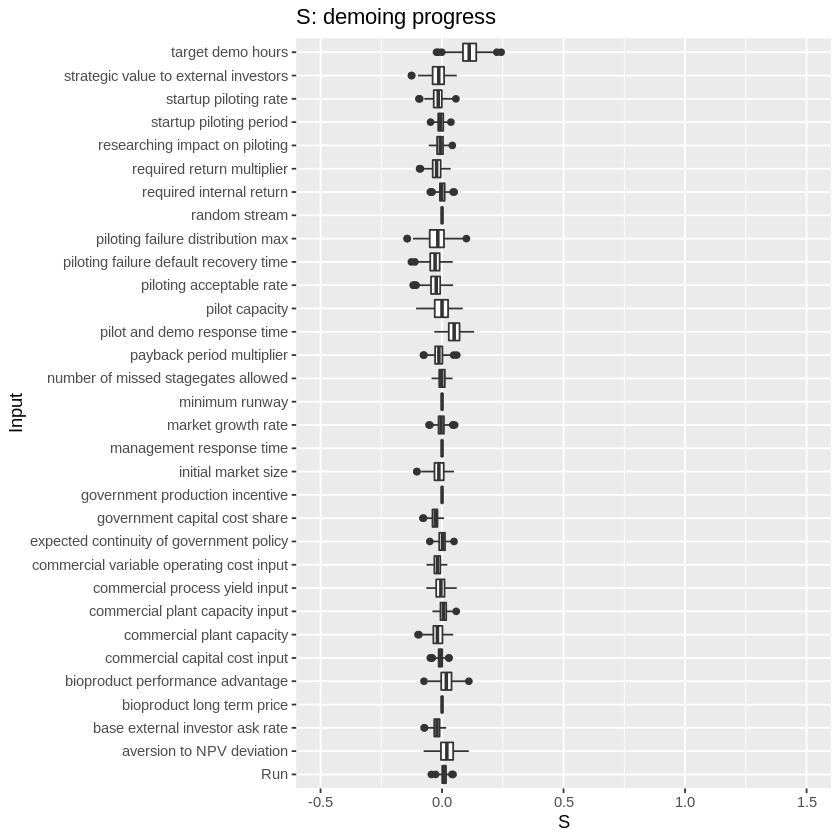

Warning message:
"Removed 508 rows containing non-finite values (stat_boxplot)."

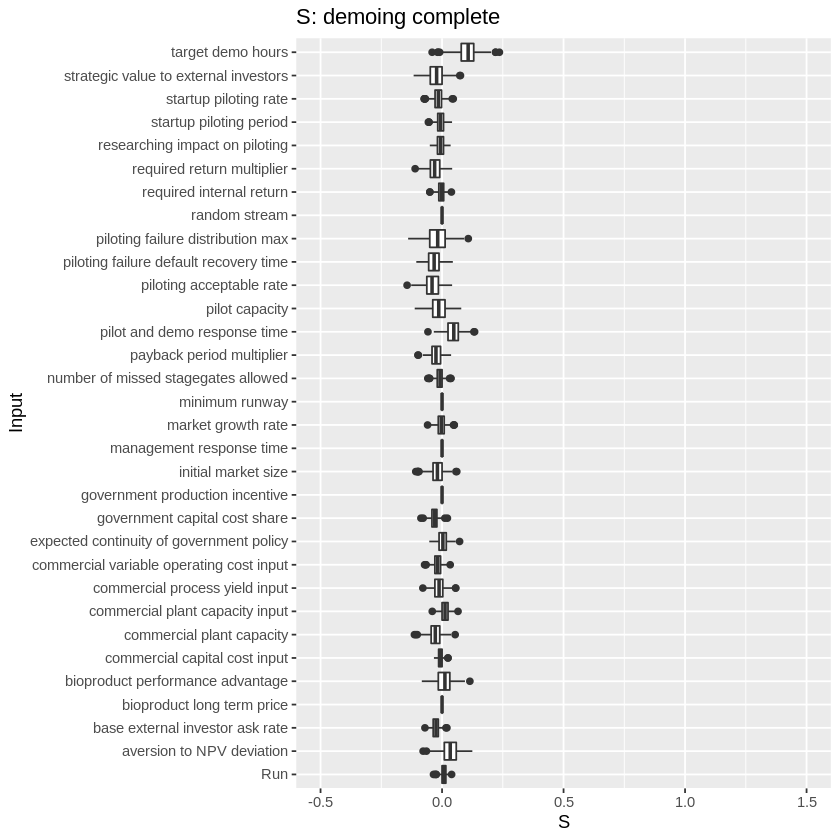

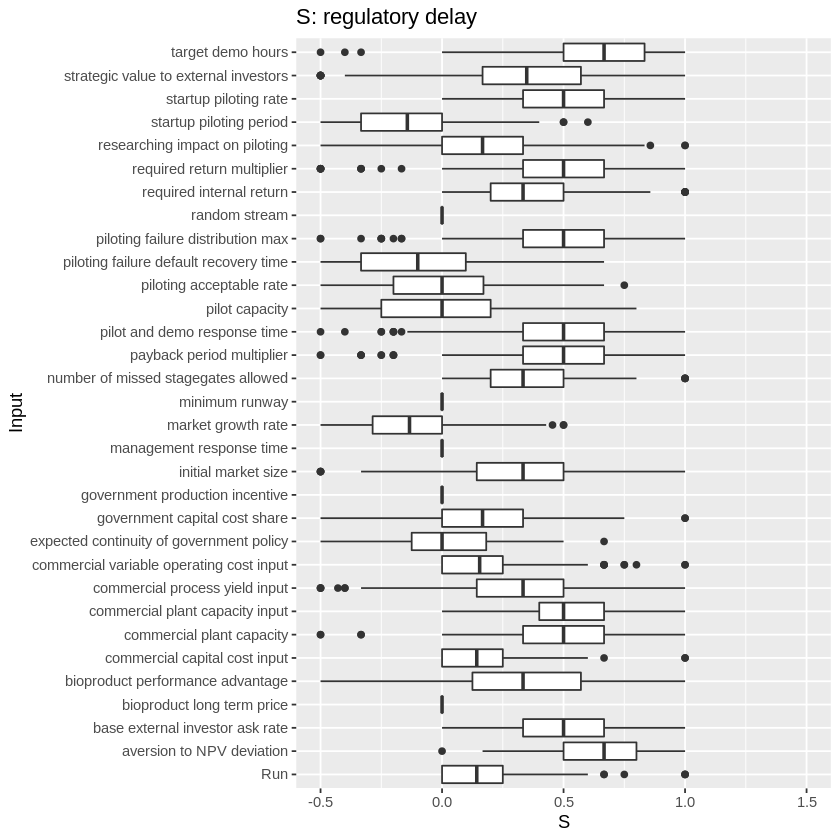

Warning message:
"Removed 1364 rows containing non-finite values (stat_boxplot)."

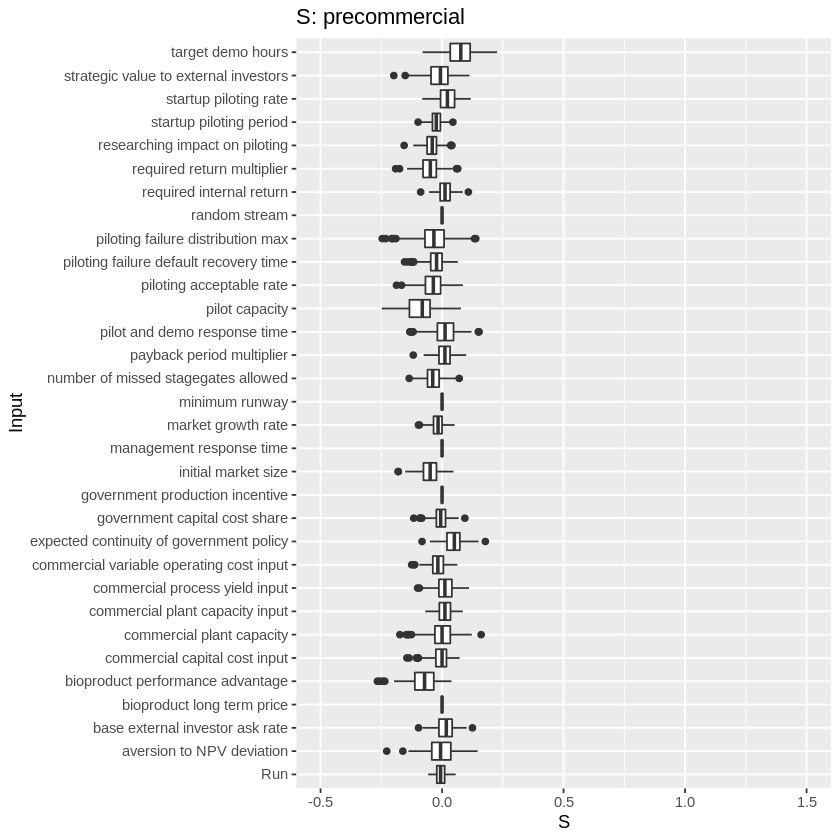

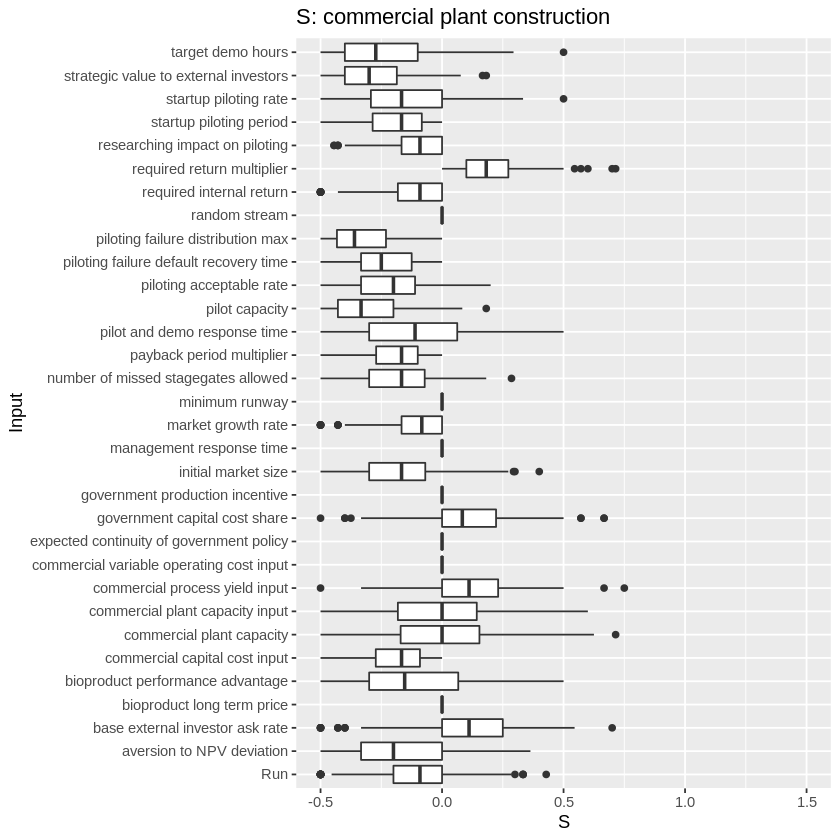

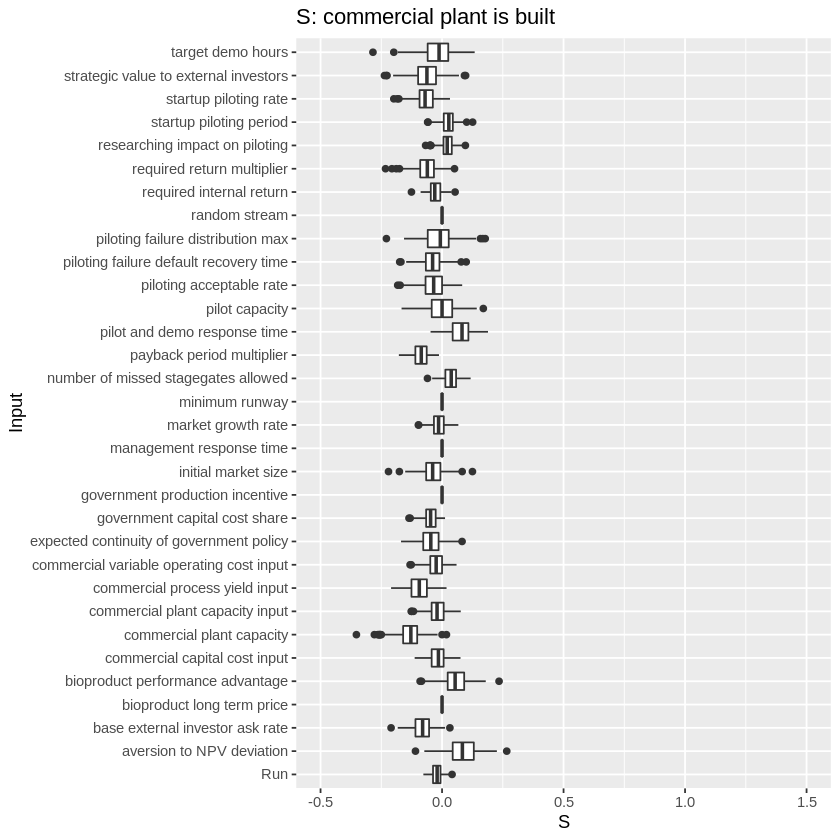

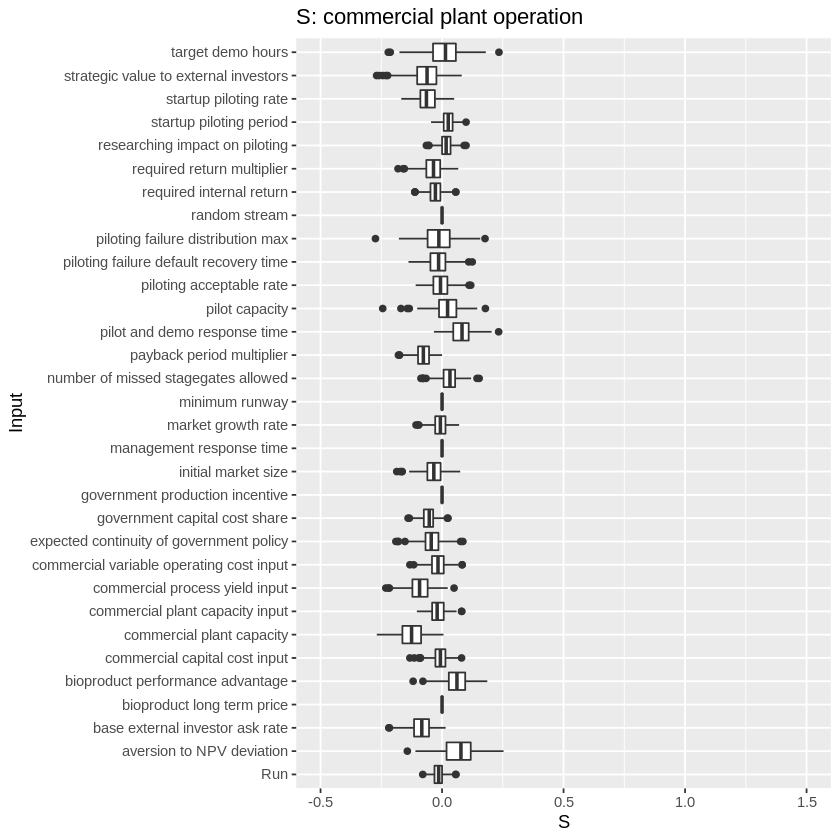

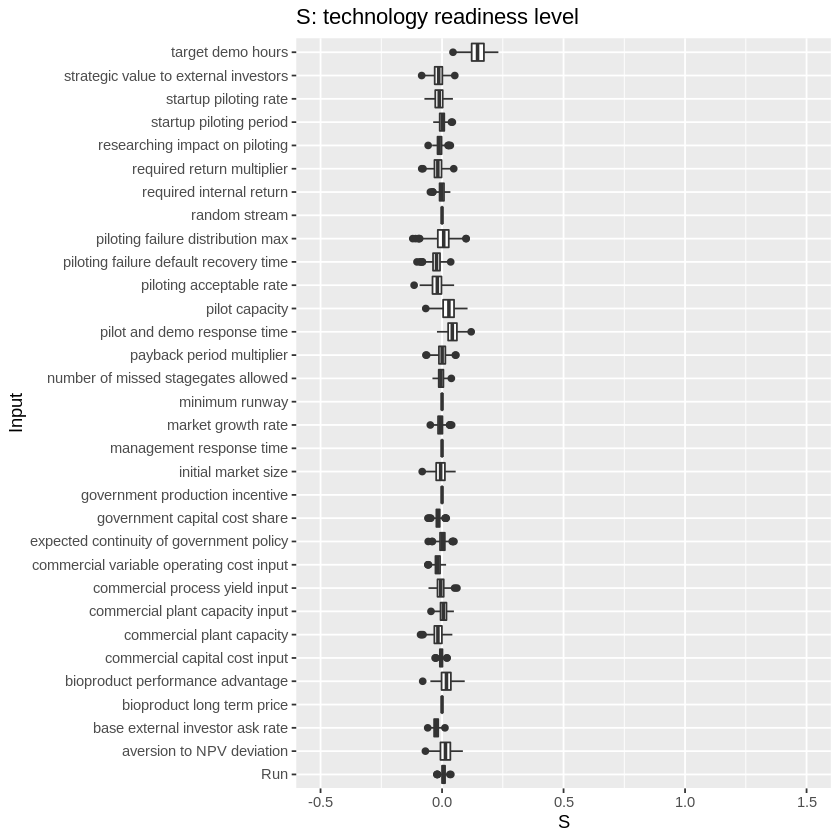

Warning message:
"Removed 24 rows containing non-finite values (stat_boxplot)."

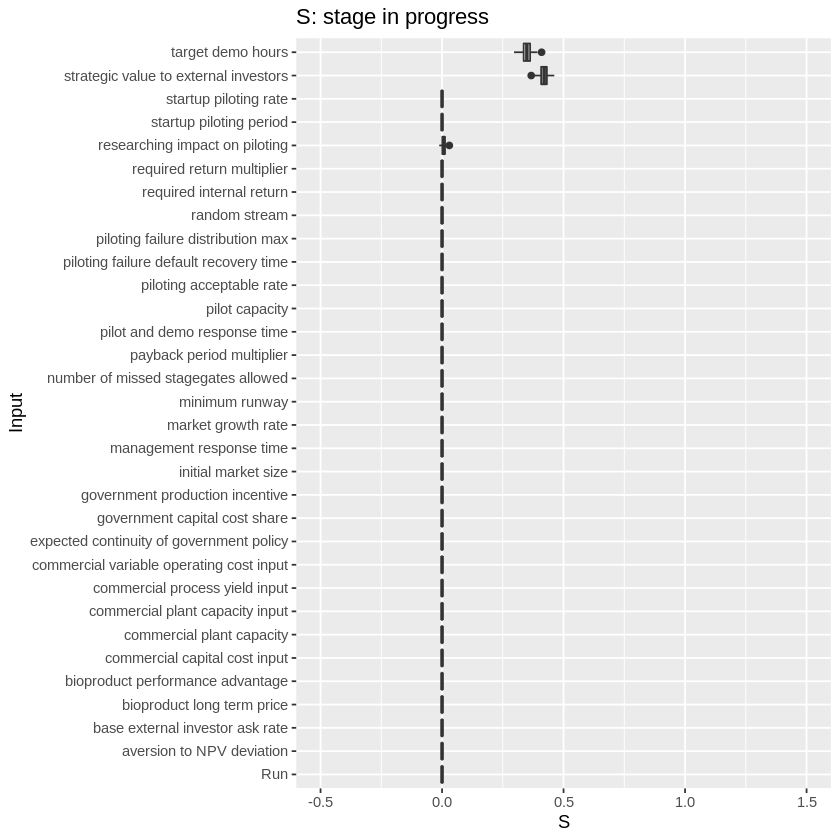

Warning message:
"Removed 745 rows containing non-finite values (stat_boxplot)."

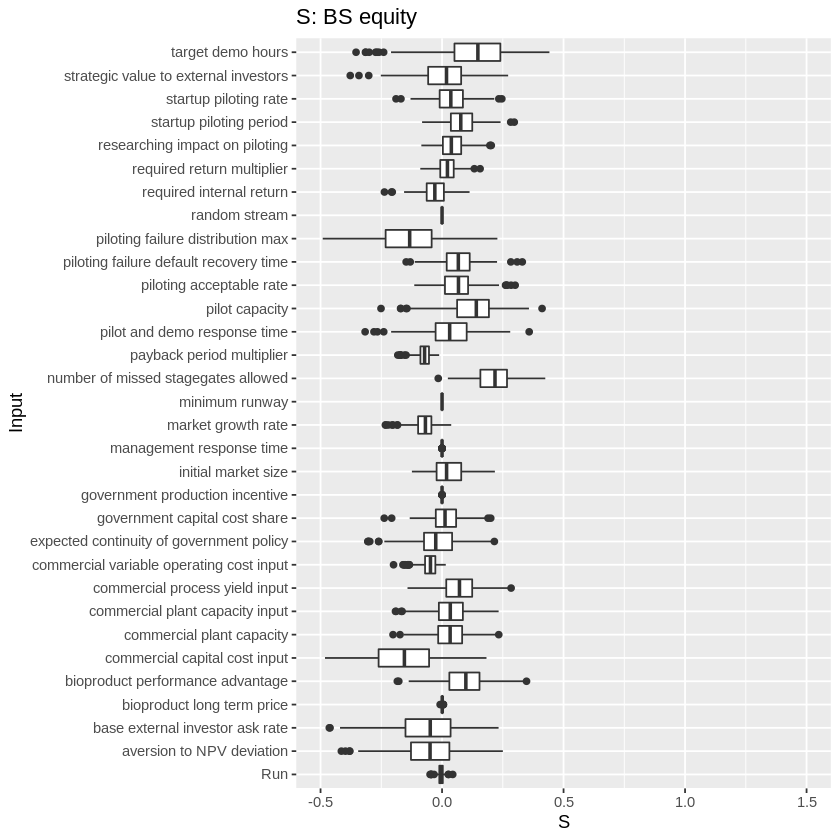

Warning message:
"Removed 109 rows containing non-finite values (stat_boxplot)."

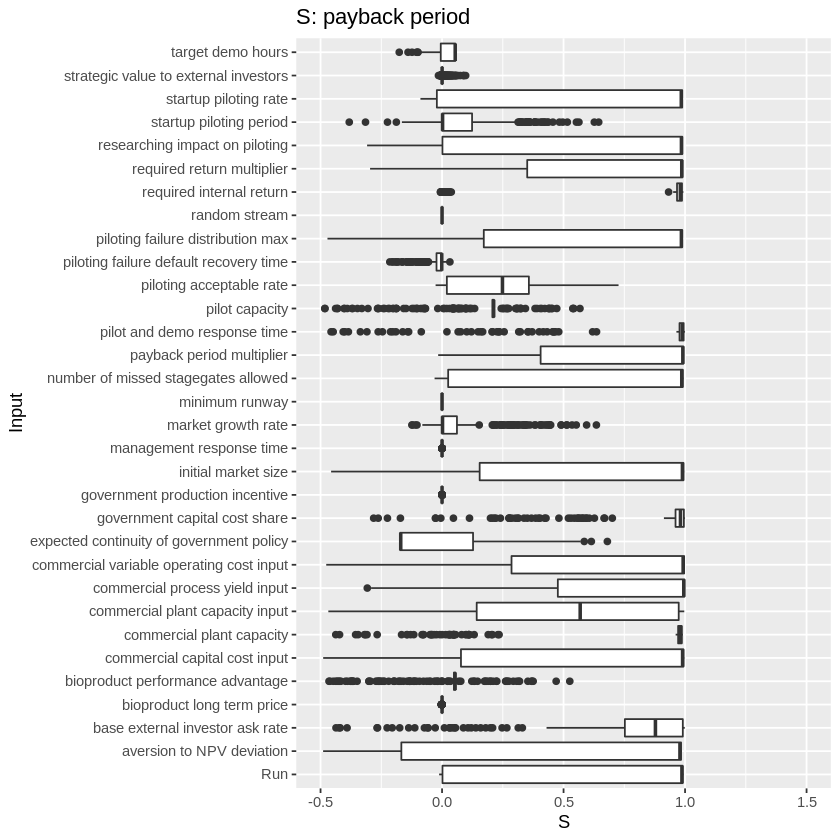

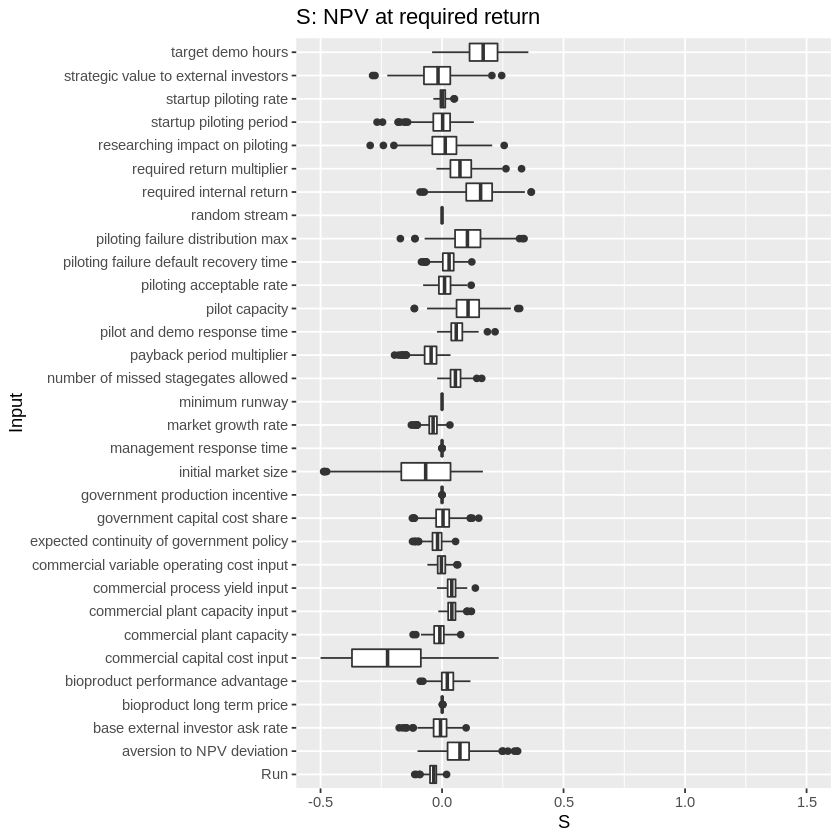

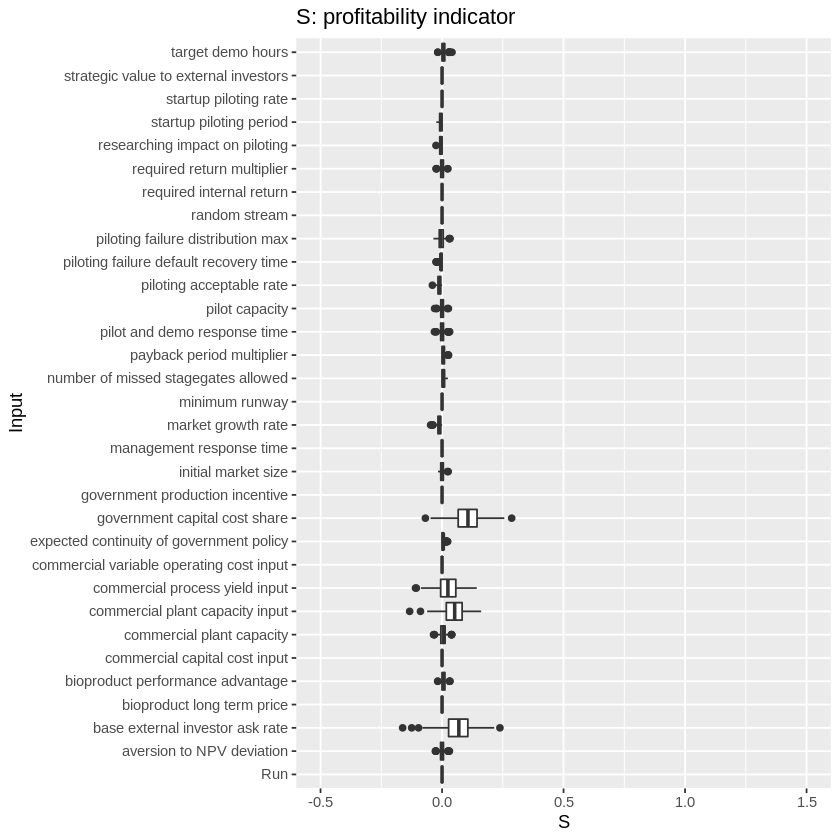

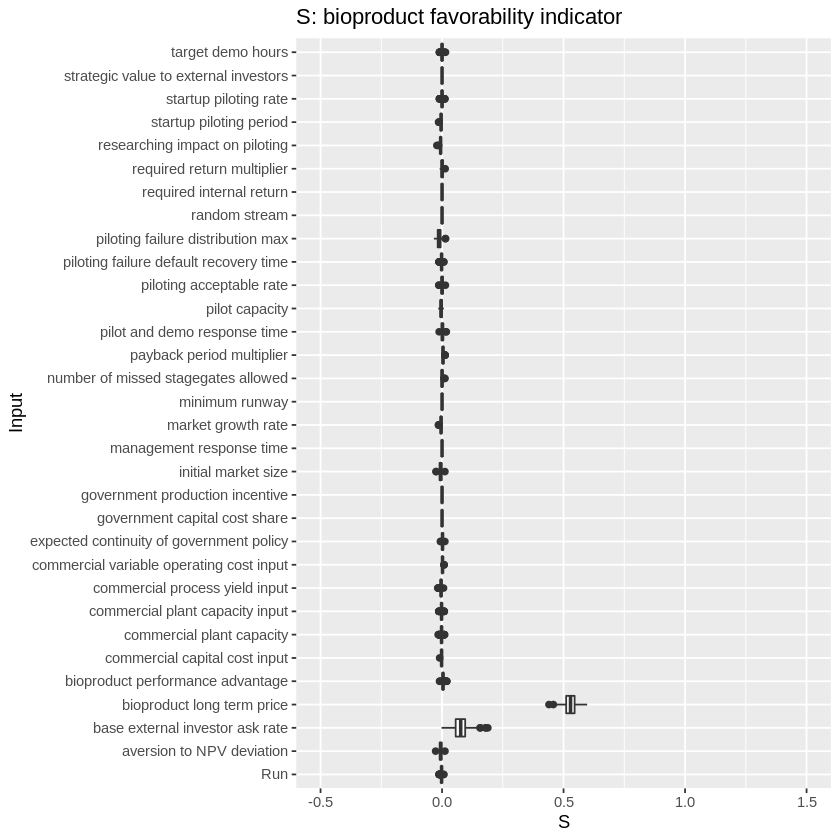

Warning message:
"Removed 9600 rows containing non-finite values (stat_boxplot)."

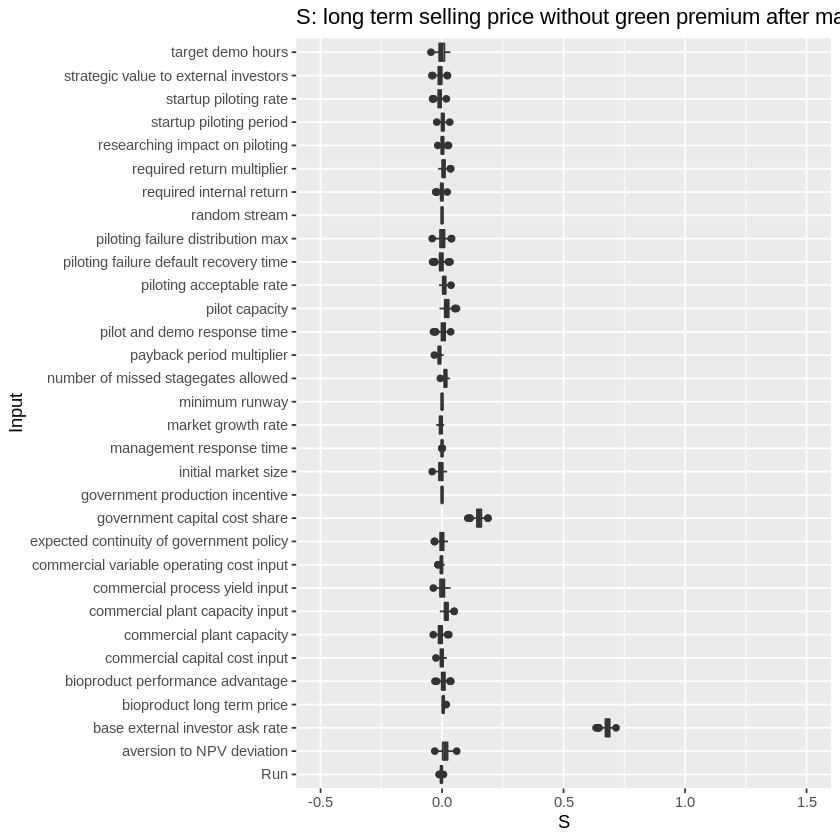

Warning message:
"Removed 9600 rows containing non-finite values (stat_boxplot)."

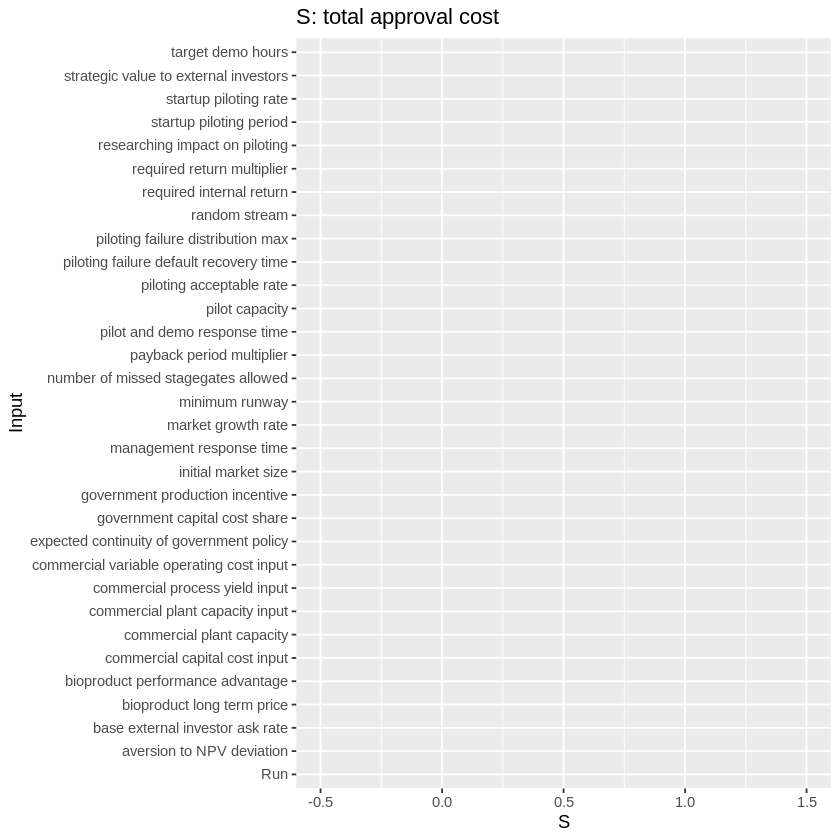

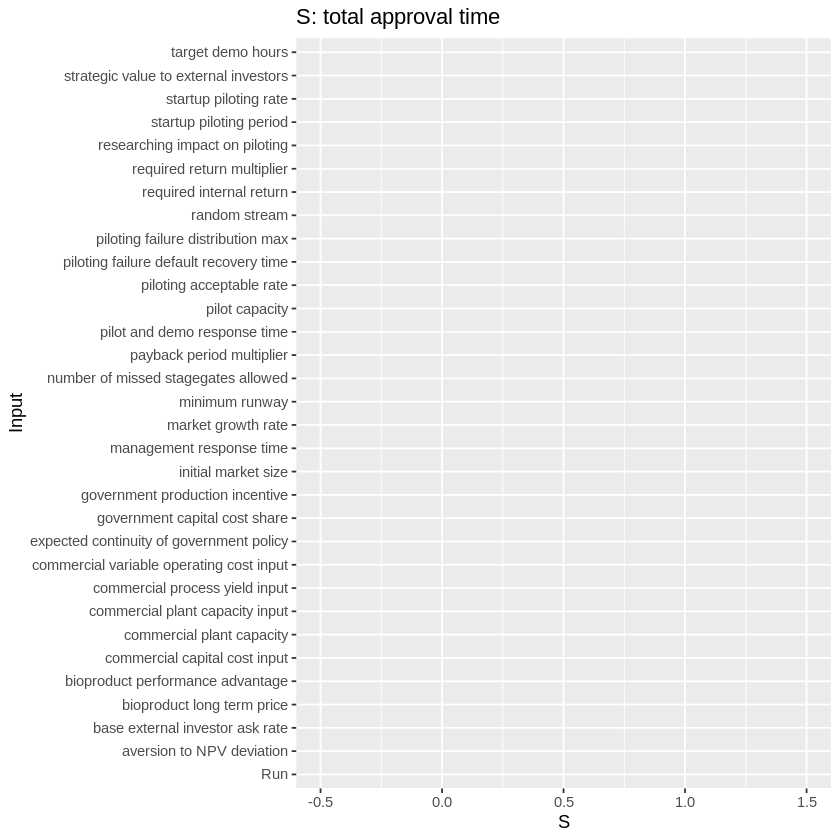

Warning message:
"Removed 9600 rows containing non-finite values (stat_boxplot)."

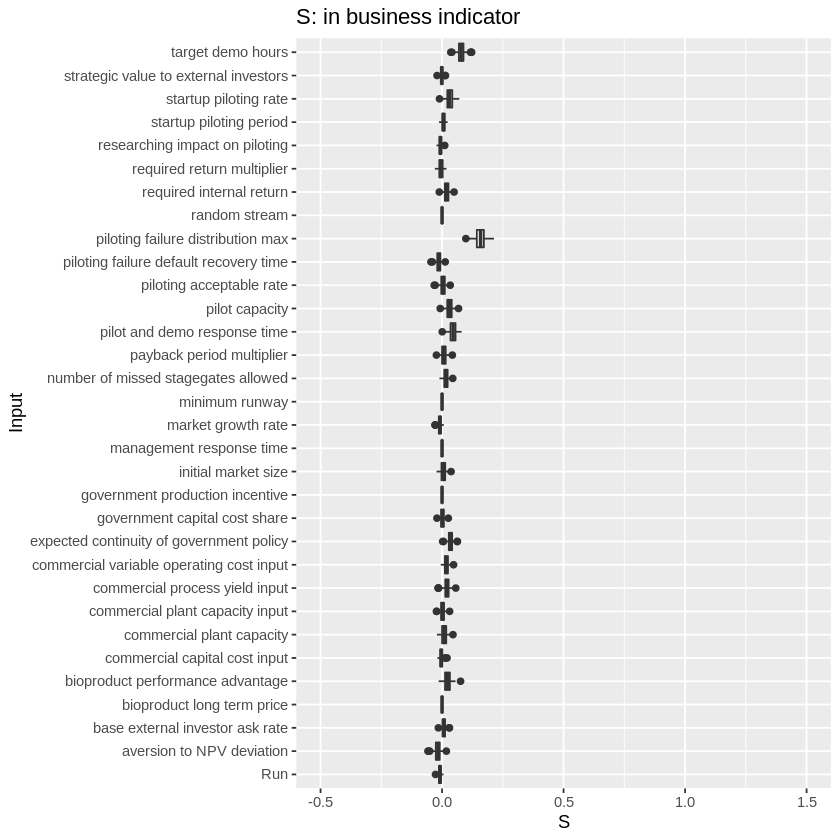

Warning message:
"Removed 114 rows containing non-finite values (stat_boxplot)."

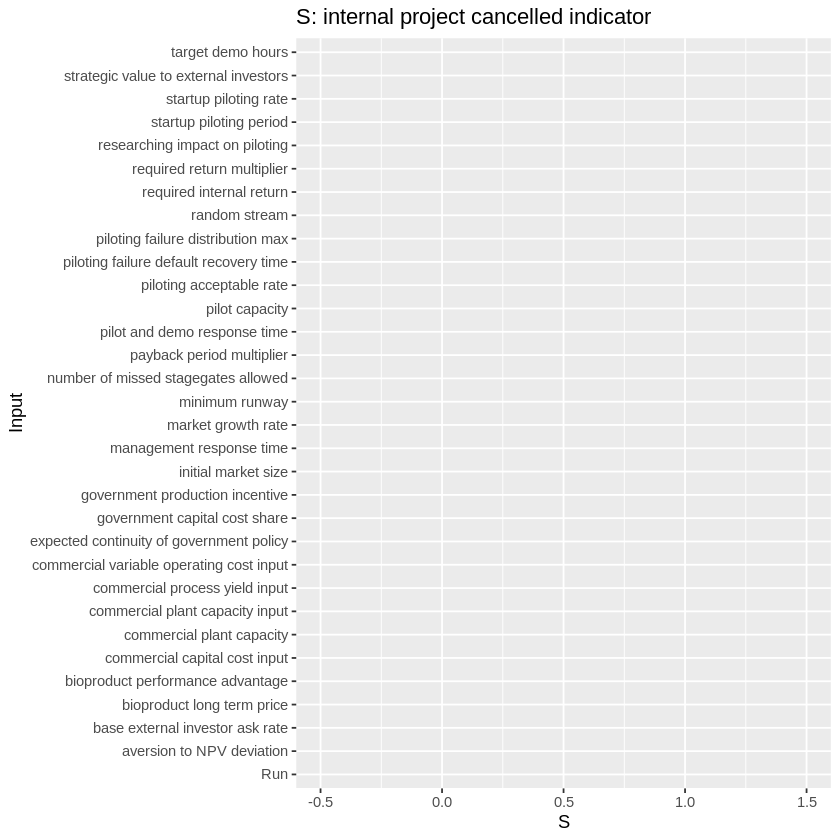

Warning message:
"Removed 838 rows containing non-finite values (stat_boxplot)."

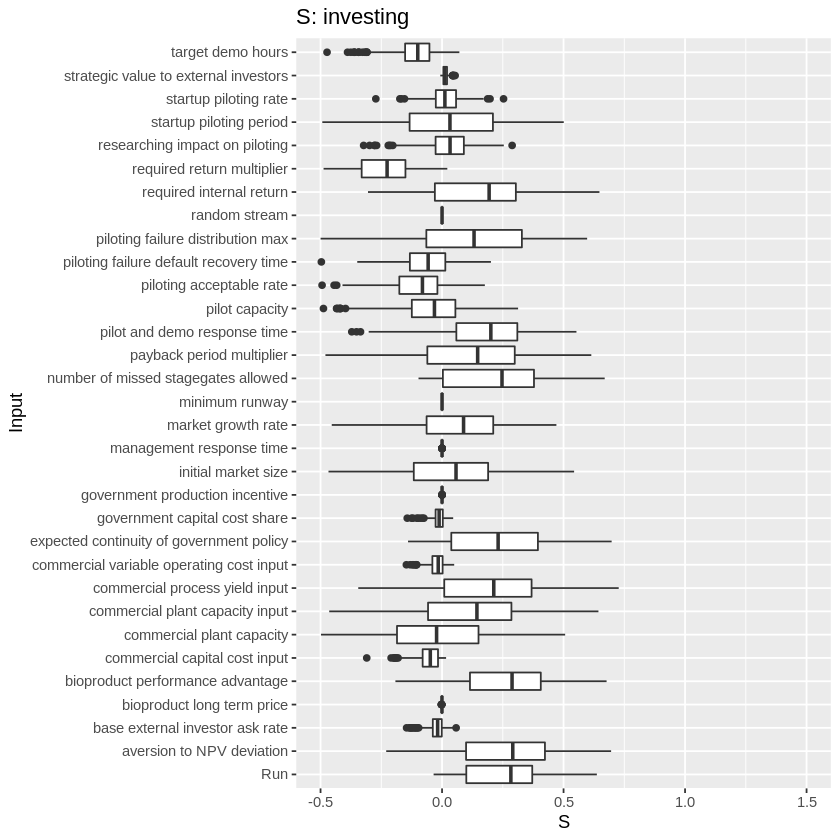

Warning message:
"Removed 12 rows containing non-finite values (stat_boxplot)."

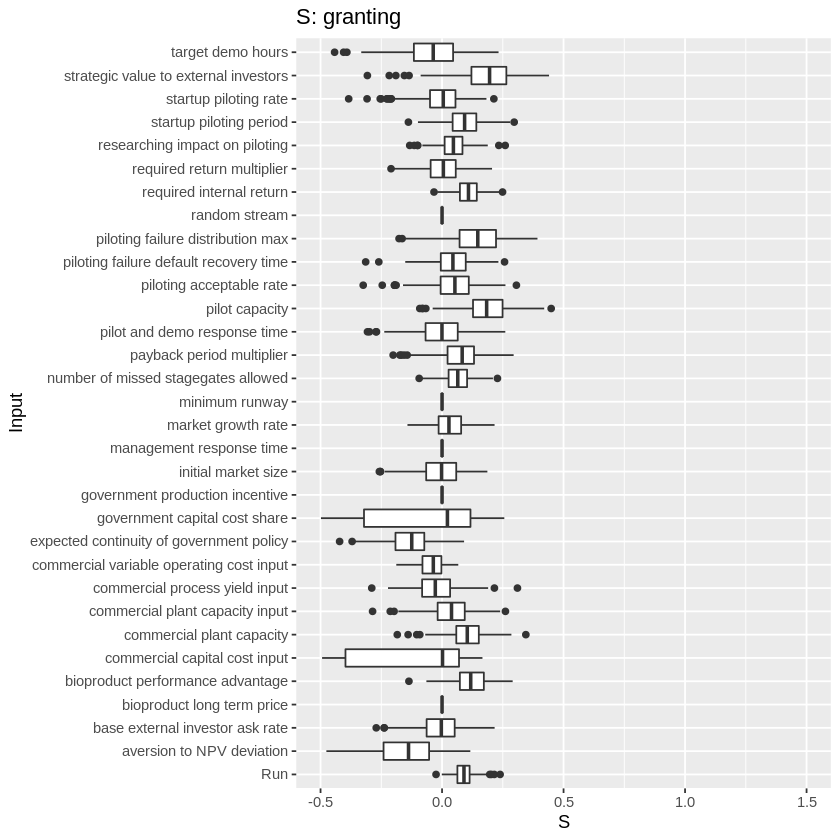

Warning message:
"Removed 21 rows containing non-finite values (stat_boxplot)."

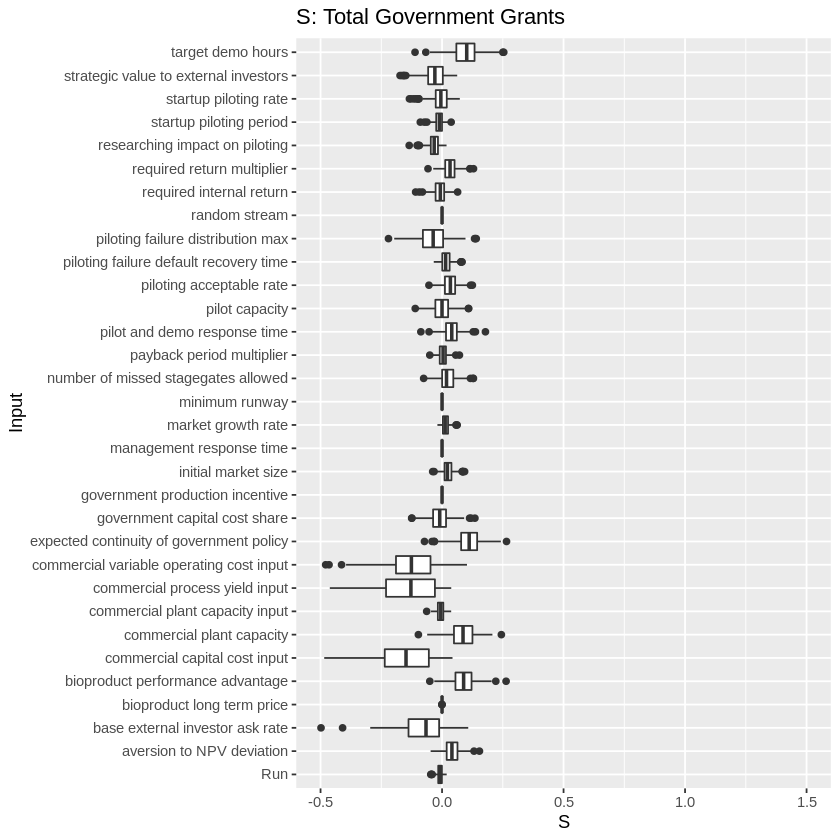

Warning message:
"Removed 18 rows containing non-finite values (stat_boxplot)."

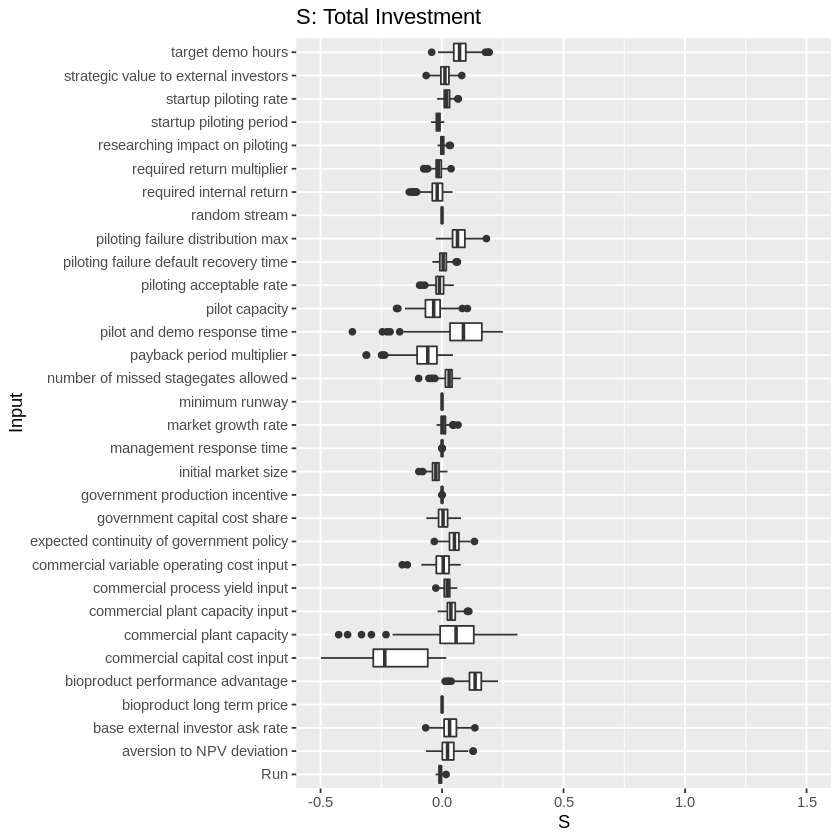

Warning message:
"Removed 3 rows containing non-finite values (stat_boxplot)."

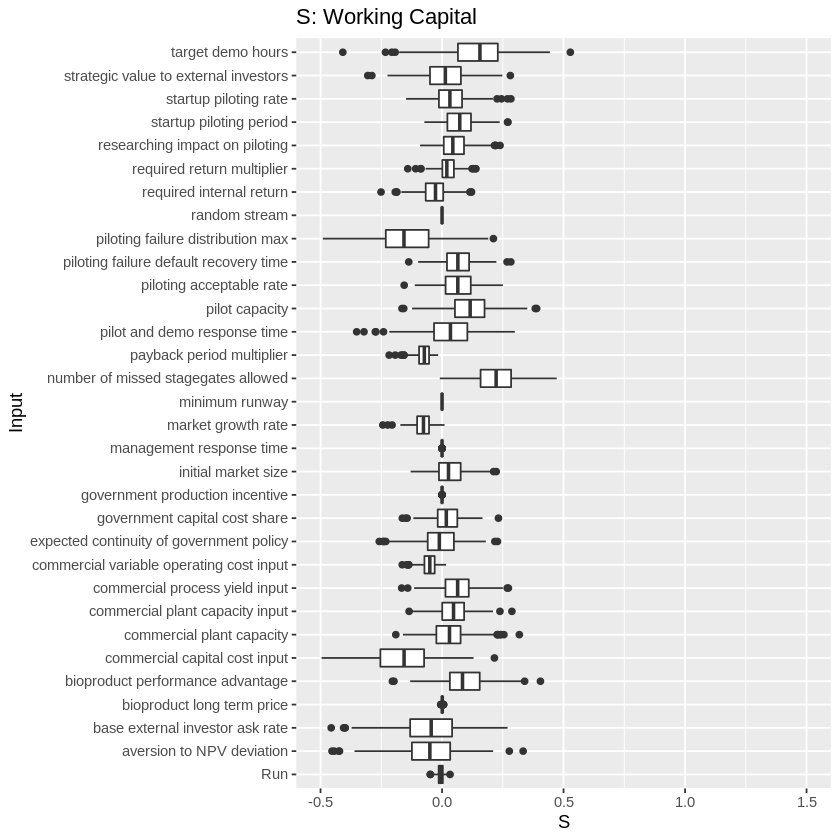

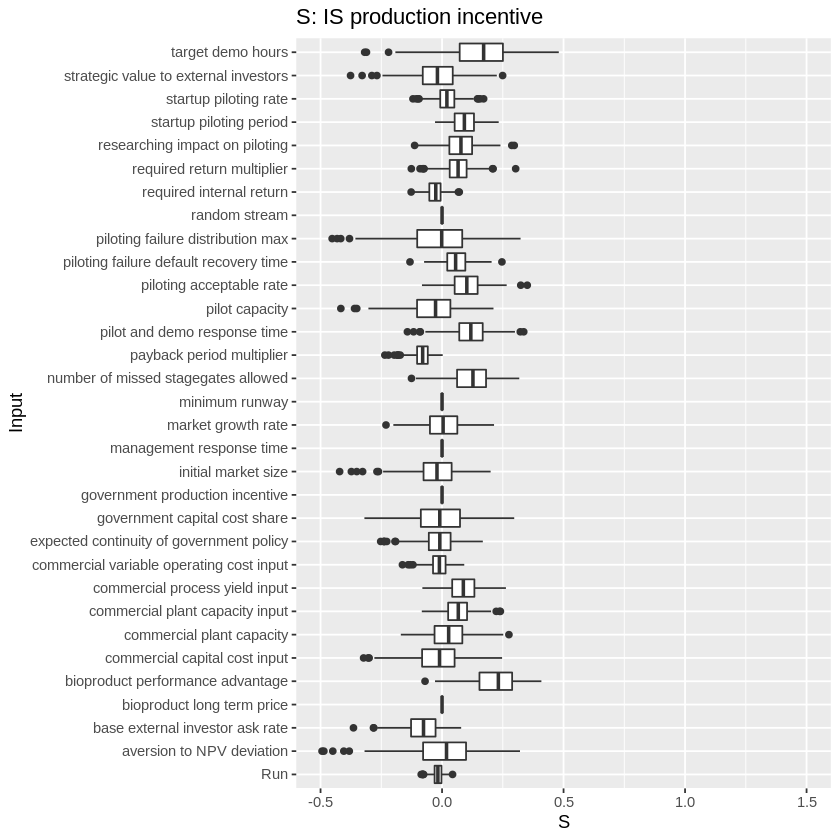

In [18]:
for (output in z.sens.boot[, unique(Output)]) {
    g <- ggplot(z.sens.boot[Output == output], aes(x=Input, y=S)) +
        geom_boxplot() +
        ylim(-0.5, 1.5) +
        coord_flip() +
        ggtitle(paste("S:", output))
    print(g)
}

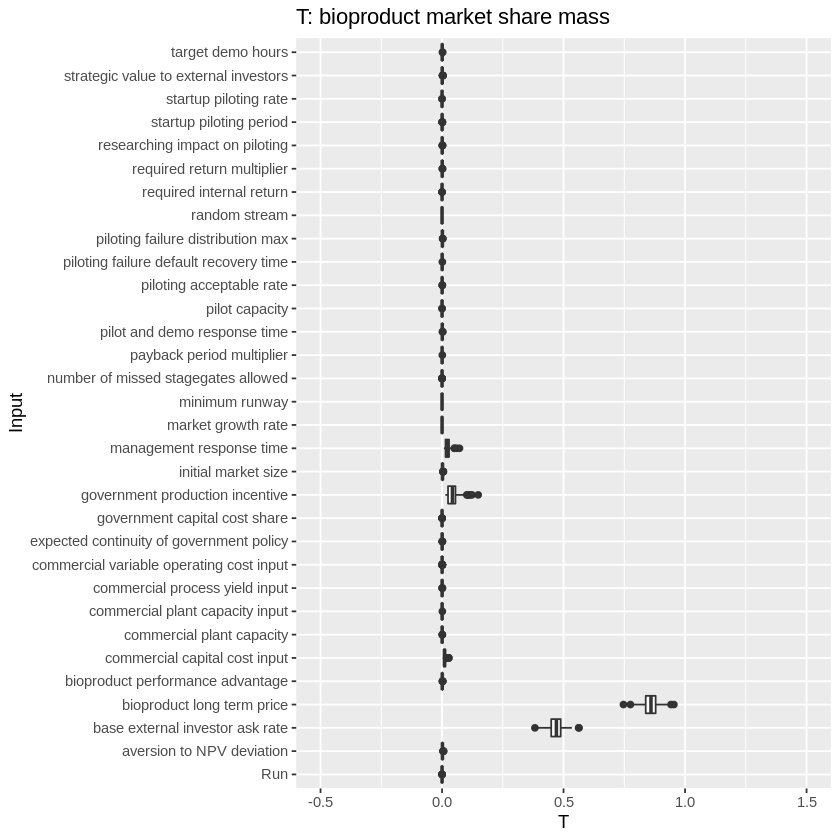

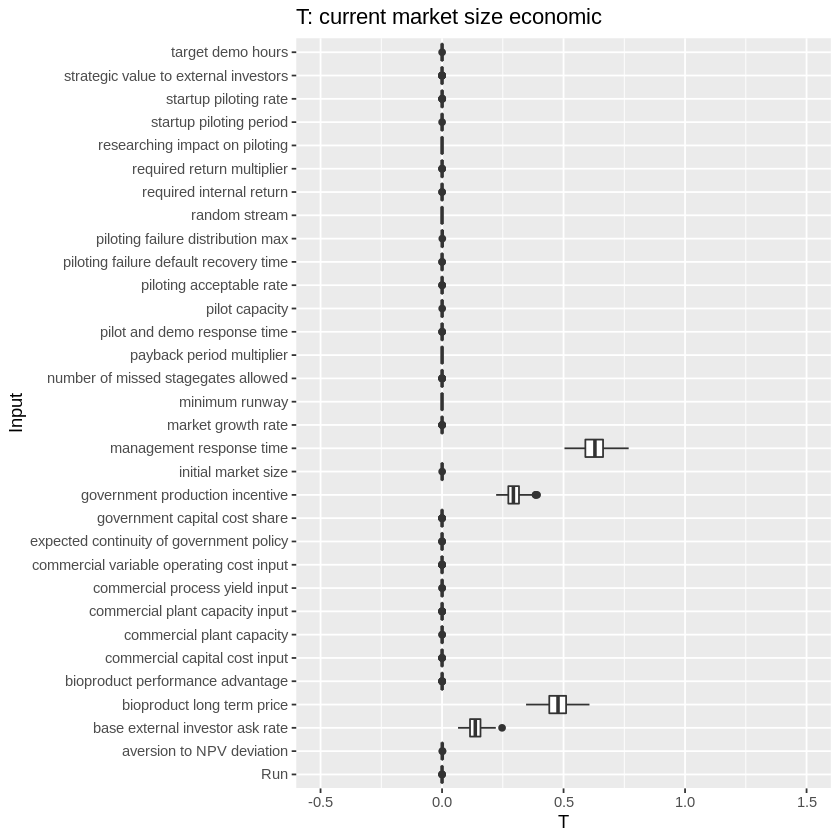

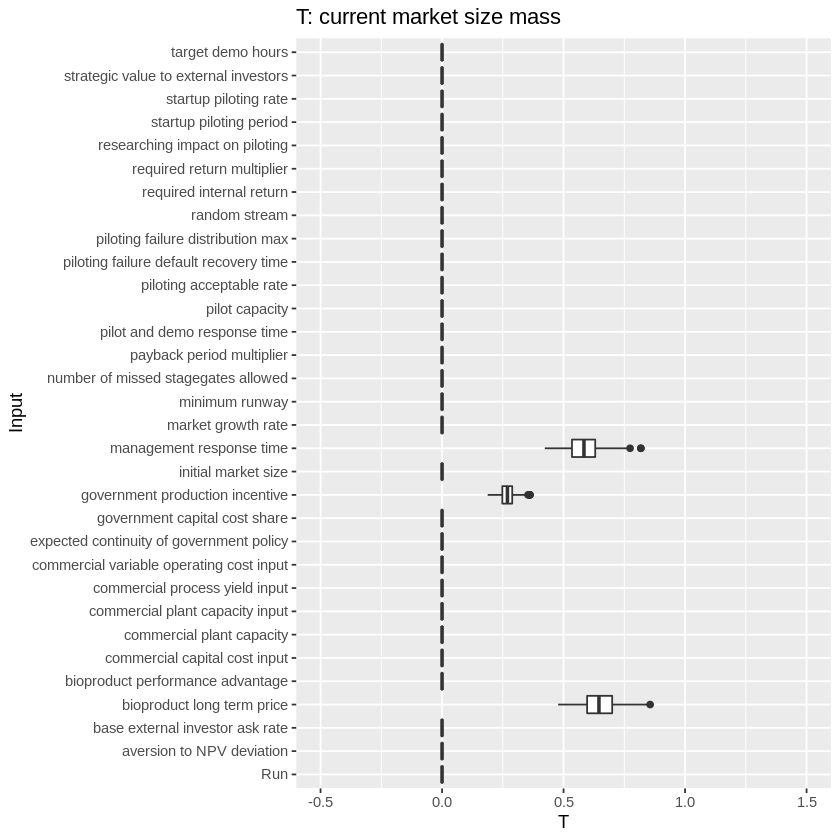

Warning message:
"Removed 65 rows containing non-finite values (stat_boxplot)."

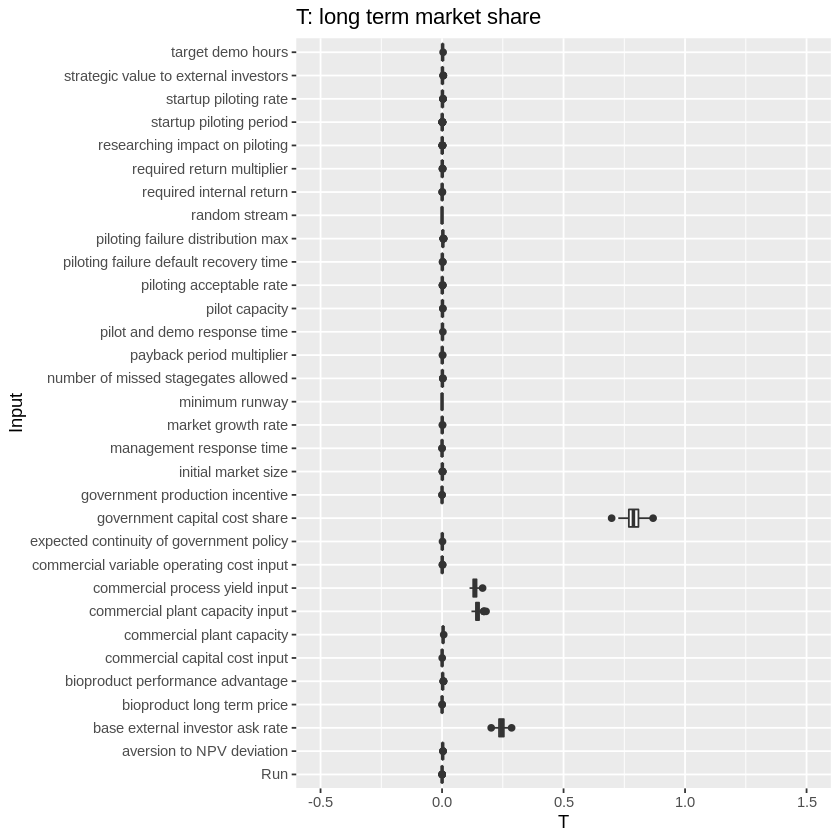

Warning message:
"Removed 3 rows containing non-finite values (stat_boxplot)."

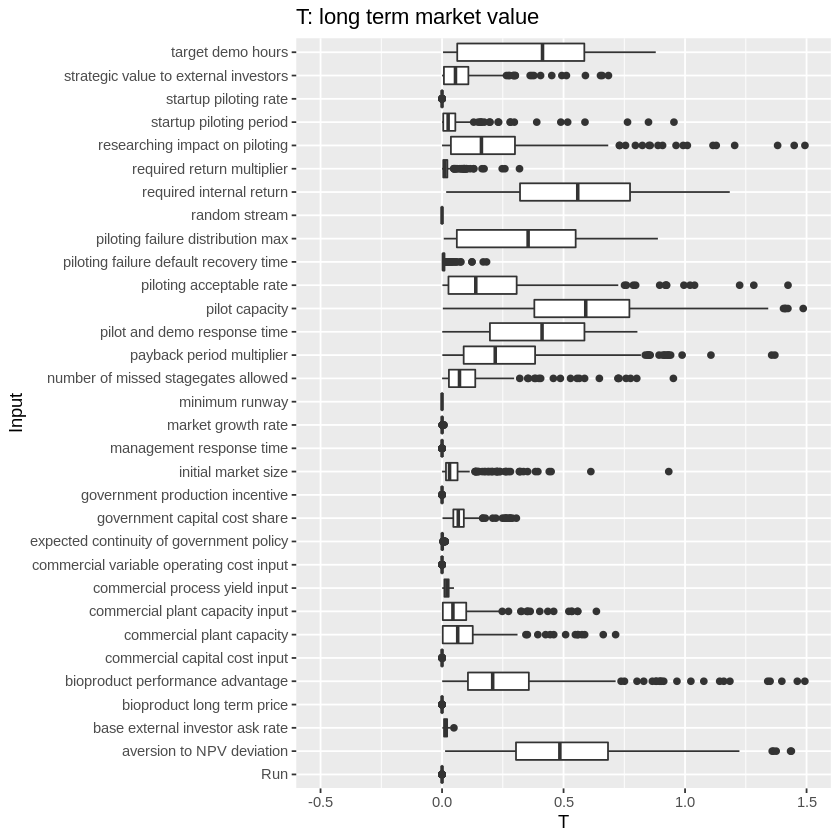

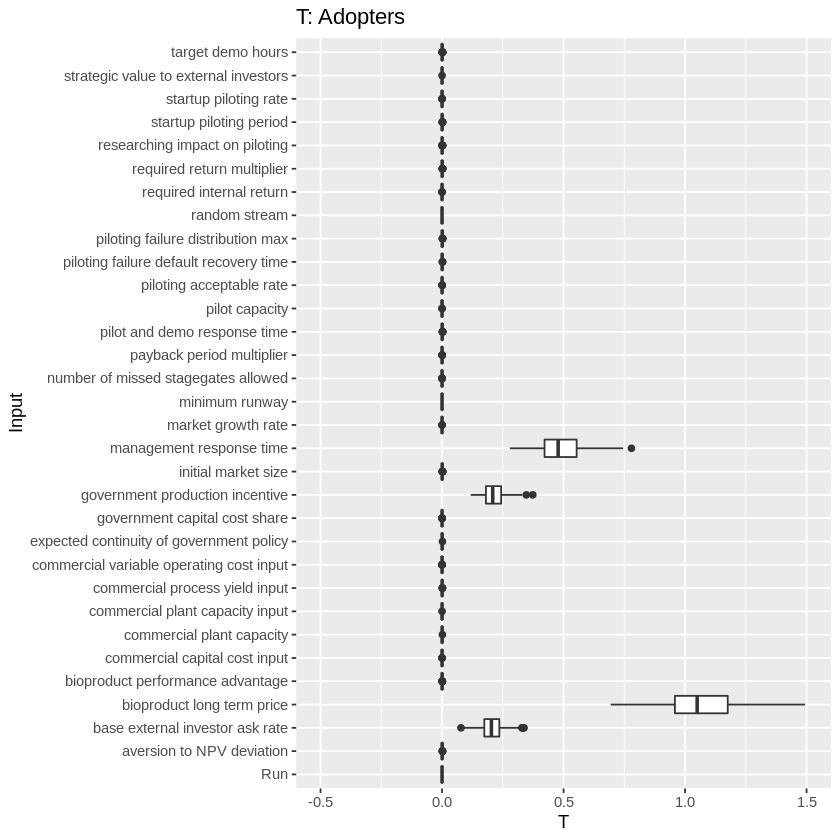

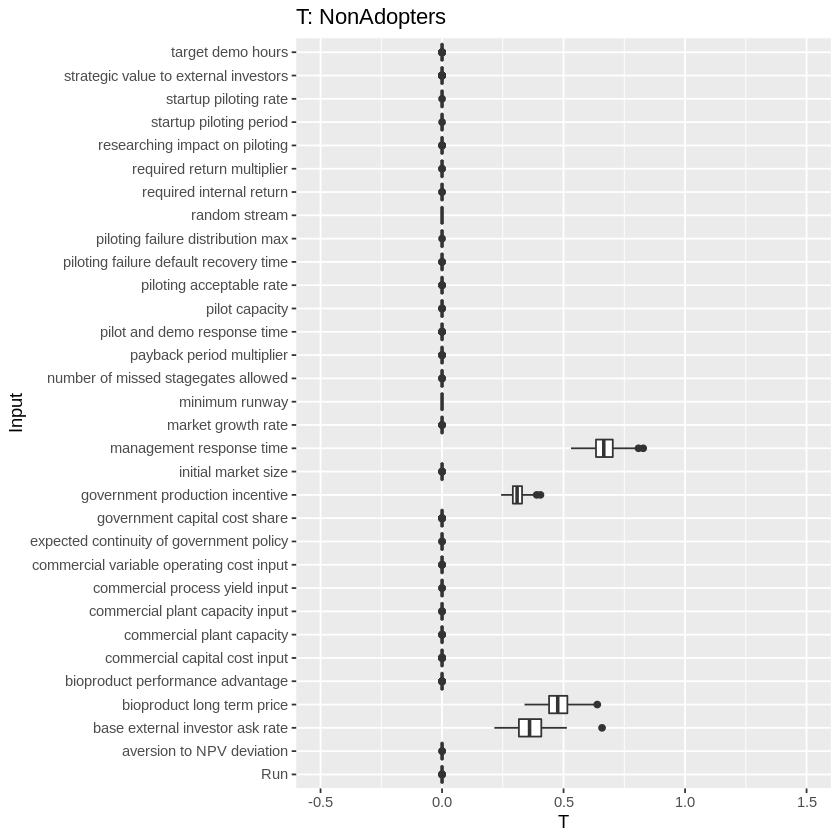

Warning message:
"Removed 9600 rows containing non-finite values (stat_boxplot)."

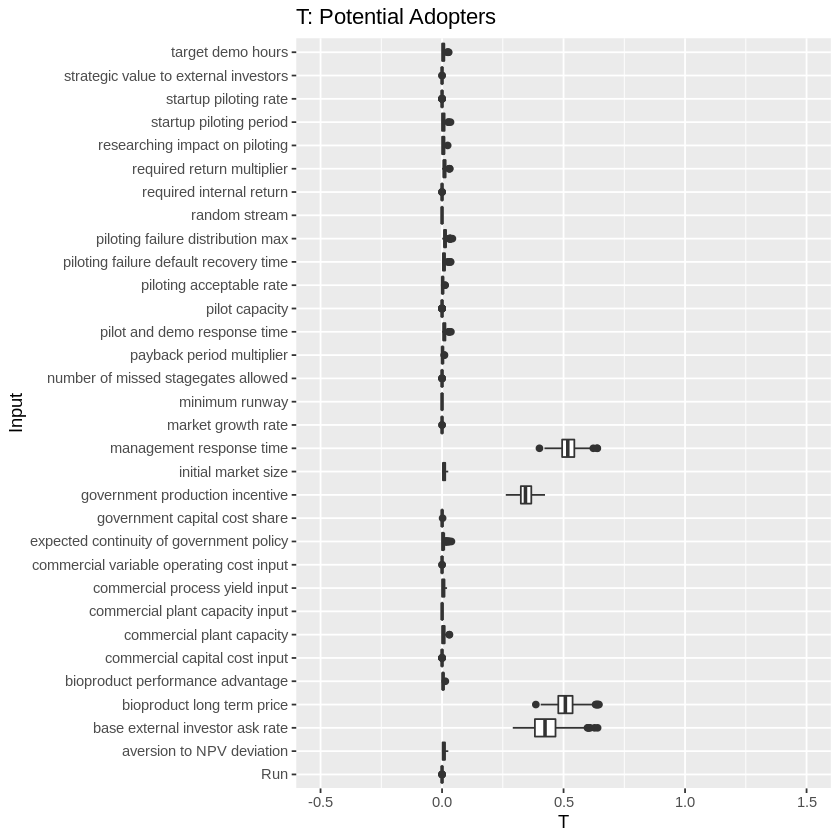

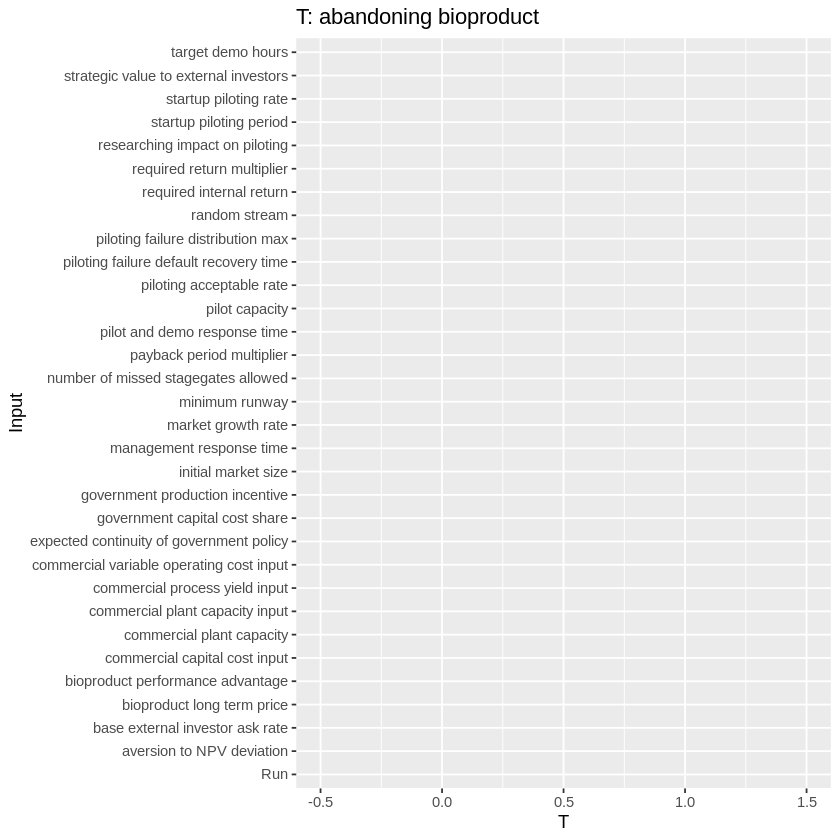

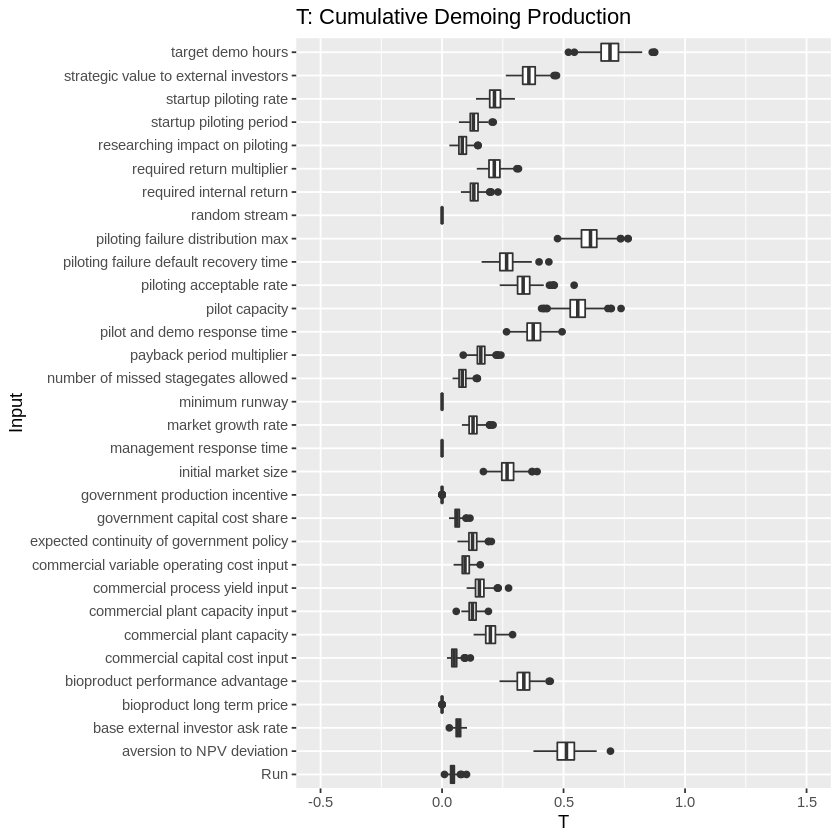

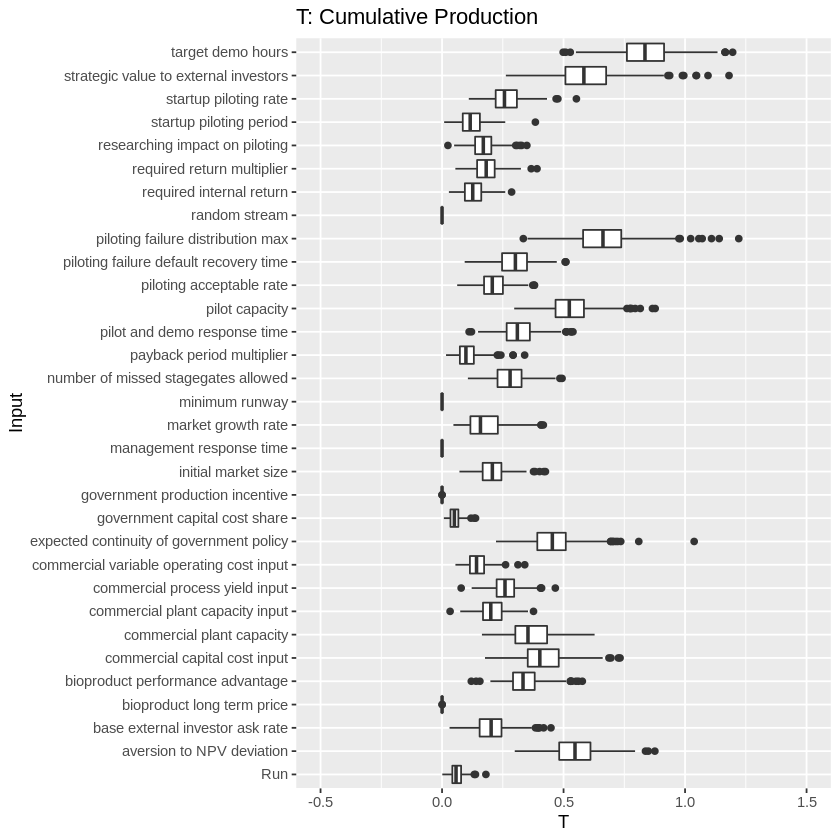

Warning message:
"Removed 3639 rows containing non-finite values (stat_boxplot)."

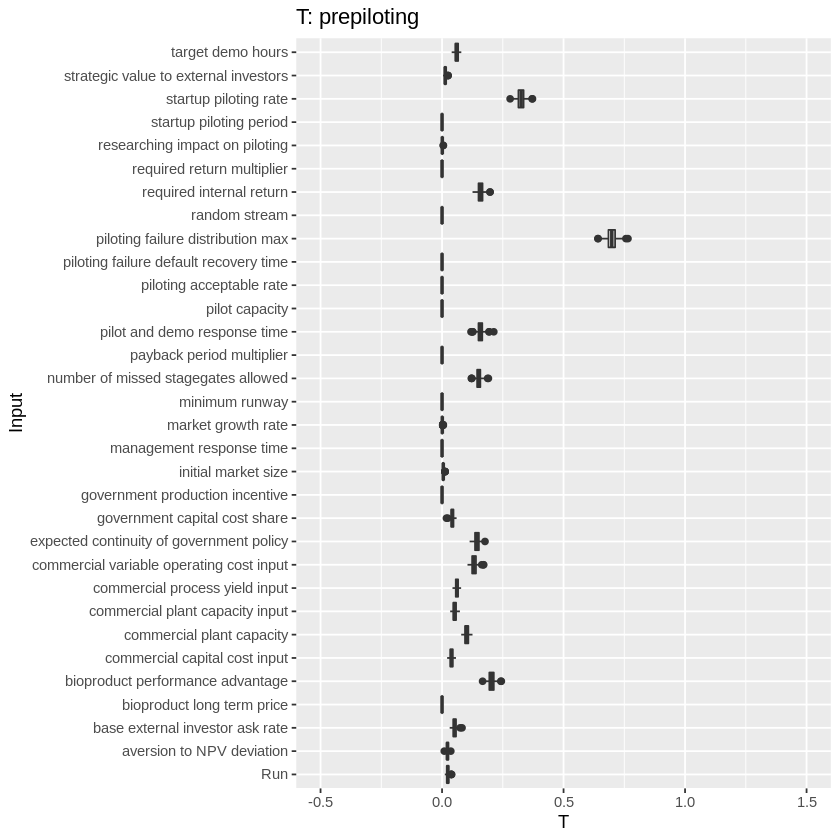

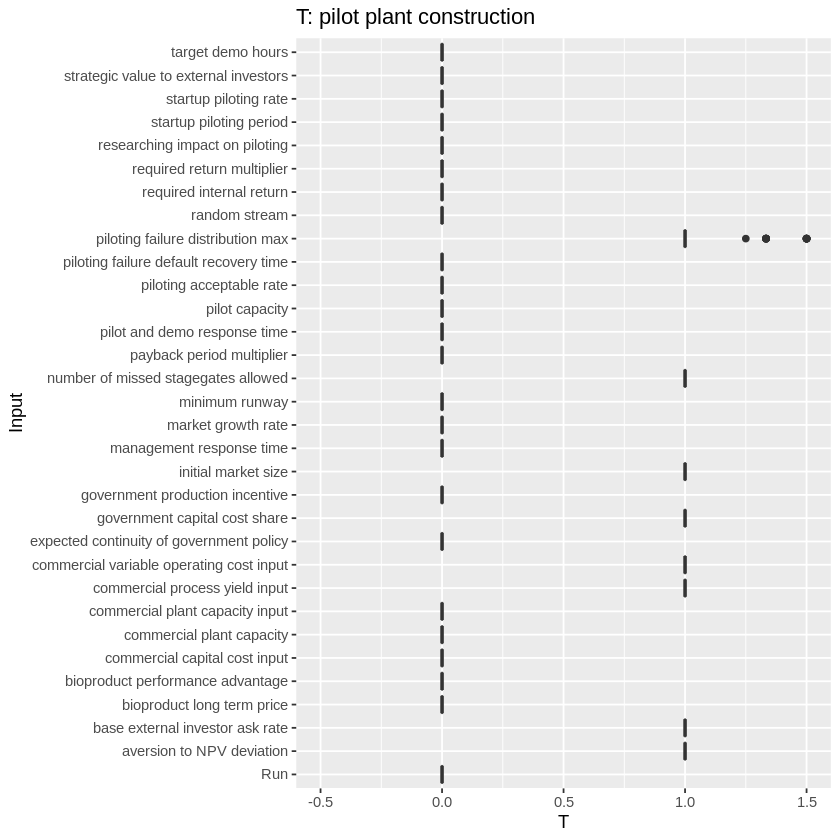

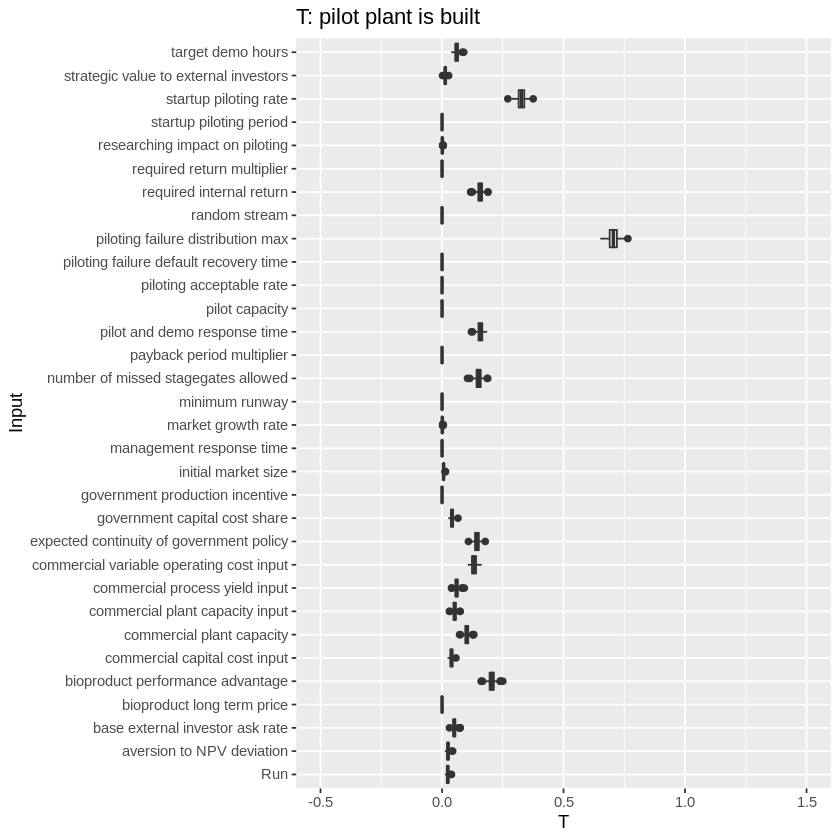

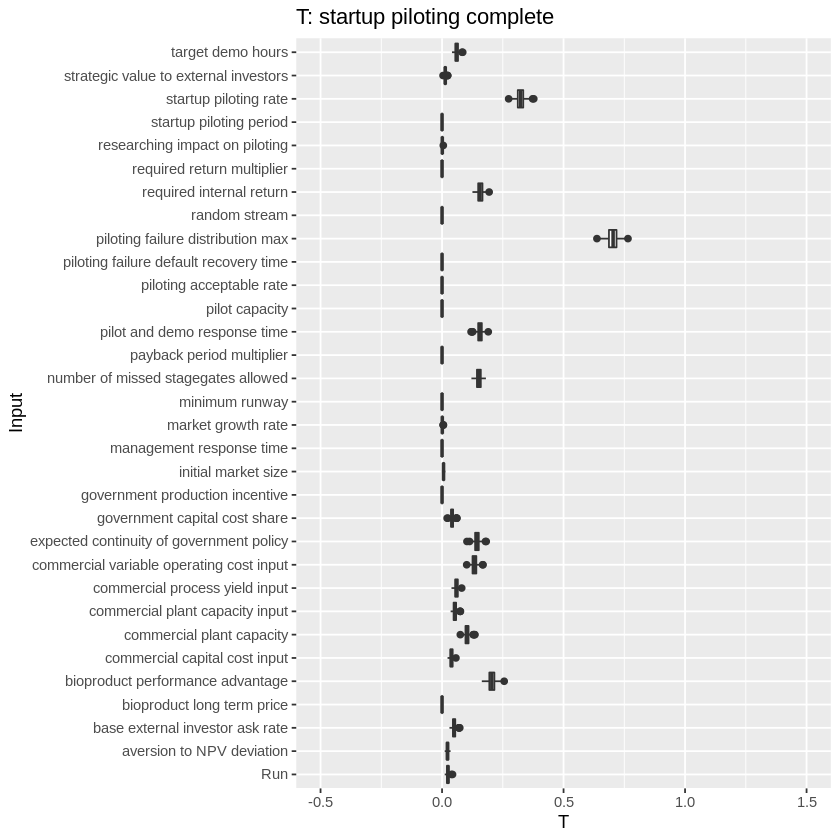

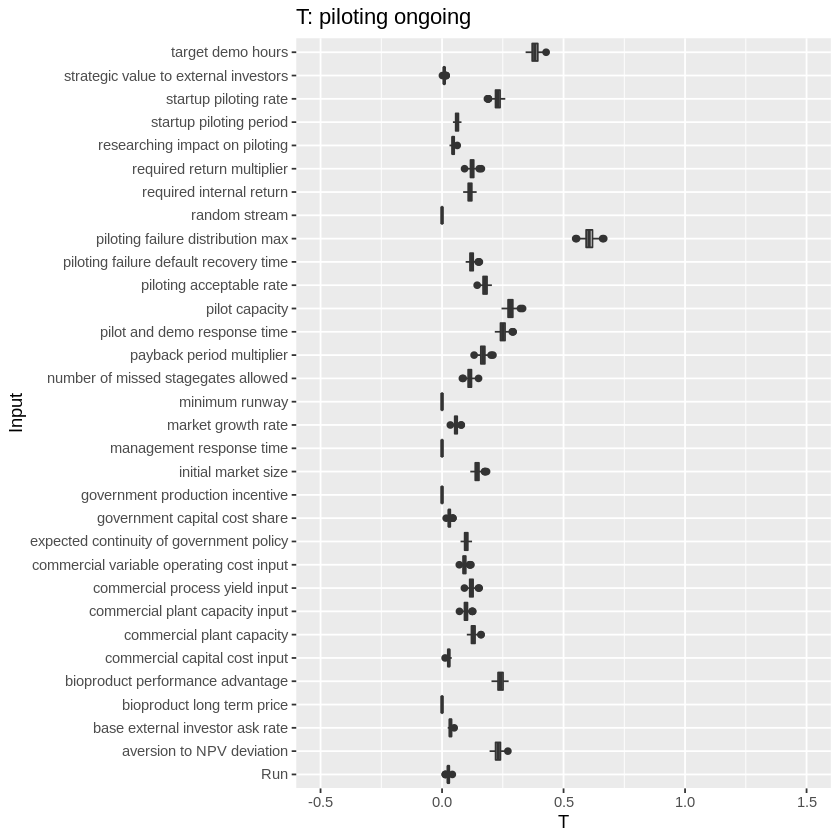

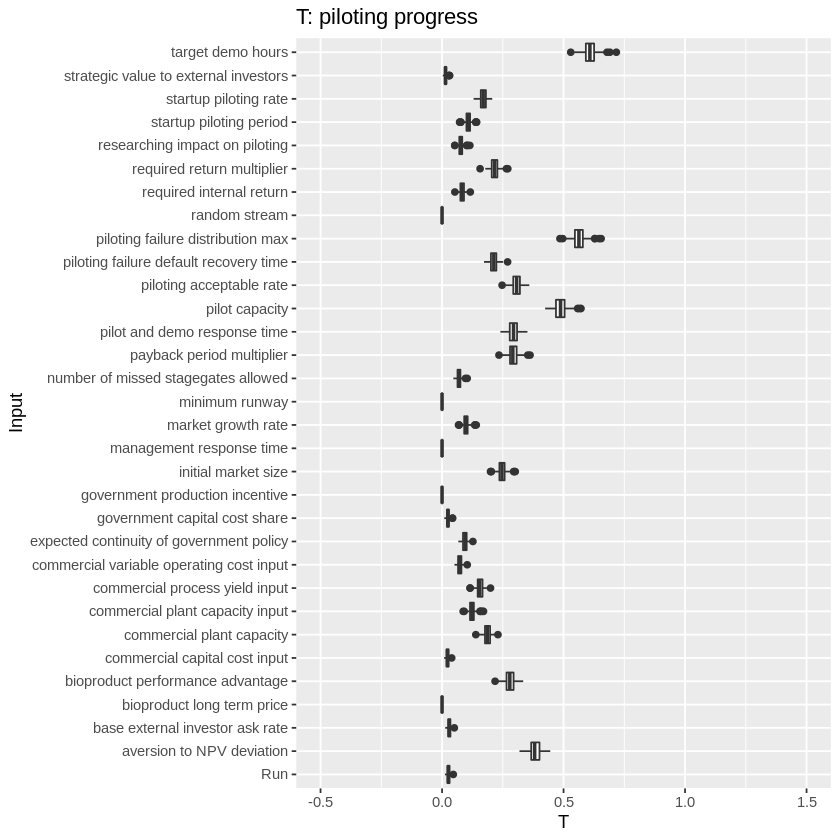

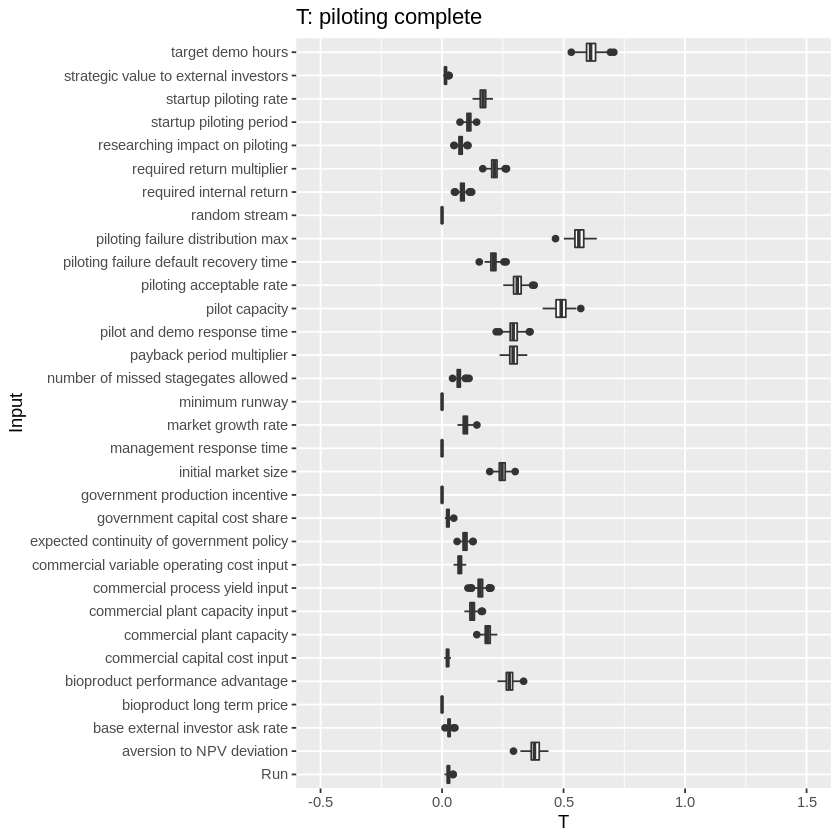

Warning message:
"Removed 167 rows containing non-finite values (stat_boxplot)."

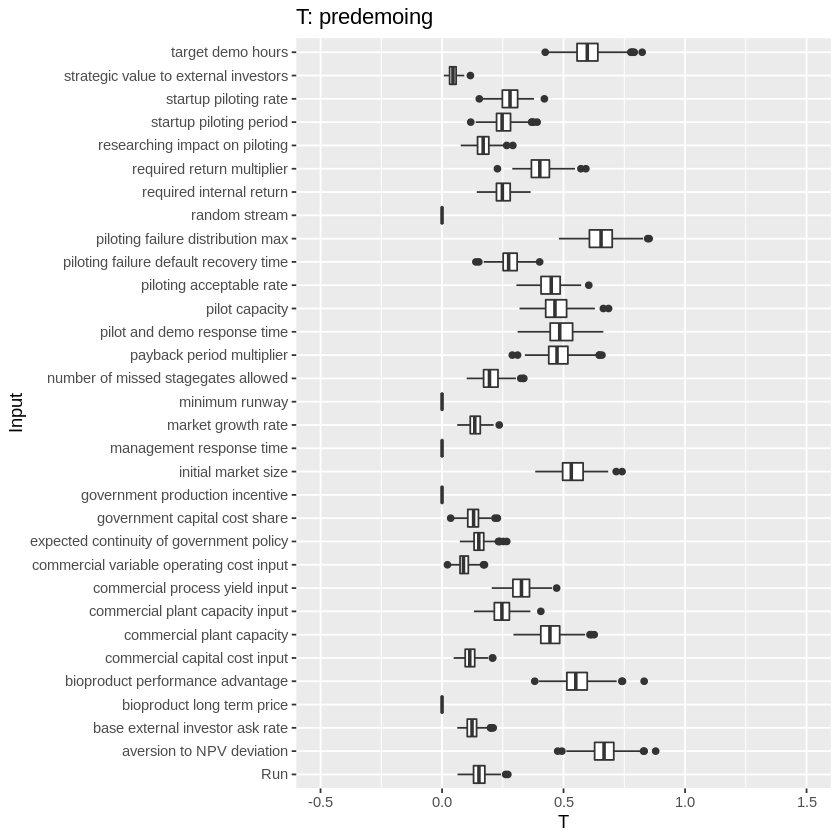

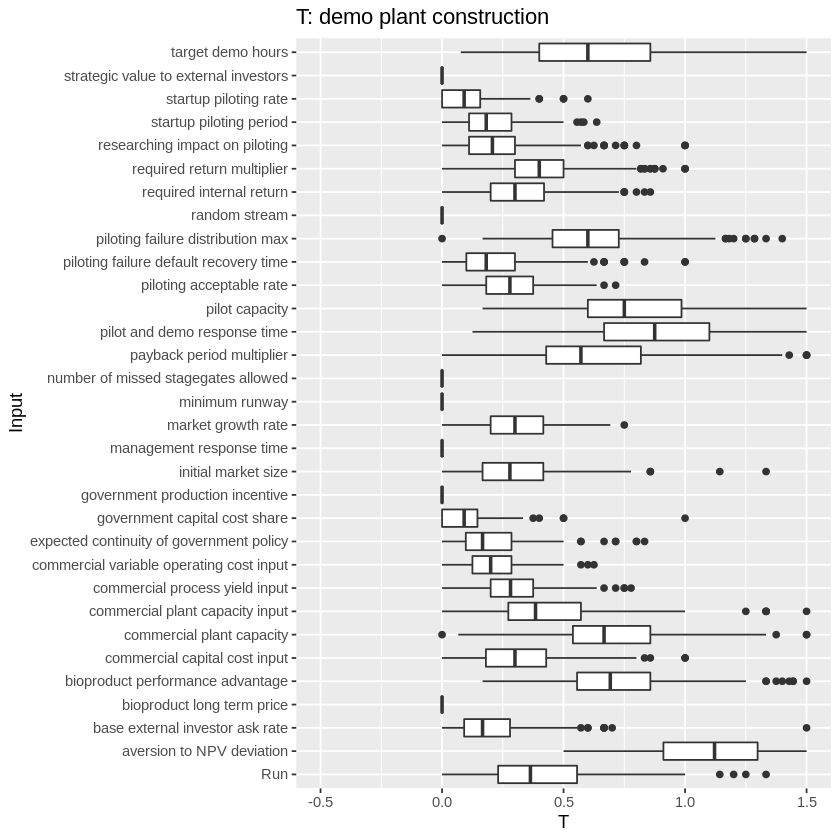

Warning message:
"Removed 5 rows containing non-finite values (stat_boxplot)."

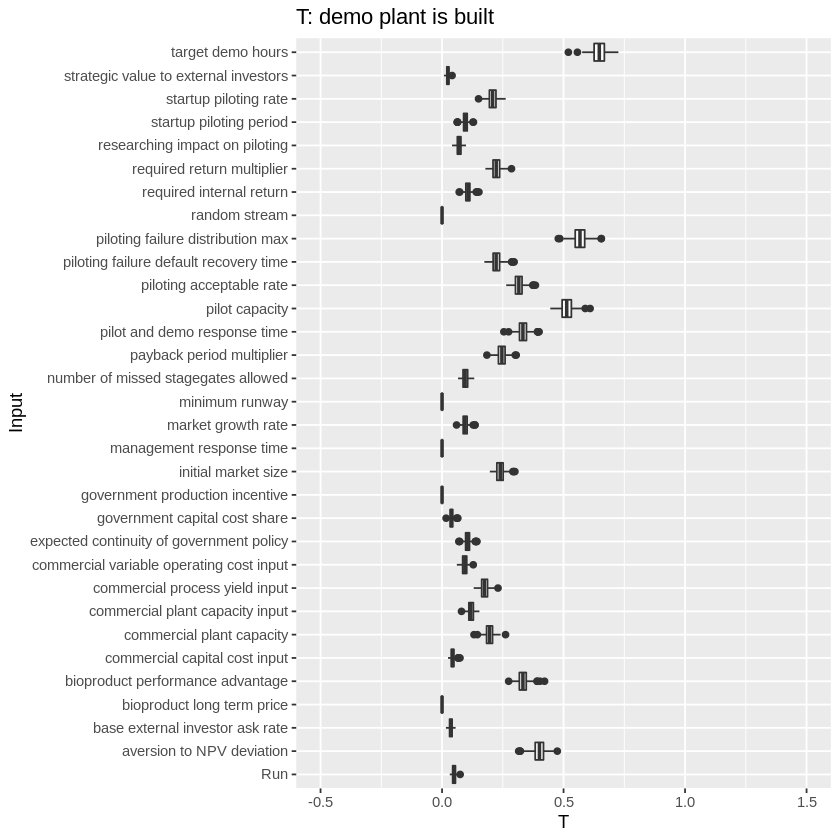

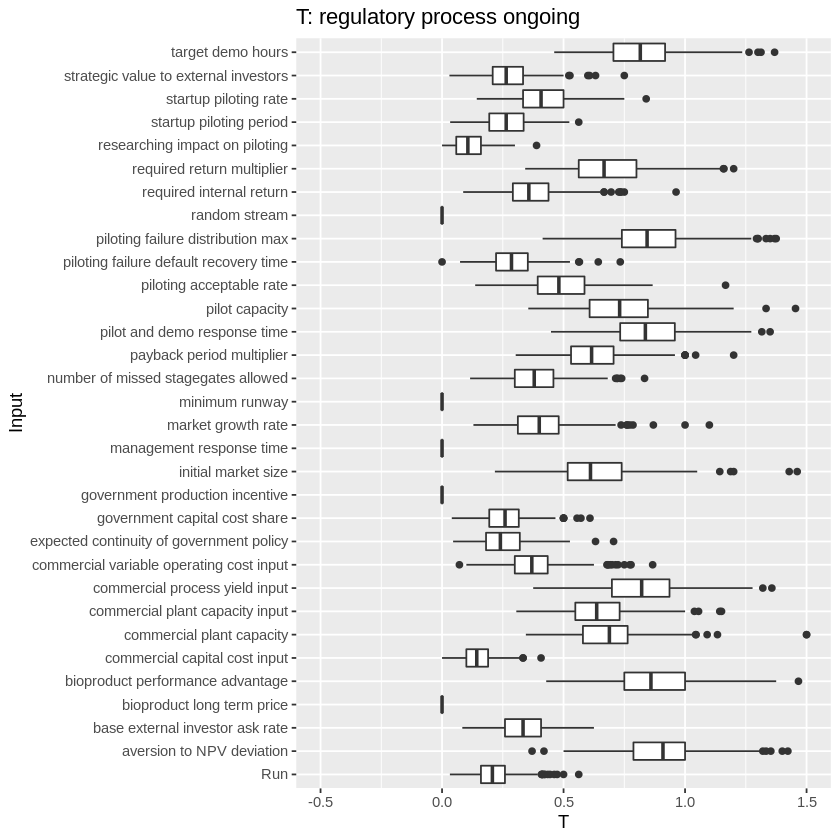

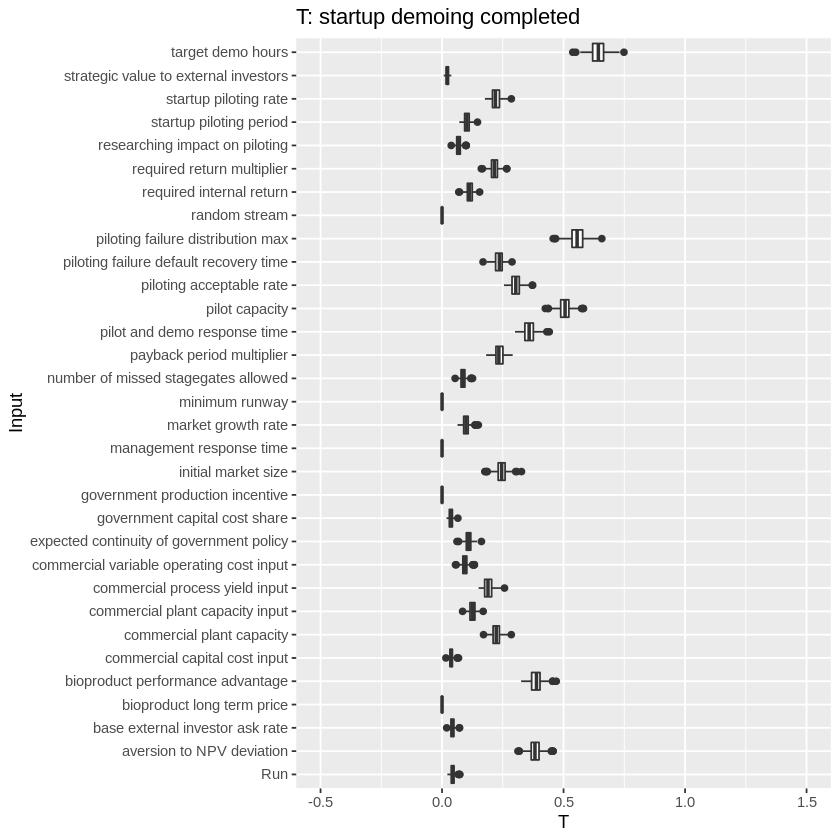

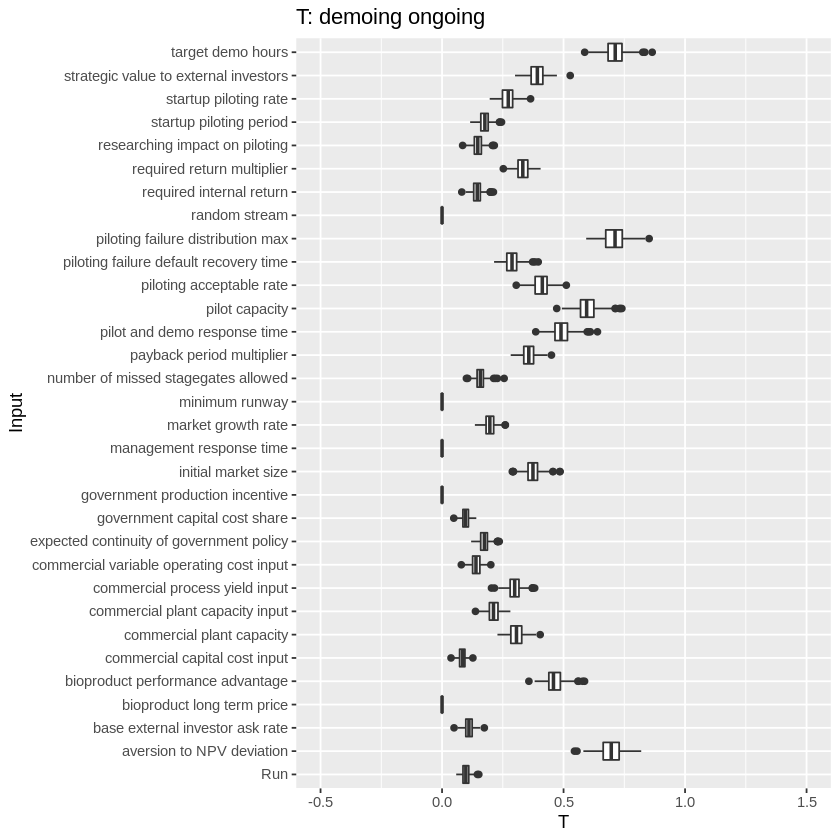

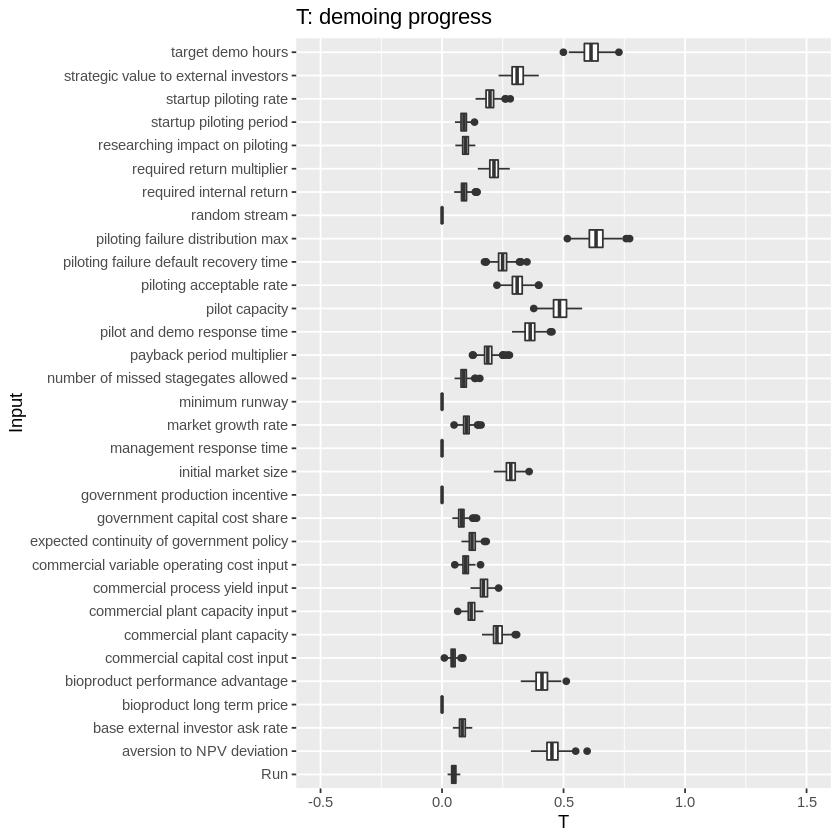

Warning message:
"Removed 378 rows containing non-finite values (stat_boxplot)."

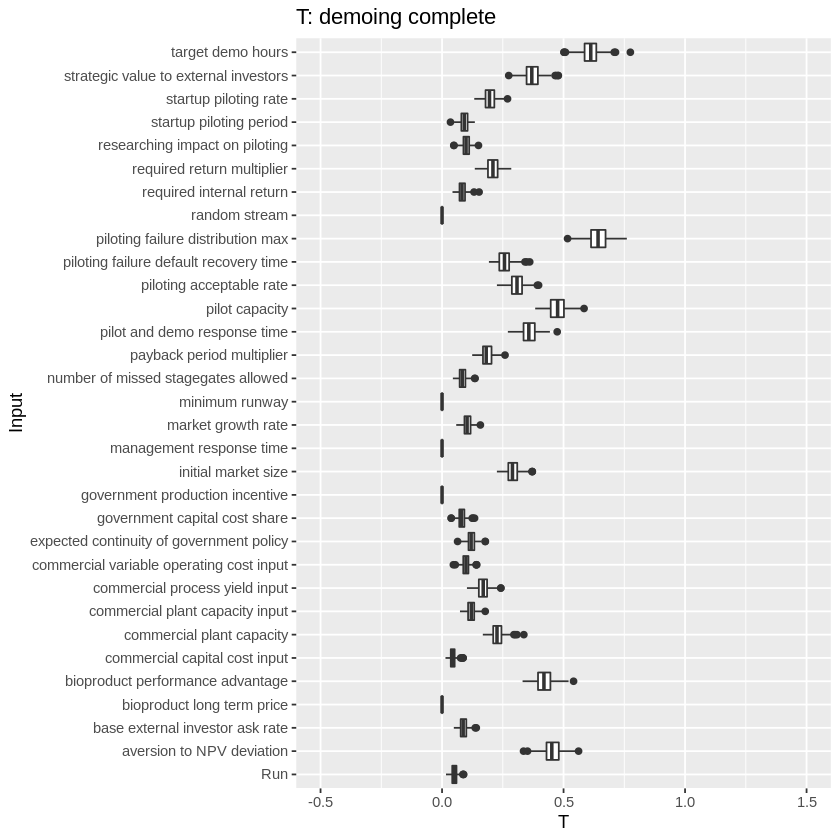

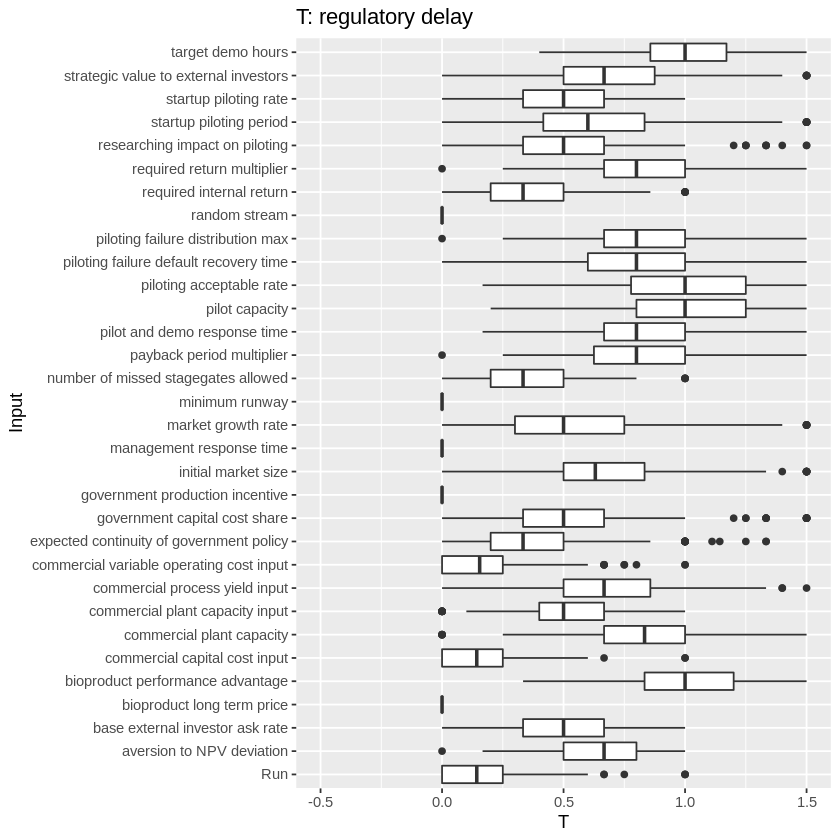

Warning message:
"Removed 544 rows containing non-finite values (stat_boxplot)."

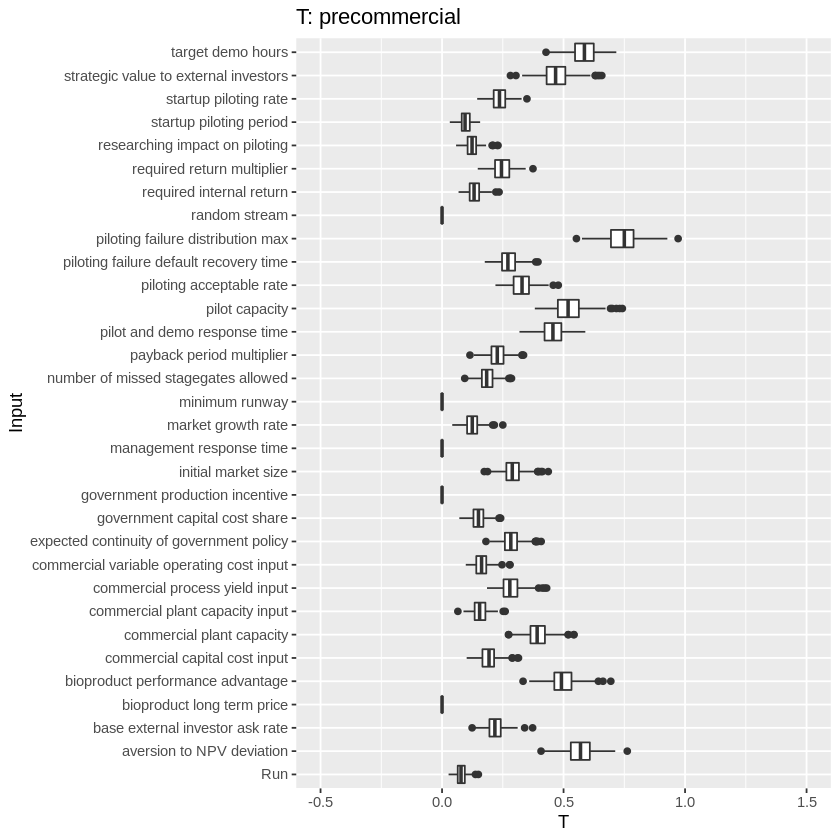

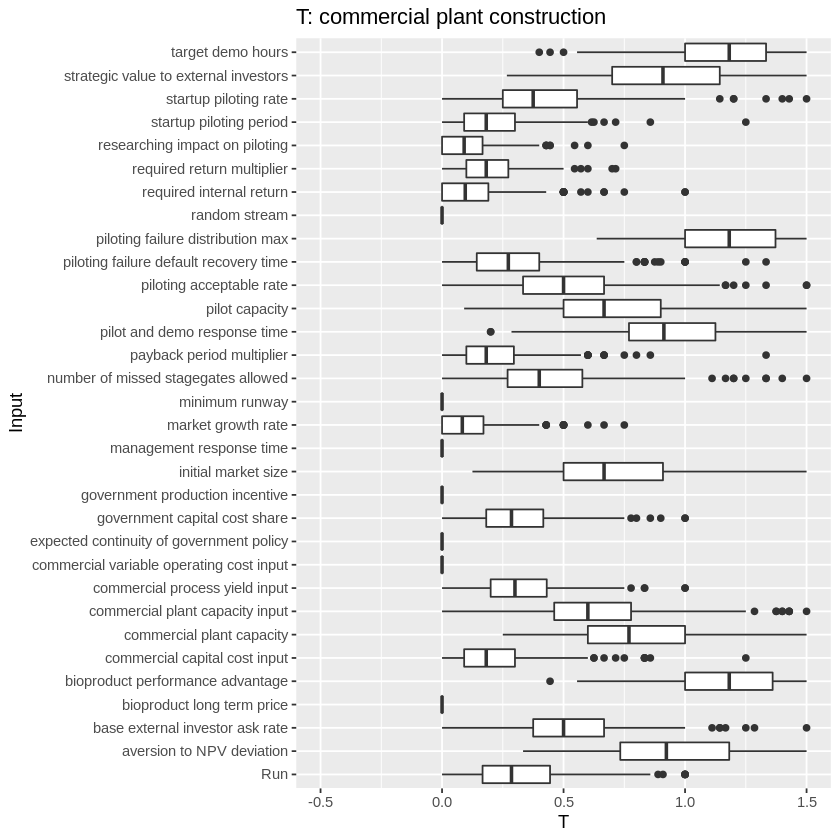

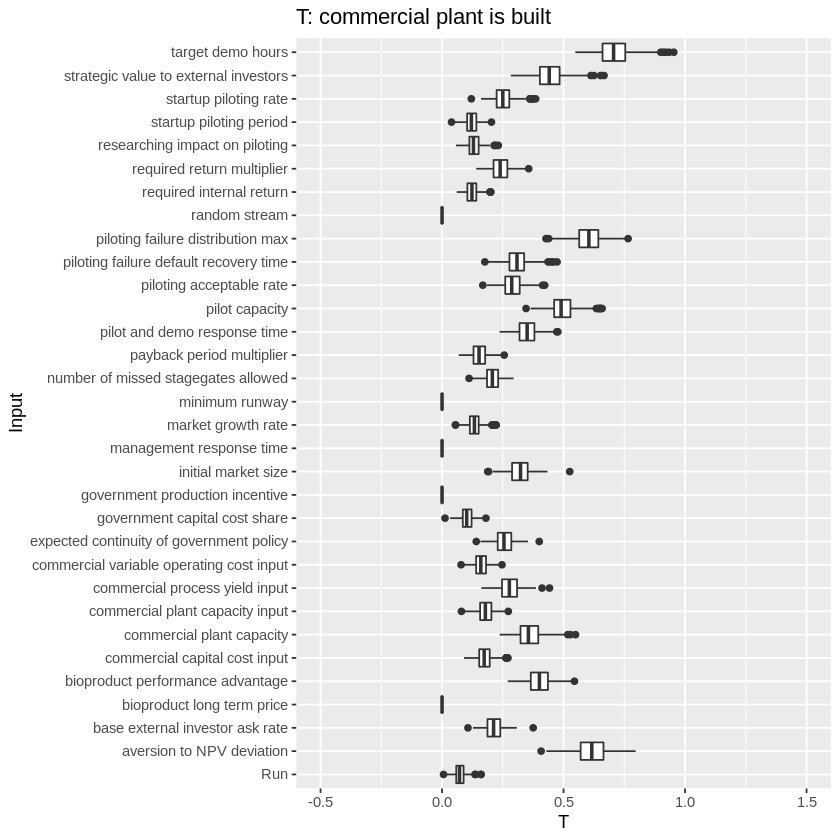

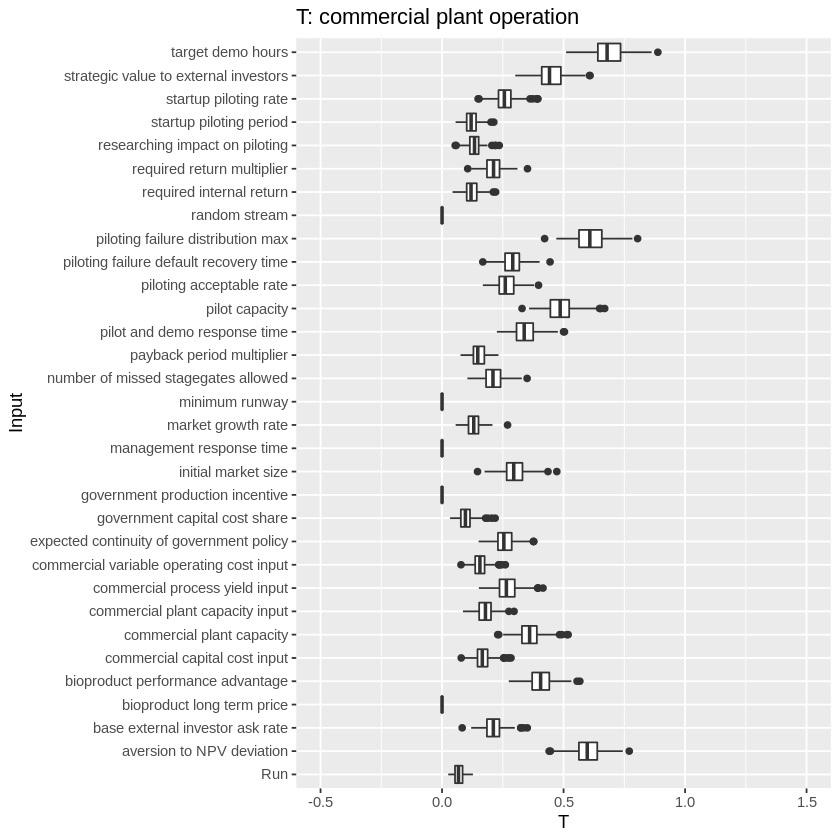

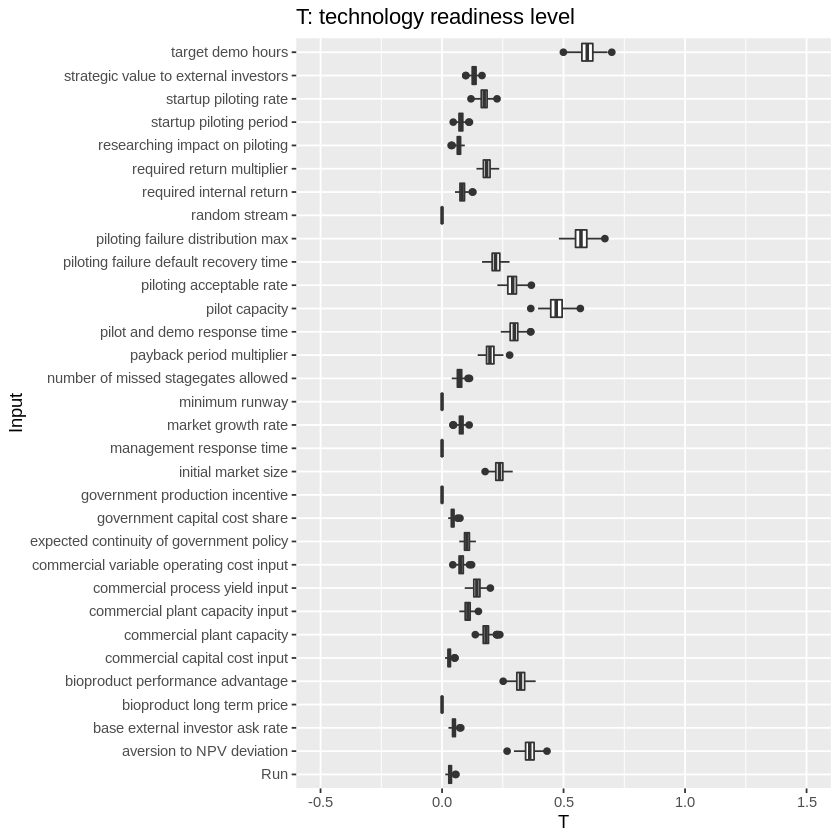

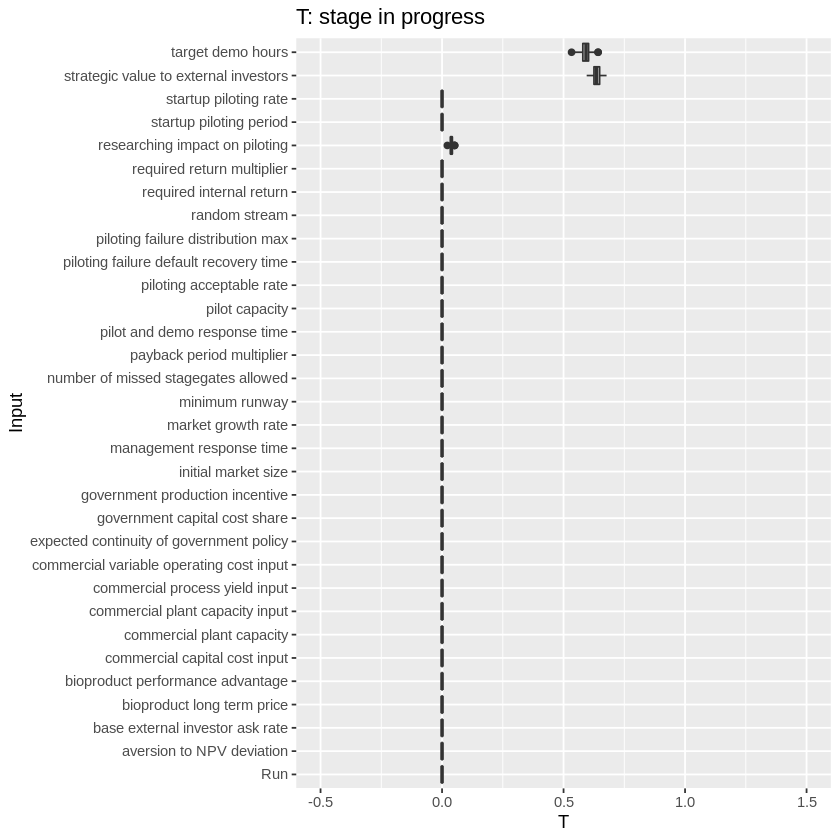

Warning message:
"Removed 495 rows containing non-finite values (stat_boxplot)."

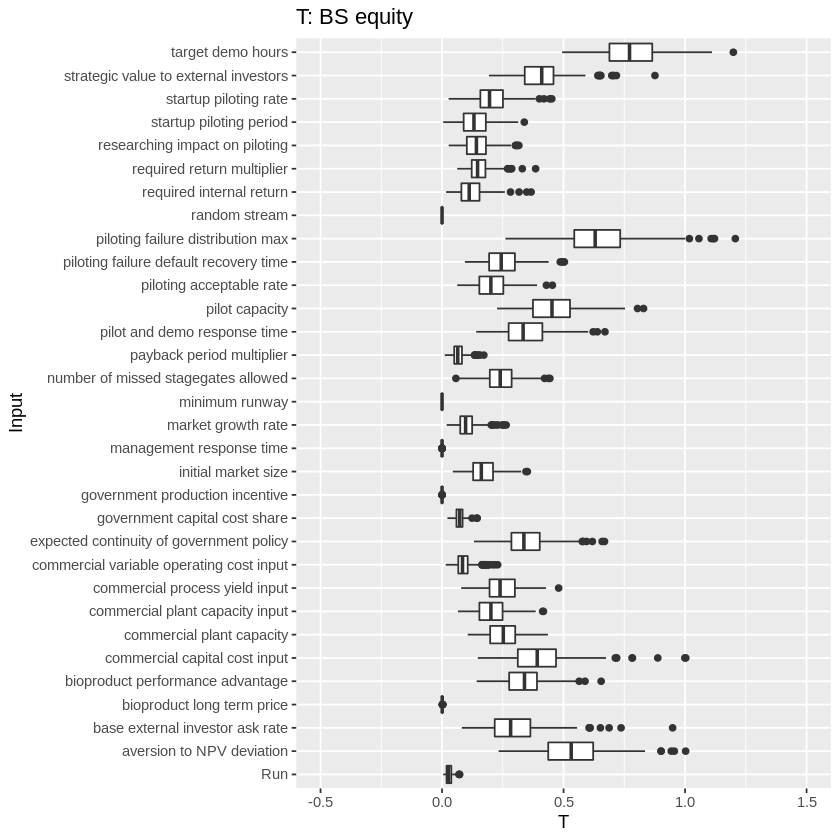

Warning message:
"Removed 3 rows containing non-finite values (stat_boxplot)."

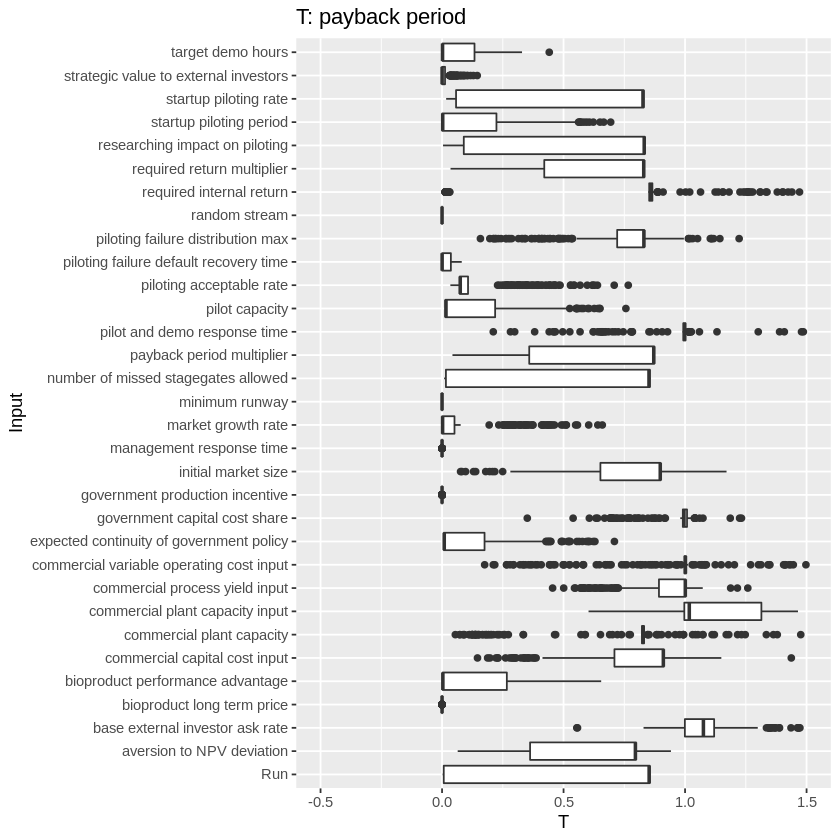

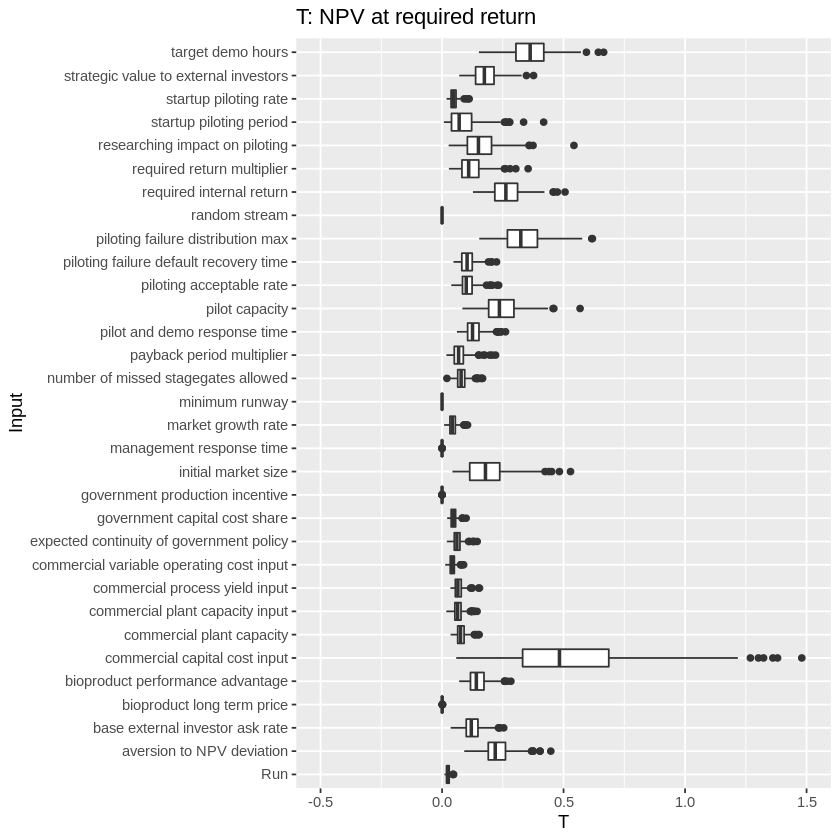

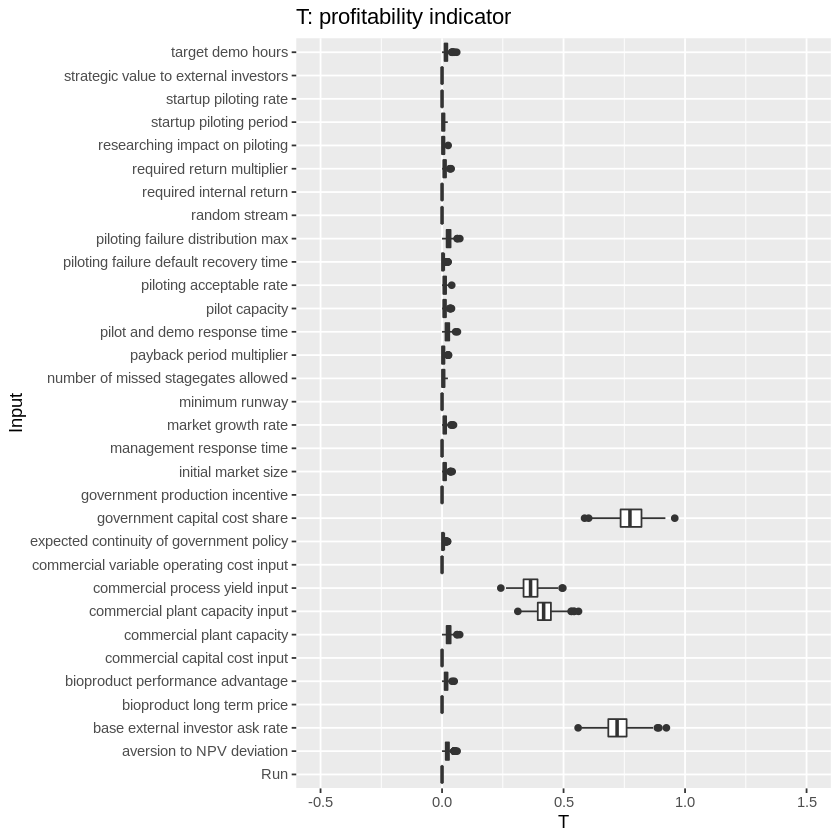

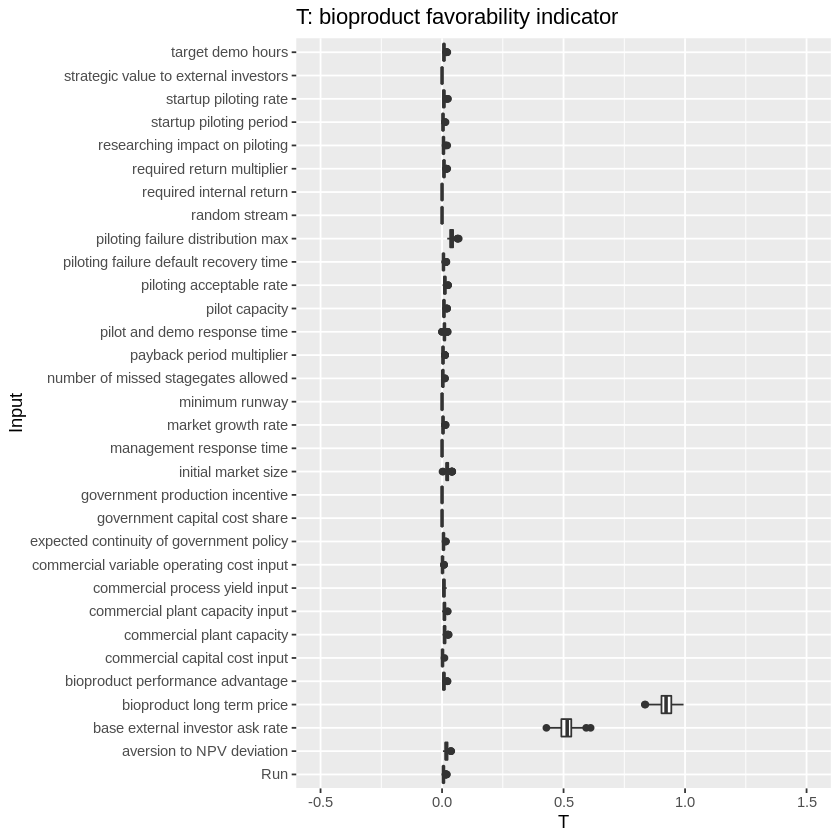

Warning message:
"Removed 9600 rows containing non-finite values (stat_boxplot)."

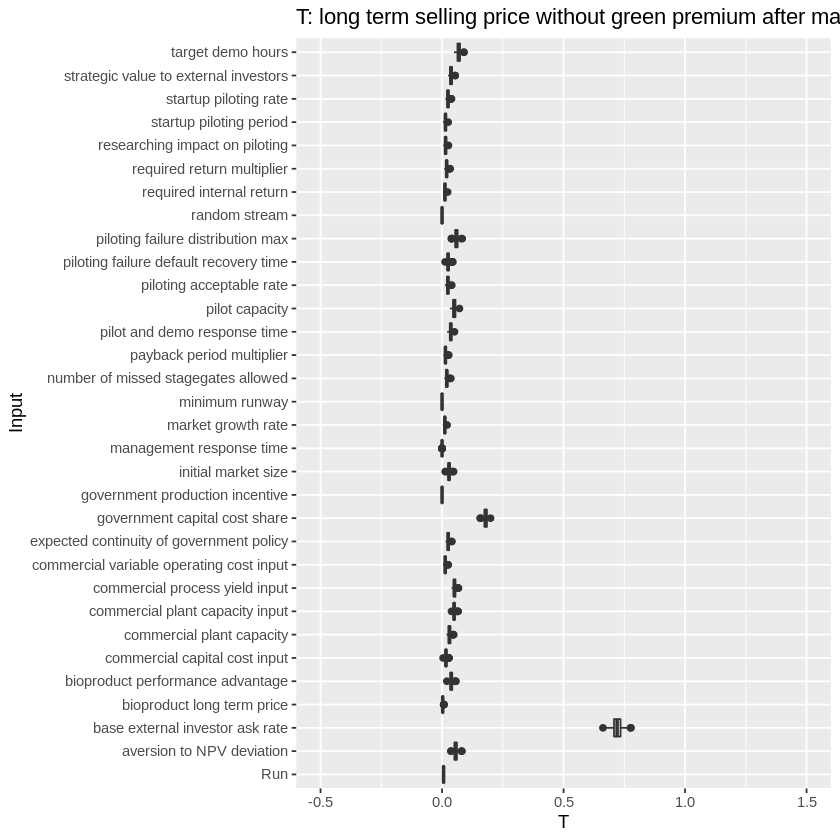

Warning message:
"Removed 9600 rows containing non-finite values (stat_boxplot)."

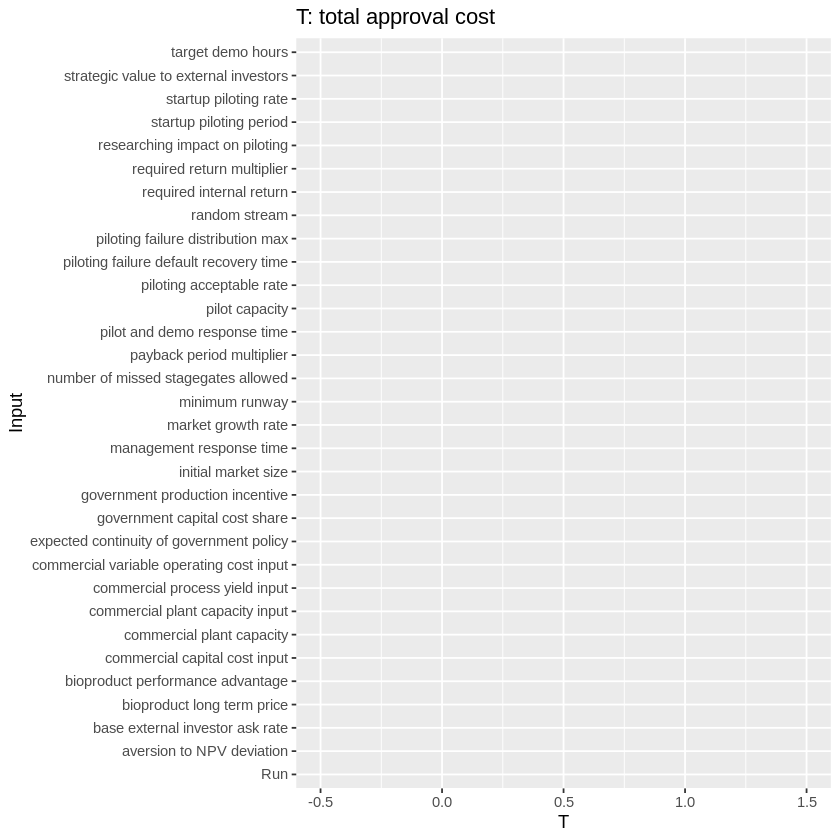

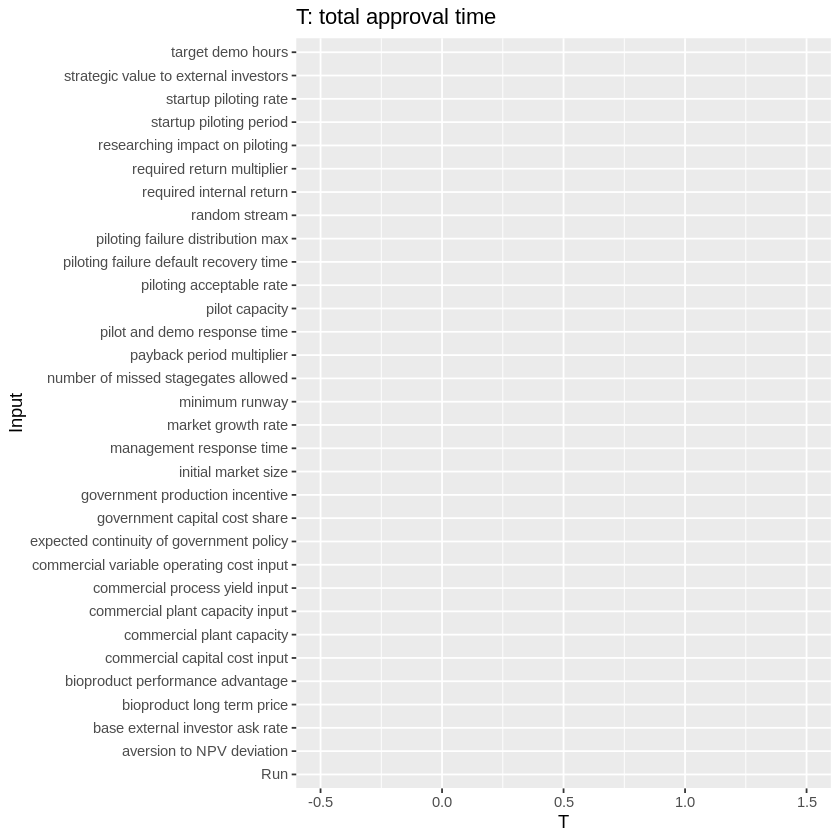

Warning message:
"Removed 9600 rows containing non-finite values (stat_boxplot)."

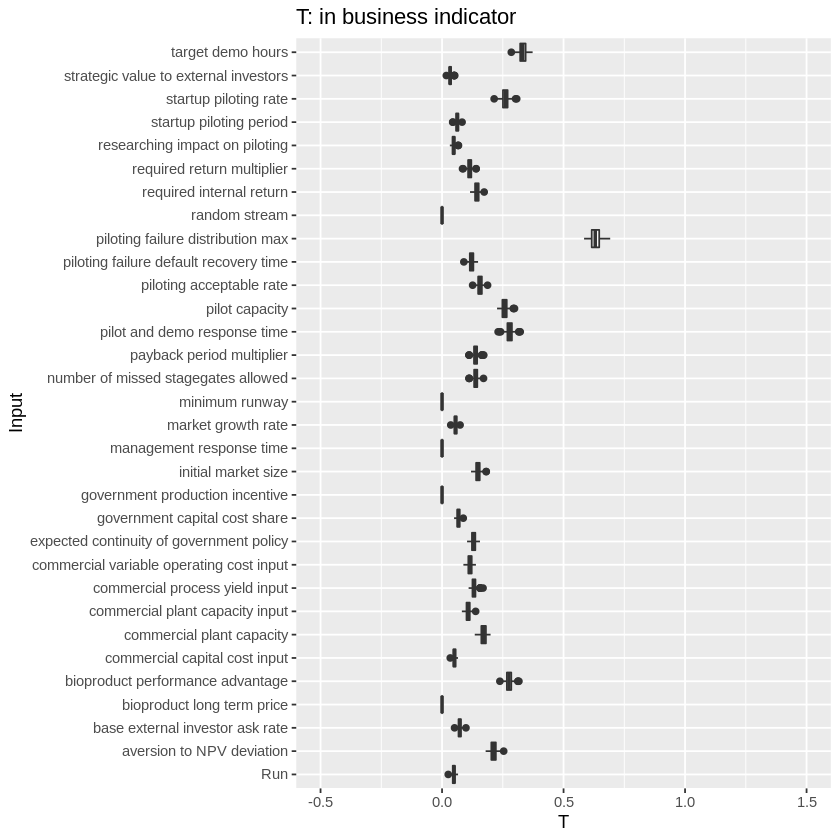

Warning message:
"Removed 17 rows containing non-finite values (stat_boxplot)."

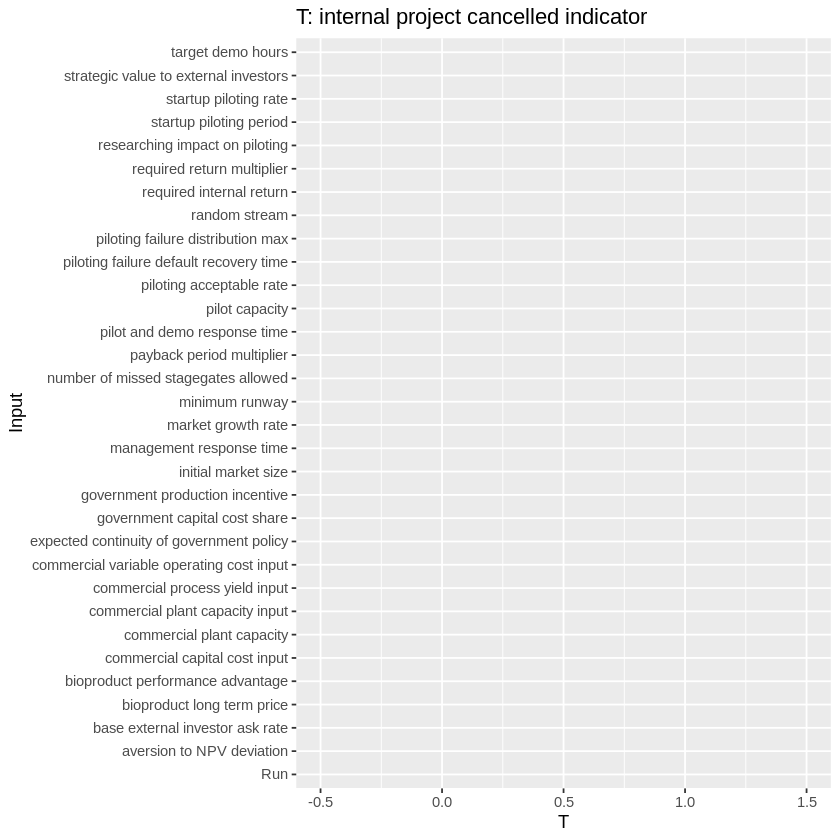

Warning message:
"Removed 743 rows containing non-finite values (stat_boxplot)."

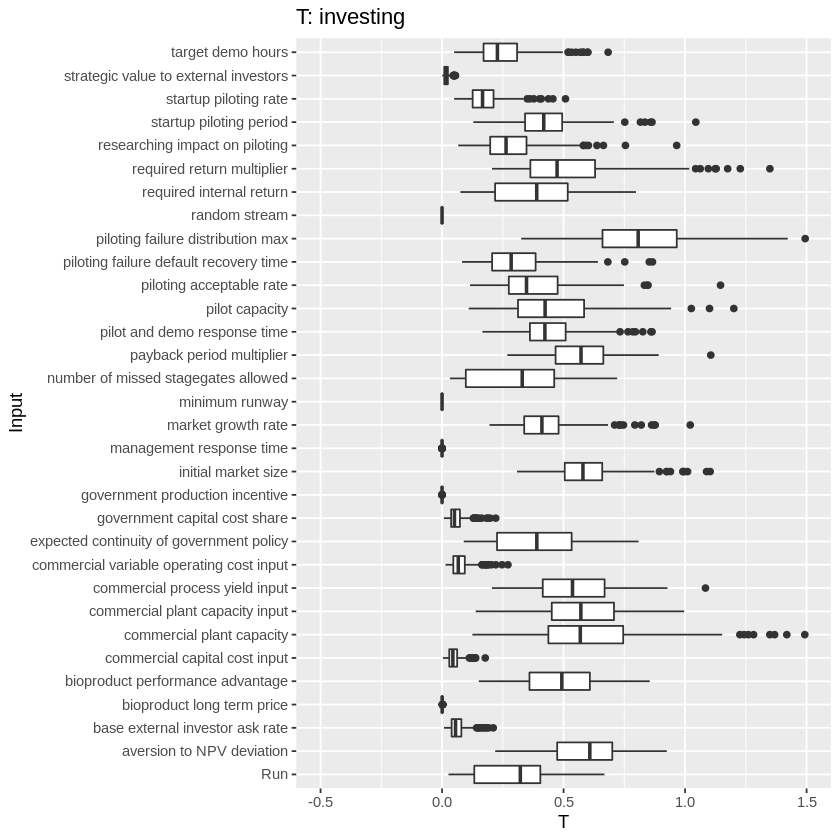

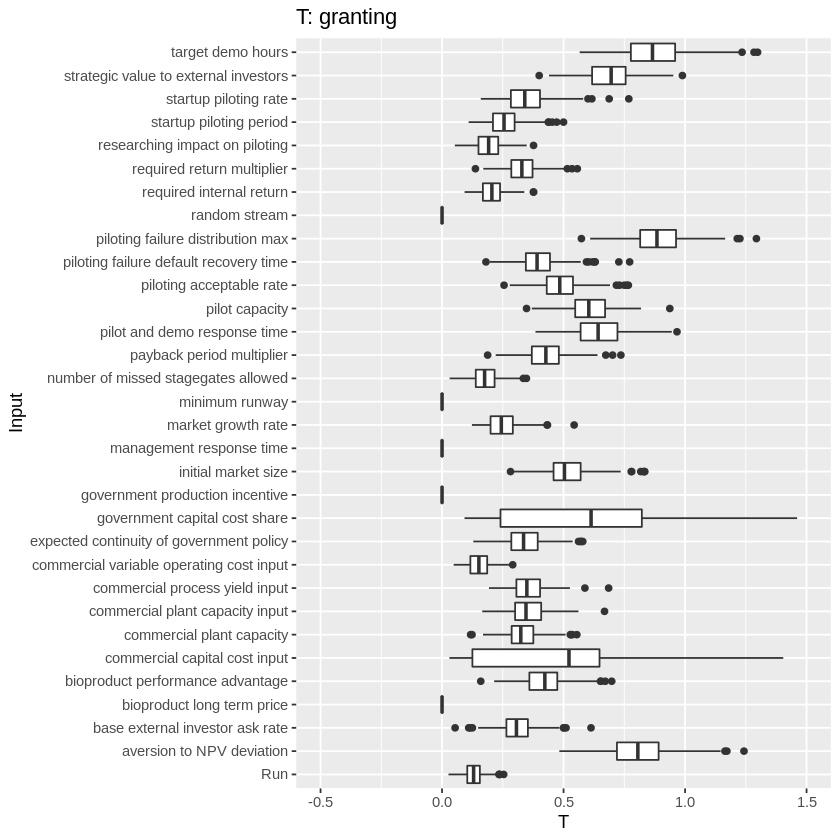

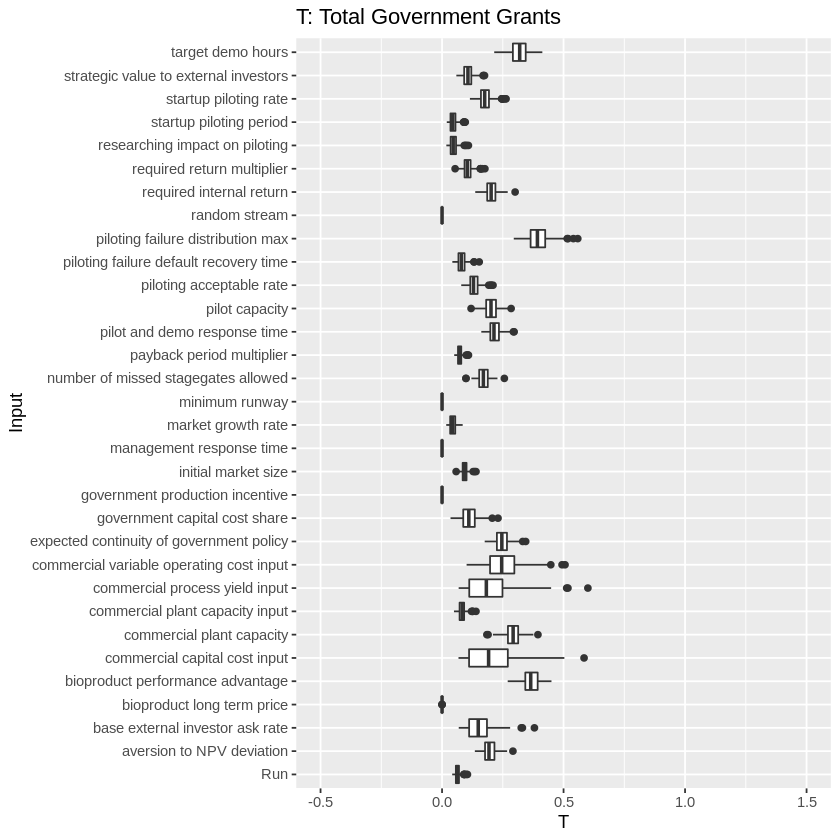

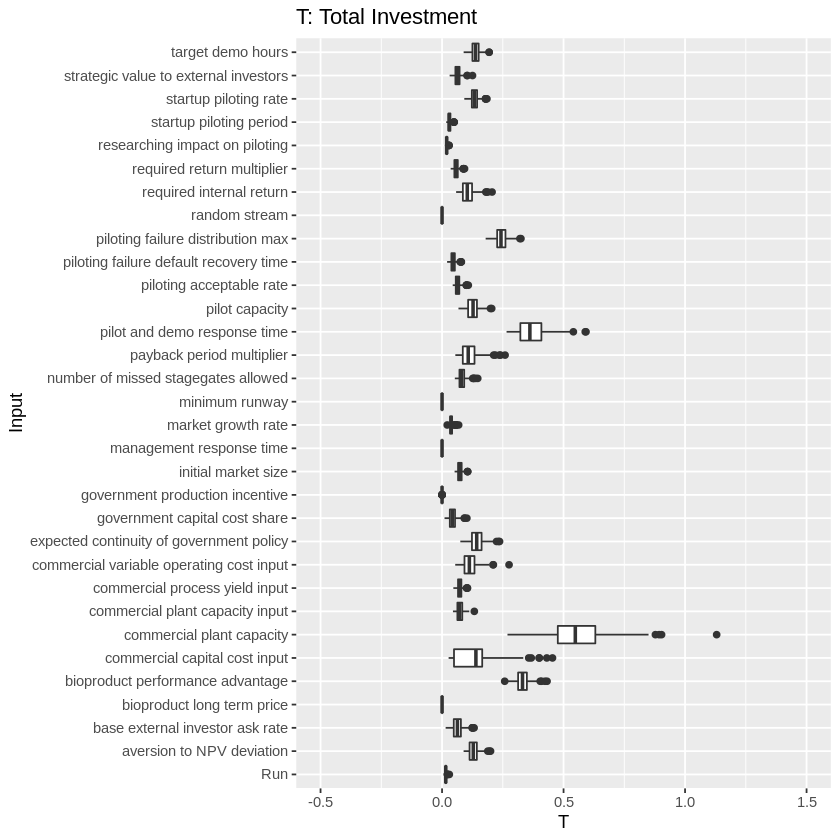

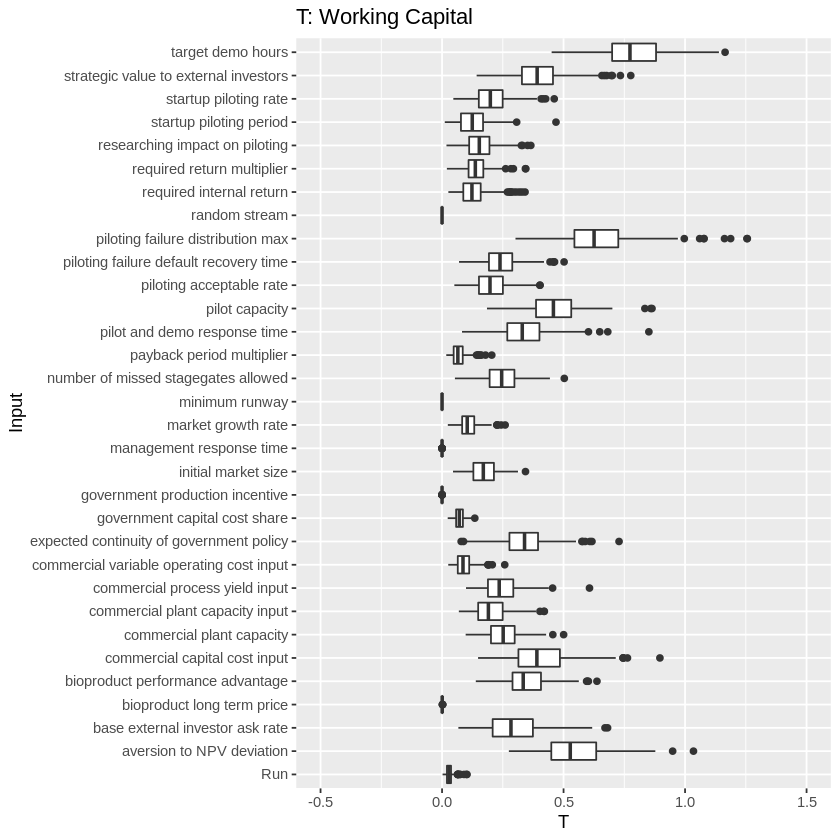

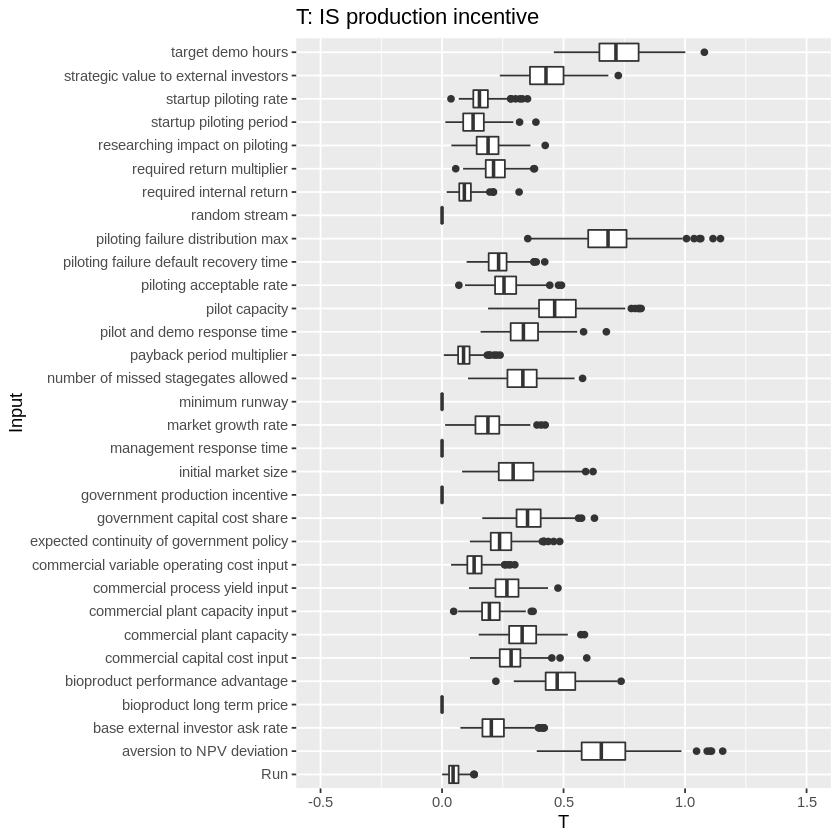

In [19]:
for (output in z.sens.boot[, unique(Output)]) {
    g <- ggplot(z.sens.boot[Output == output], aes(x=Input, y=T)) +
        geom_boxplot() +
        ylim(-0.5, 1.5) +
        coord_flip() +
        ggtitle(paste("T:",output))
    print(g)
}

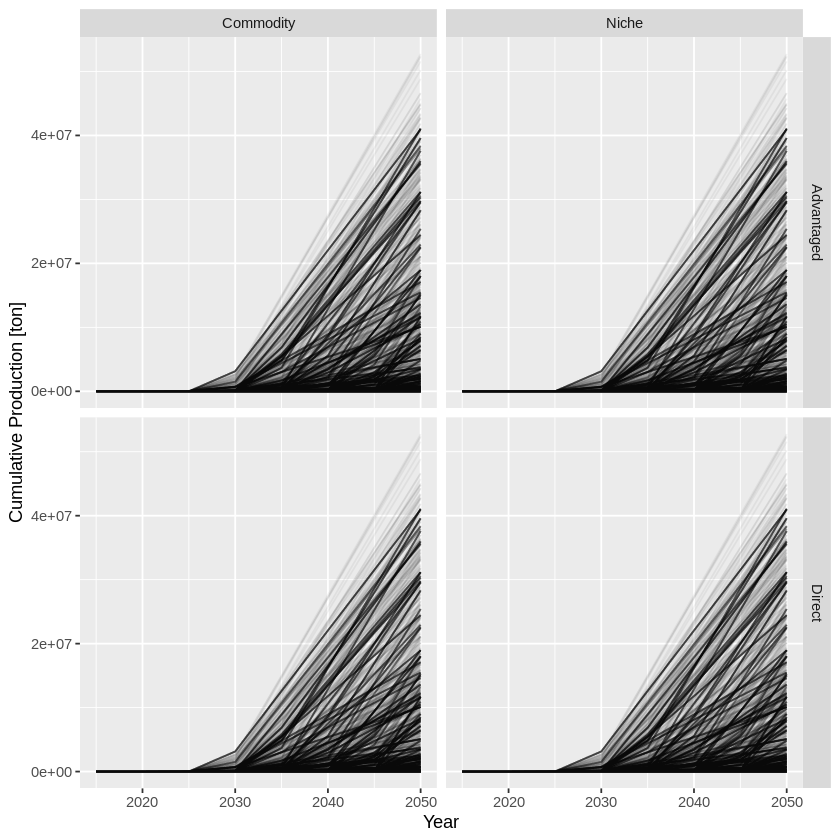

In [36]:
ggplot(z.outputs, aes(x=Time, y=`Cumulative Production`, group=Run)) +
    geom_line(alpha = 0.05) +
    facet_grid(Replacement ~ Scale) +
    xlab("Year") +
    ylab("Cumulative Production [ton]")